In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset using Dask
file_path = 'smoking_driking_dataset_Ver01.csv'
dask_df = dd.read_csv(file_path)

# Functions for processing the data
def identify_numeric_columns(df):
    """Identify numeric columns in the dataset."""
    numeric_cols = df.select_dtypes(include=['number']).columns
    return numeric_cols

def identify_categorical_columns(df):
    """Identify categorical columns in the dataset."""
    categorical_cols = df.select_dtypes(include=['object']).columns
    return categorical_cols

def impute_numeric_columns(df, numeric_cols):
    """Impute missing values in numeric columns."""
    for col in numeric_cols:
        col_mean = df[col].mean().compute()  # Compute mean lazily for the column
        df[col] = df[col].fillna(col_mean)  # Use scalar mean value to fill NaNs
    return df

def scale_numeric_columns(df, numeric_cols):
    """Scale numeric columns using z-score normalization."""
    for col in numeric_cols:
        col_mean = df[col].mean().compute()  # Compute mean lazily
        col_std = df[col].std().compute()   # Compute std deviation lazily
        df[col] = df[col].map_partitions(lambda x: (x - col_mean) / col_std)  # Scale lazily
    return df

def encode_categorical_columns(df, categorical_cols):
    """Convert categorical columns to dummies."""
    df = df.categorize(columns=categorical_cols)  # Categorize all categorical columns
    df = dd.get_dummies(df, columns=categorical_cols, drop_first=True)  # Perform one-hot encoding
    return df

def preprocess_dataset(df):
    """Perform preprocessing steps on the dataset."""
    numeric_cols = identify_numeric_columns(df)
    categorical_cols = identify_categorical_columns(df)

    df = impute_numeric_columns(df, numeric_cols)
    df = scale_numeric_columns(df, numeric_cols)
    df = encode_categorical_columns(df, categorical_cols)

    return df

# Apply preprocessing to the Dask dataframe
dask_df = preprocess_dataset(dask_df)

# Save the processed data
output_file = 'processed_health_data.csv'
dask_df.compute().to_csv(output_file, index=False)  # Compute and save to CSV

# Verify the results
df_sample = pd.read_csv(output_file)
numeric_cols = identify_numeric_columns(df_sample)
categorical_cols = identify_categorical_columns(df_sample)

print("Processed Data Sample:")
print(df_sample.head())

print("Numeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

# Debug information
for col in numeric_cols[:5]:
    print(f"Statistics for {col}:")
    print("Mean:", df_sample[col].mean())
    print("Std Dev:", df_sample[col].std())
    print("Min:", df_sample[col].min())
    print("Max:", df_sample[col].max())

# Summarize missing values
missing_values = df_sample.isnull().sum()
print("Missing Values per Column:")
print(missing_values)


Processed Data Sample:
         age      height     weight   waistline  sight_left  sight_right  \
0  40.796078  205.730512  89.665540  107.991588   -0.742964    -0.742964   
1  34.687395  217.947878  95.774223  106.769852   -0.865138    -0.498617   
2  46.904761  199.621830  89.665540  109.213325   -0.498617    -0.132096   
3  59.122126  211.839195  95.774223  109.213325   -0.132096    -0.498617   
4  59.122126  199.621830  71.339492   95.774223   -0.742964    -0.498617   

   hear_left  hear_right         SBP         DBP  ...  triglyceride  \
0  -0.742964   -0.742964  144.643685   95.774223  ...    110.435061   
1  -0.742964   -0.742964  156.861050   98.217696  ...    145.865421   
2  -0.742964   -0.742964  144.643685   83.556857  ...    125.095900   
3  -0.742964   -0.742964  175.187099  104.326379  ...    127.539373   
4  -0.742964   -0.742964  166.634943   98.217696  ...    125.095900   

   hemoglobin  urine_protein  serum_creatinine   SGOT_AST   SGOT_ALT  \
0   18.926994      -0

In [2]:
!pip install networkx

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the processed dataset
file_path = 'processed_health_data.csv'
df = pd.read_csv(file_path)

# Function to analyze the distribution of numeric columns
def analyze_distribution(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        plt.figure(figsize=(20, 20))
        sns.histplot(df[col], kde=True, bins=30, color='blue', edgecolor='black', alpha=0.7)
        plt.title(f"Distribution of {col}", fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.grid(axis='y', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.savefig(f"eda_distribution_{col}.png", dpi=300)
        plt.close()

# Analyze distribution
analyze_distribution(df)

# Function to analyze correlations with enhanced visualization
def analyze_correlations(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(20, 20))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=True, fmt='.2f', linewidths=0.5, square=True)
    plt.title("Correlation Heatmap of Numeric Features", fontsize=18)
    plt.tight_layout()
    plt.savefig("eda_correlation_heatmap.png", dpi=300)
    plt.close()

    return correlation_matrix

# Analyze correlations
correlation_matrix = analyze_correlations(df)

# Function to create pair plots for a subset of numeric columns
def create_pair_plots(df, sample_size=1000):
    numeric_cols = df.select_dtypes(include=['number']).columns[:5]  # Select first 5 numeric columns
    sampled_df = df.sample(n=min(sample_size, len(df)), random_state=42)
    sns.pairplot(sampled_df[numeric_cols], diag_kind='kde', corner=True, plot_kws={'alpha': 0.7})
    plt.suptitle("Pairplot of Selected Numeric Features", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.savefig("eda_pairplot.png", dpi=300)
    plt.close()

# Create pair plots
create_pair_plots(df)

# Function to analyze categorical columns
def analyze_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        plt.figure(figsize=(20, 20))
        df[col].value_counts().plot(kind='bar', color='green', alpha=0.7, edgecolor='black')
        plt.title(f"Value Counts for {col}", fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel("Count", fontsize=14)
        plt.grid(axis='y', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.savefig(f"eda_categorical_{col}.png", dpi=300)
        plt.close()

# Analyze categorical columns
analyze_categorical_columns(df)

# Create custom features for deeper insights
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2
df['BP_Category'] = np.where(df['SBP'] >= 140, 'High', 
                              np.where(df['SBP'] >= 120, 'Elevated', 'Normal'))

# Function to explore relationships between features with enhanced plots
def explore_relationships(df):
    plt.figure(figsize=(20, 20))
    sns.boxplot(x='BP_Category', y='BMI', data=df, palette='Set3')
    plt.title("Boxplot of BMI by Blood Pressure Category", fontsize=18)
    plt.xlabel("Blood Pressure Category", fontsize=16)
    plt.ylabel("BMI", fontsize=16)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig("eda_boxplot_bmi_bp_category.png", dpi=300)
    plt.close()

    plt.figure(figsize=(20, 20))
    sns.scatterplot(x='BMI', y='SBP', hue='BP_Category', data=df, palette='viridis', s=100, edgecolor='black')
    plt.title("Scatterplot of BMI vs SBP", fontsize=18)
    plt.xlabel("BMI", fontsize=16)
    plt.ylabel("Systolic Blood Pressure", fontsize=16)
    plt.grid(axis='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig("eda_scatterplot_bmi_sbp.png", dpi=300)
    plt.close()

# Explore relationships
explore_relationships(df)

# Function to identify missing data patterns with enhanced visualization
def analyze_missing_data(df):
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    if not missing_data.empty:
        plt.figure(figsize=(20, 20))
        missing_data.plot(kind='bar', color='red', alpha=0.8, edgecolor='black')
        plt.title("Missing Data by Feature", fontsize=18)
        plt.ylabel("Number of Missing Values", fontsize=16)
        plt.xlabel("Features", fontsize=16)
        plt.grid(axis='y', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.savefig("eda_missing_data.png", dpi=300)
        plt.close()
    else:
        print("No missing data found.")

# Analyze missing data
analyze_missing_data(df)


C:\Users\A Sree Chaithanya\AppData\Local\Temp\ipykernel_37596\875917570.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BP_Category', y='BMI', data=df, palette='Set3')


No missing data found.


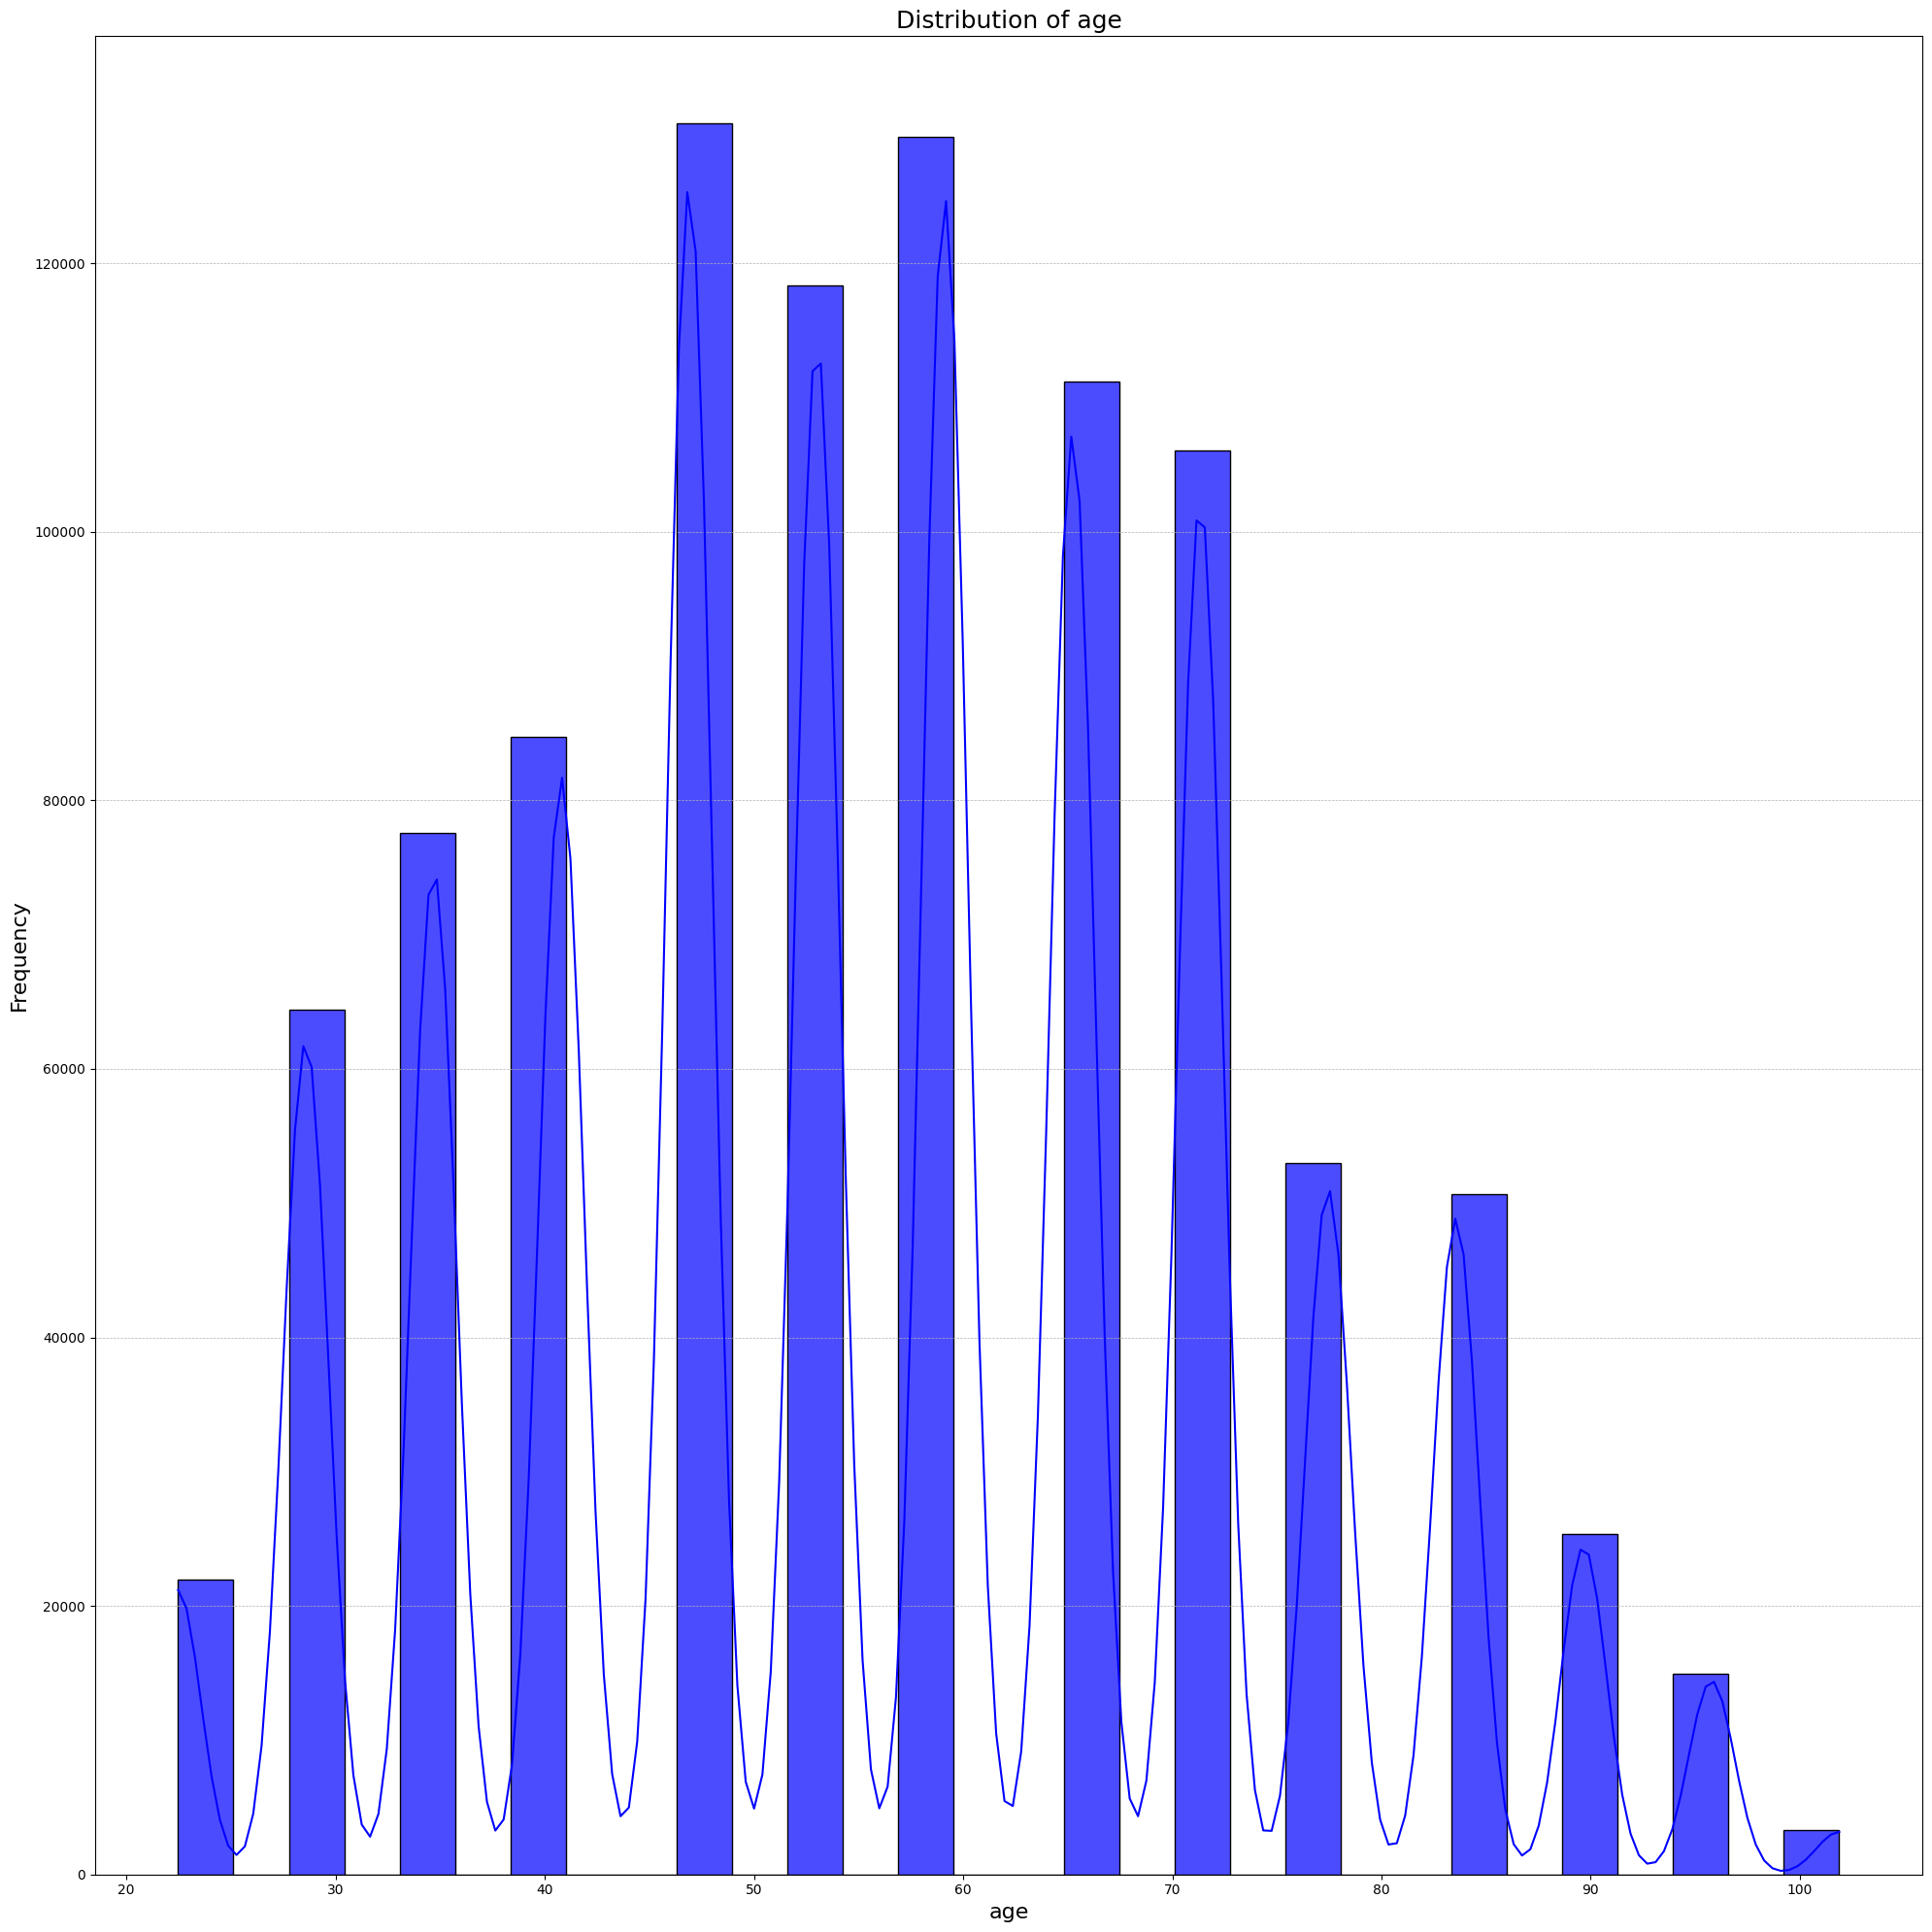

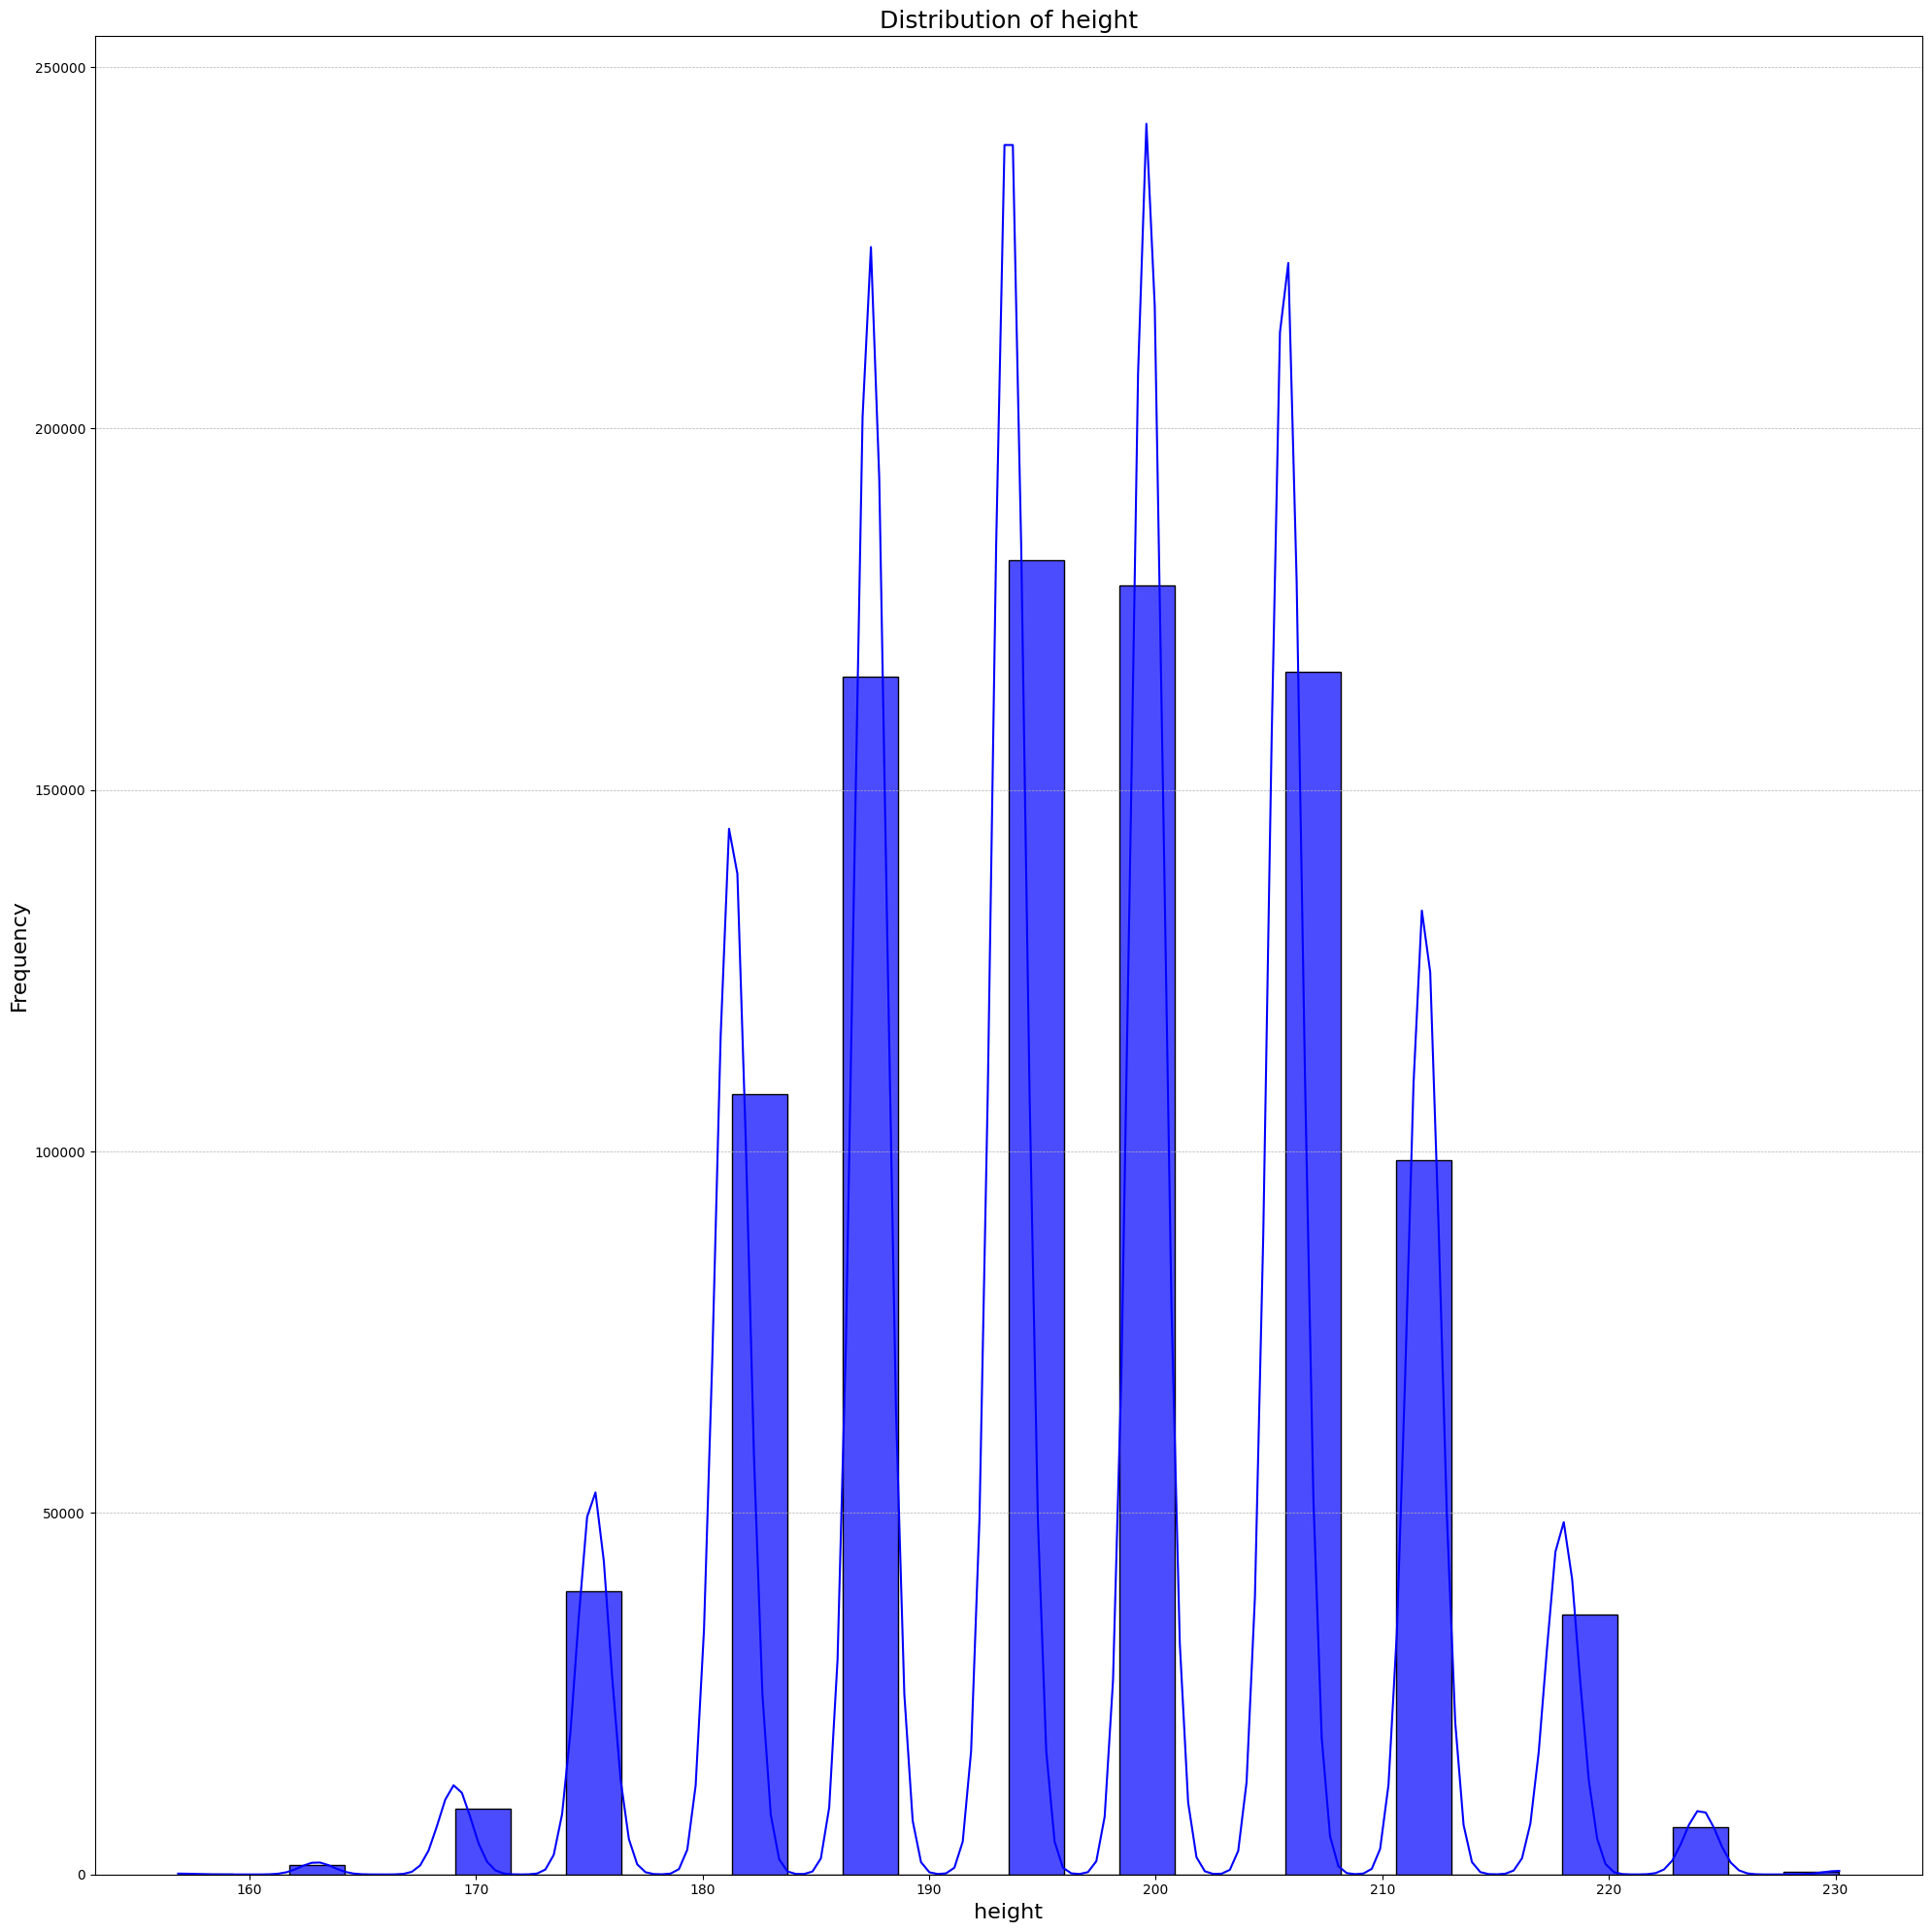

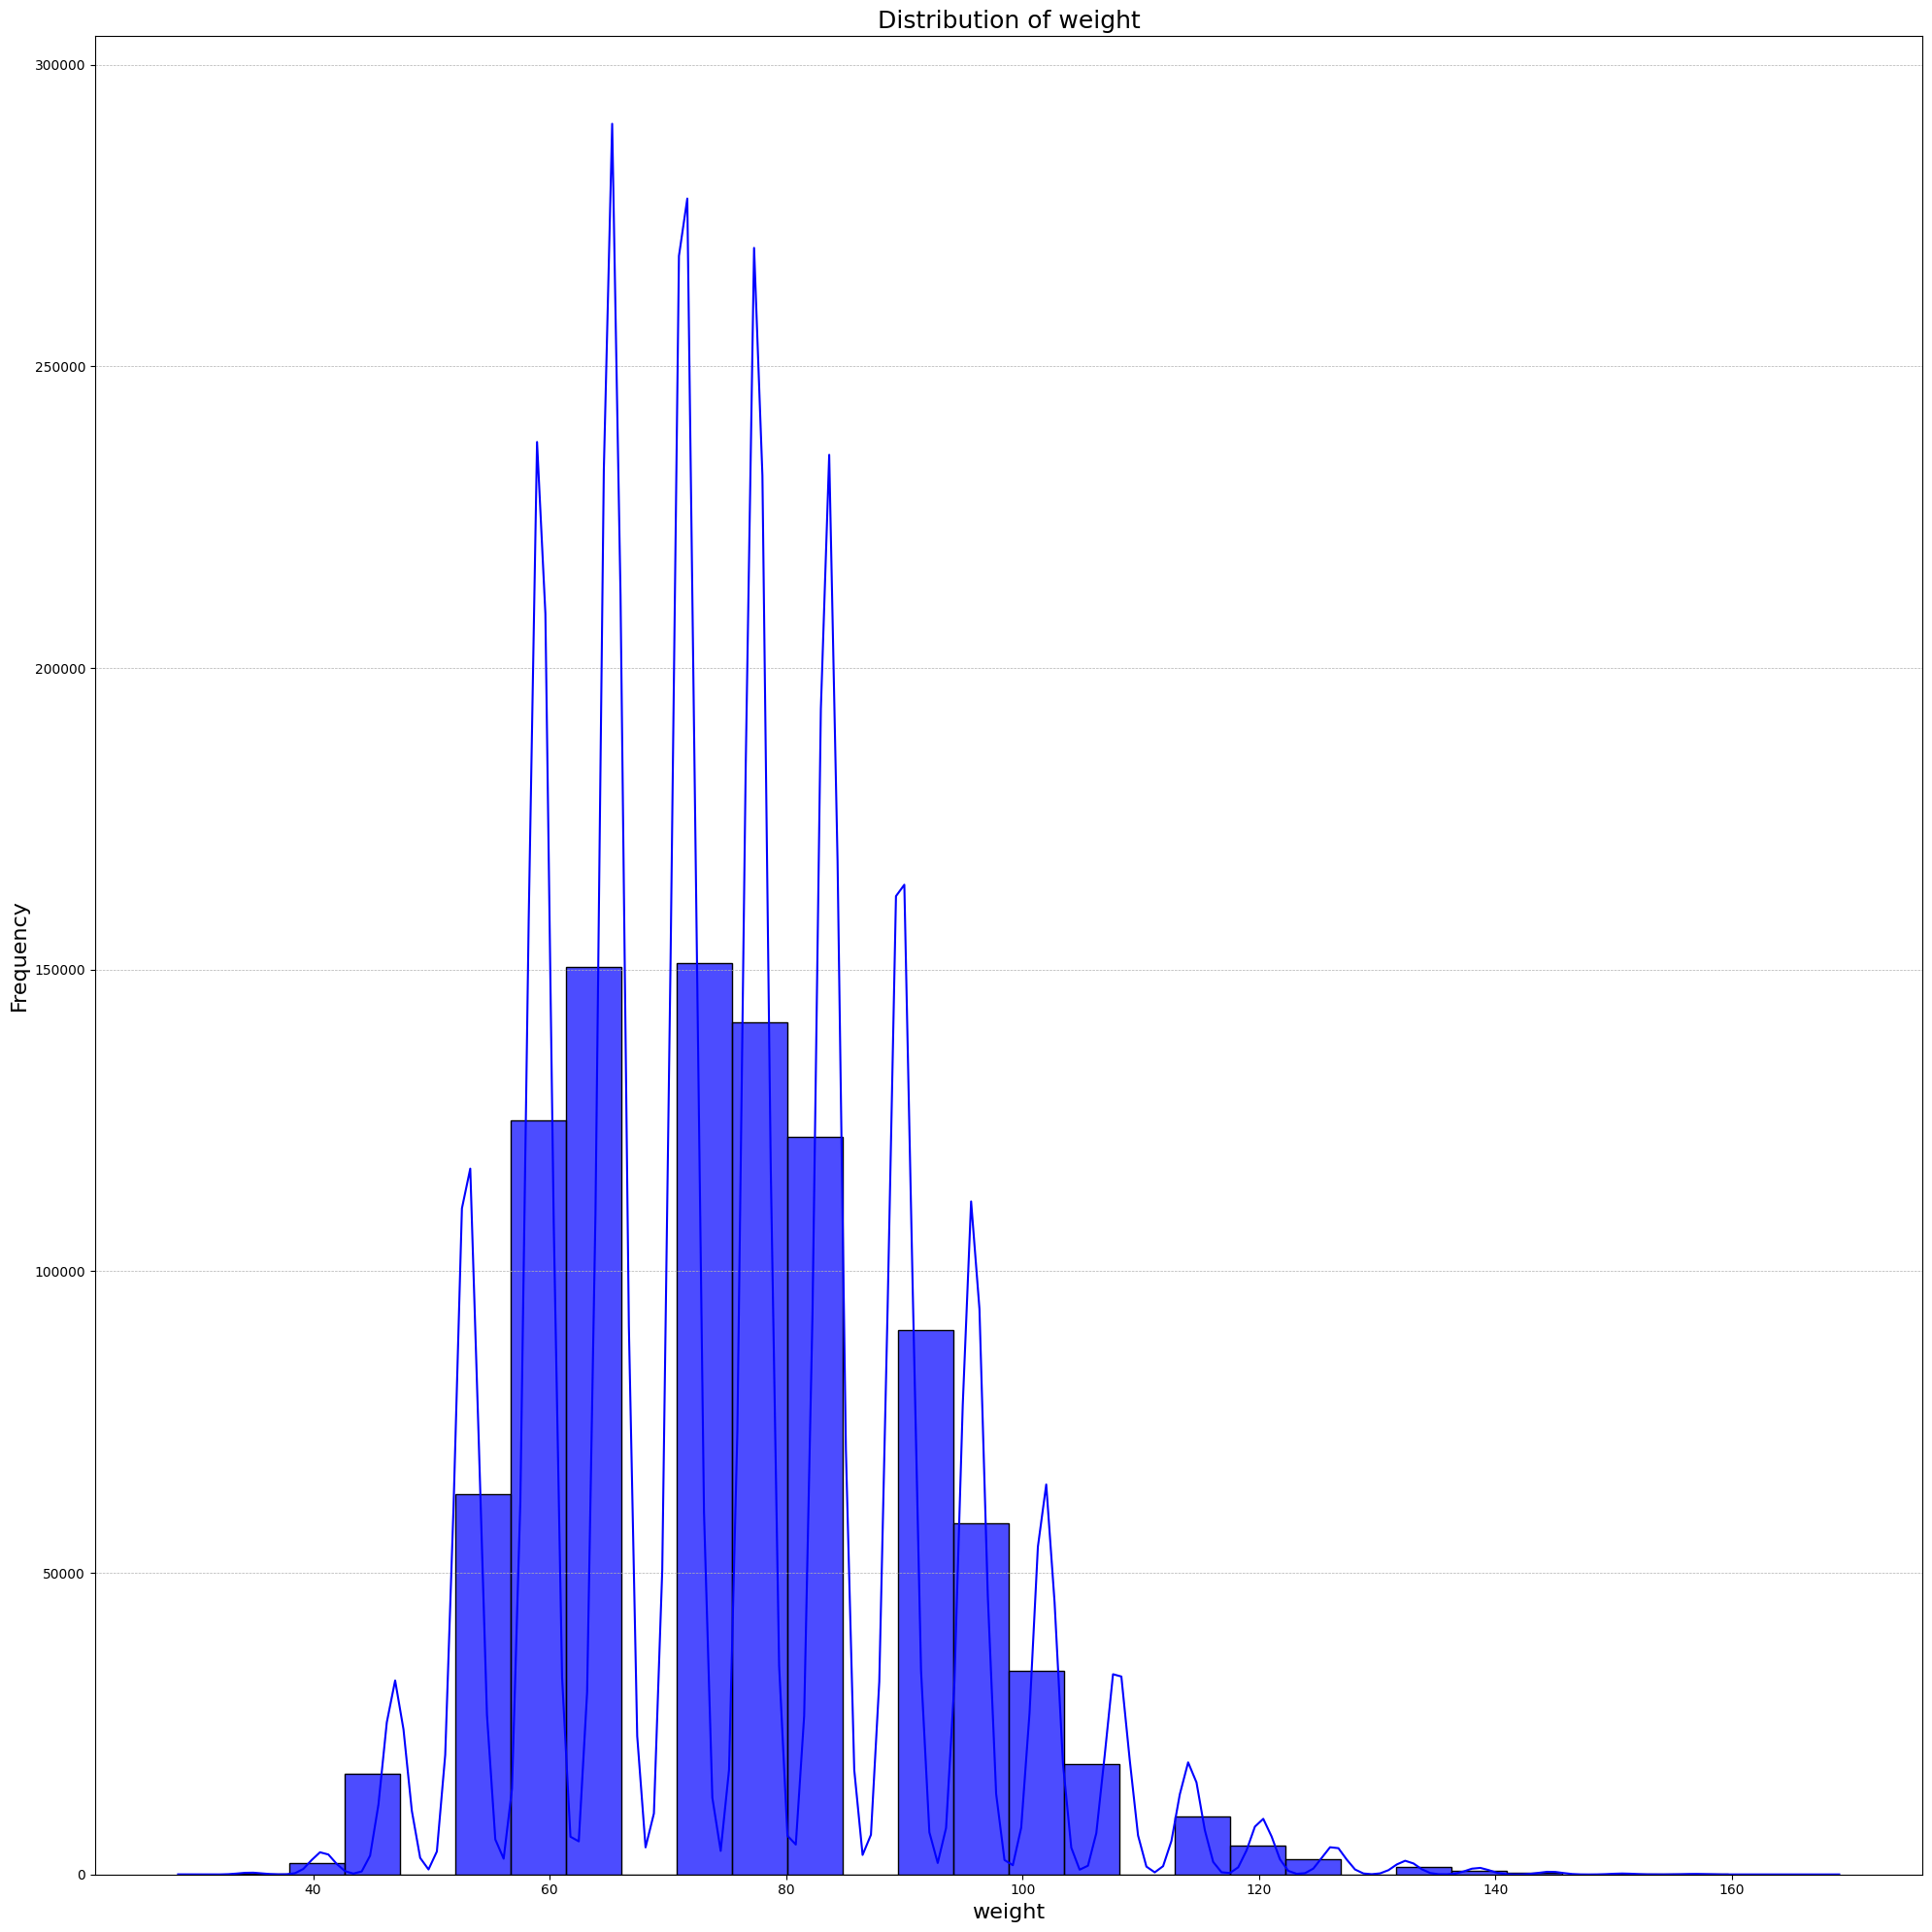

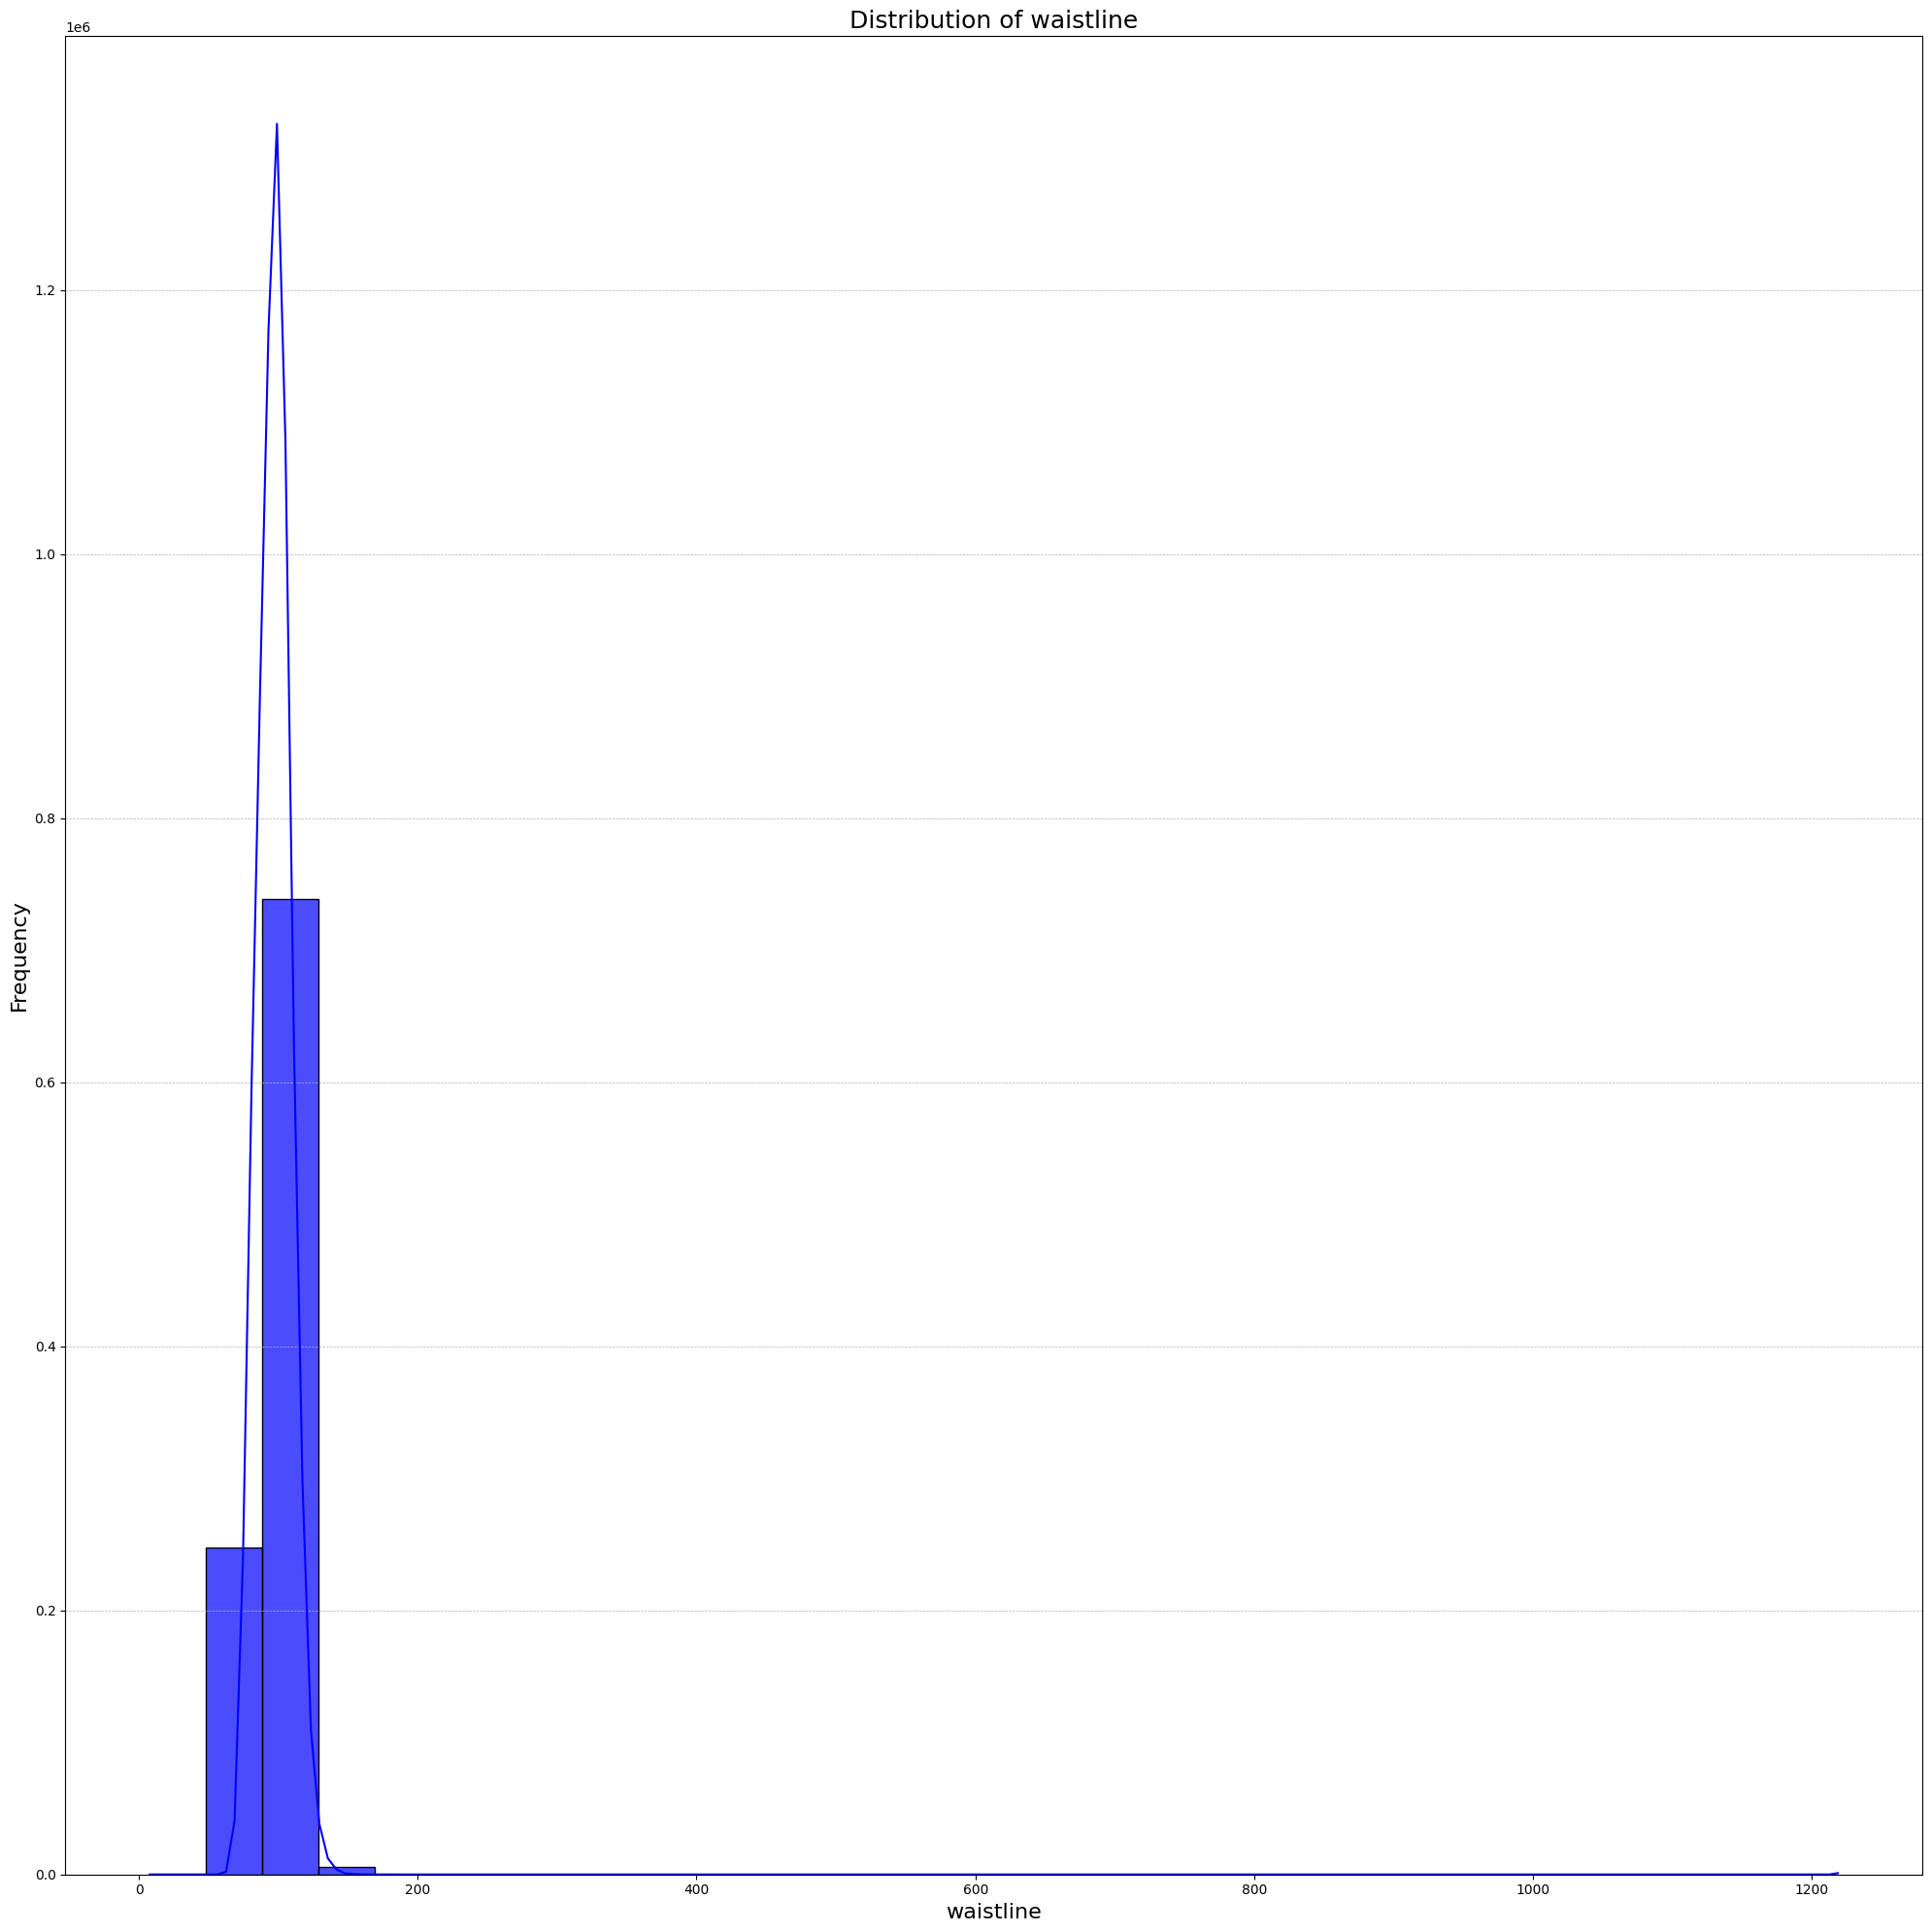

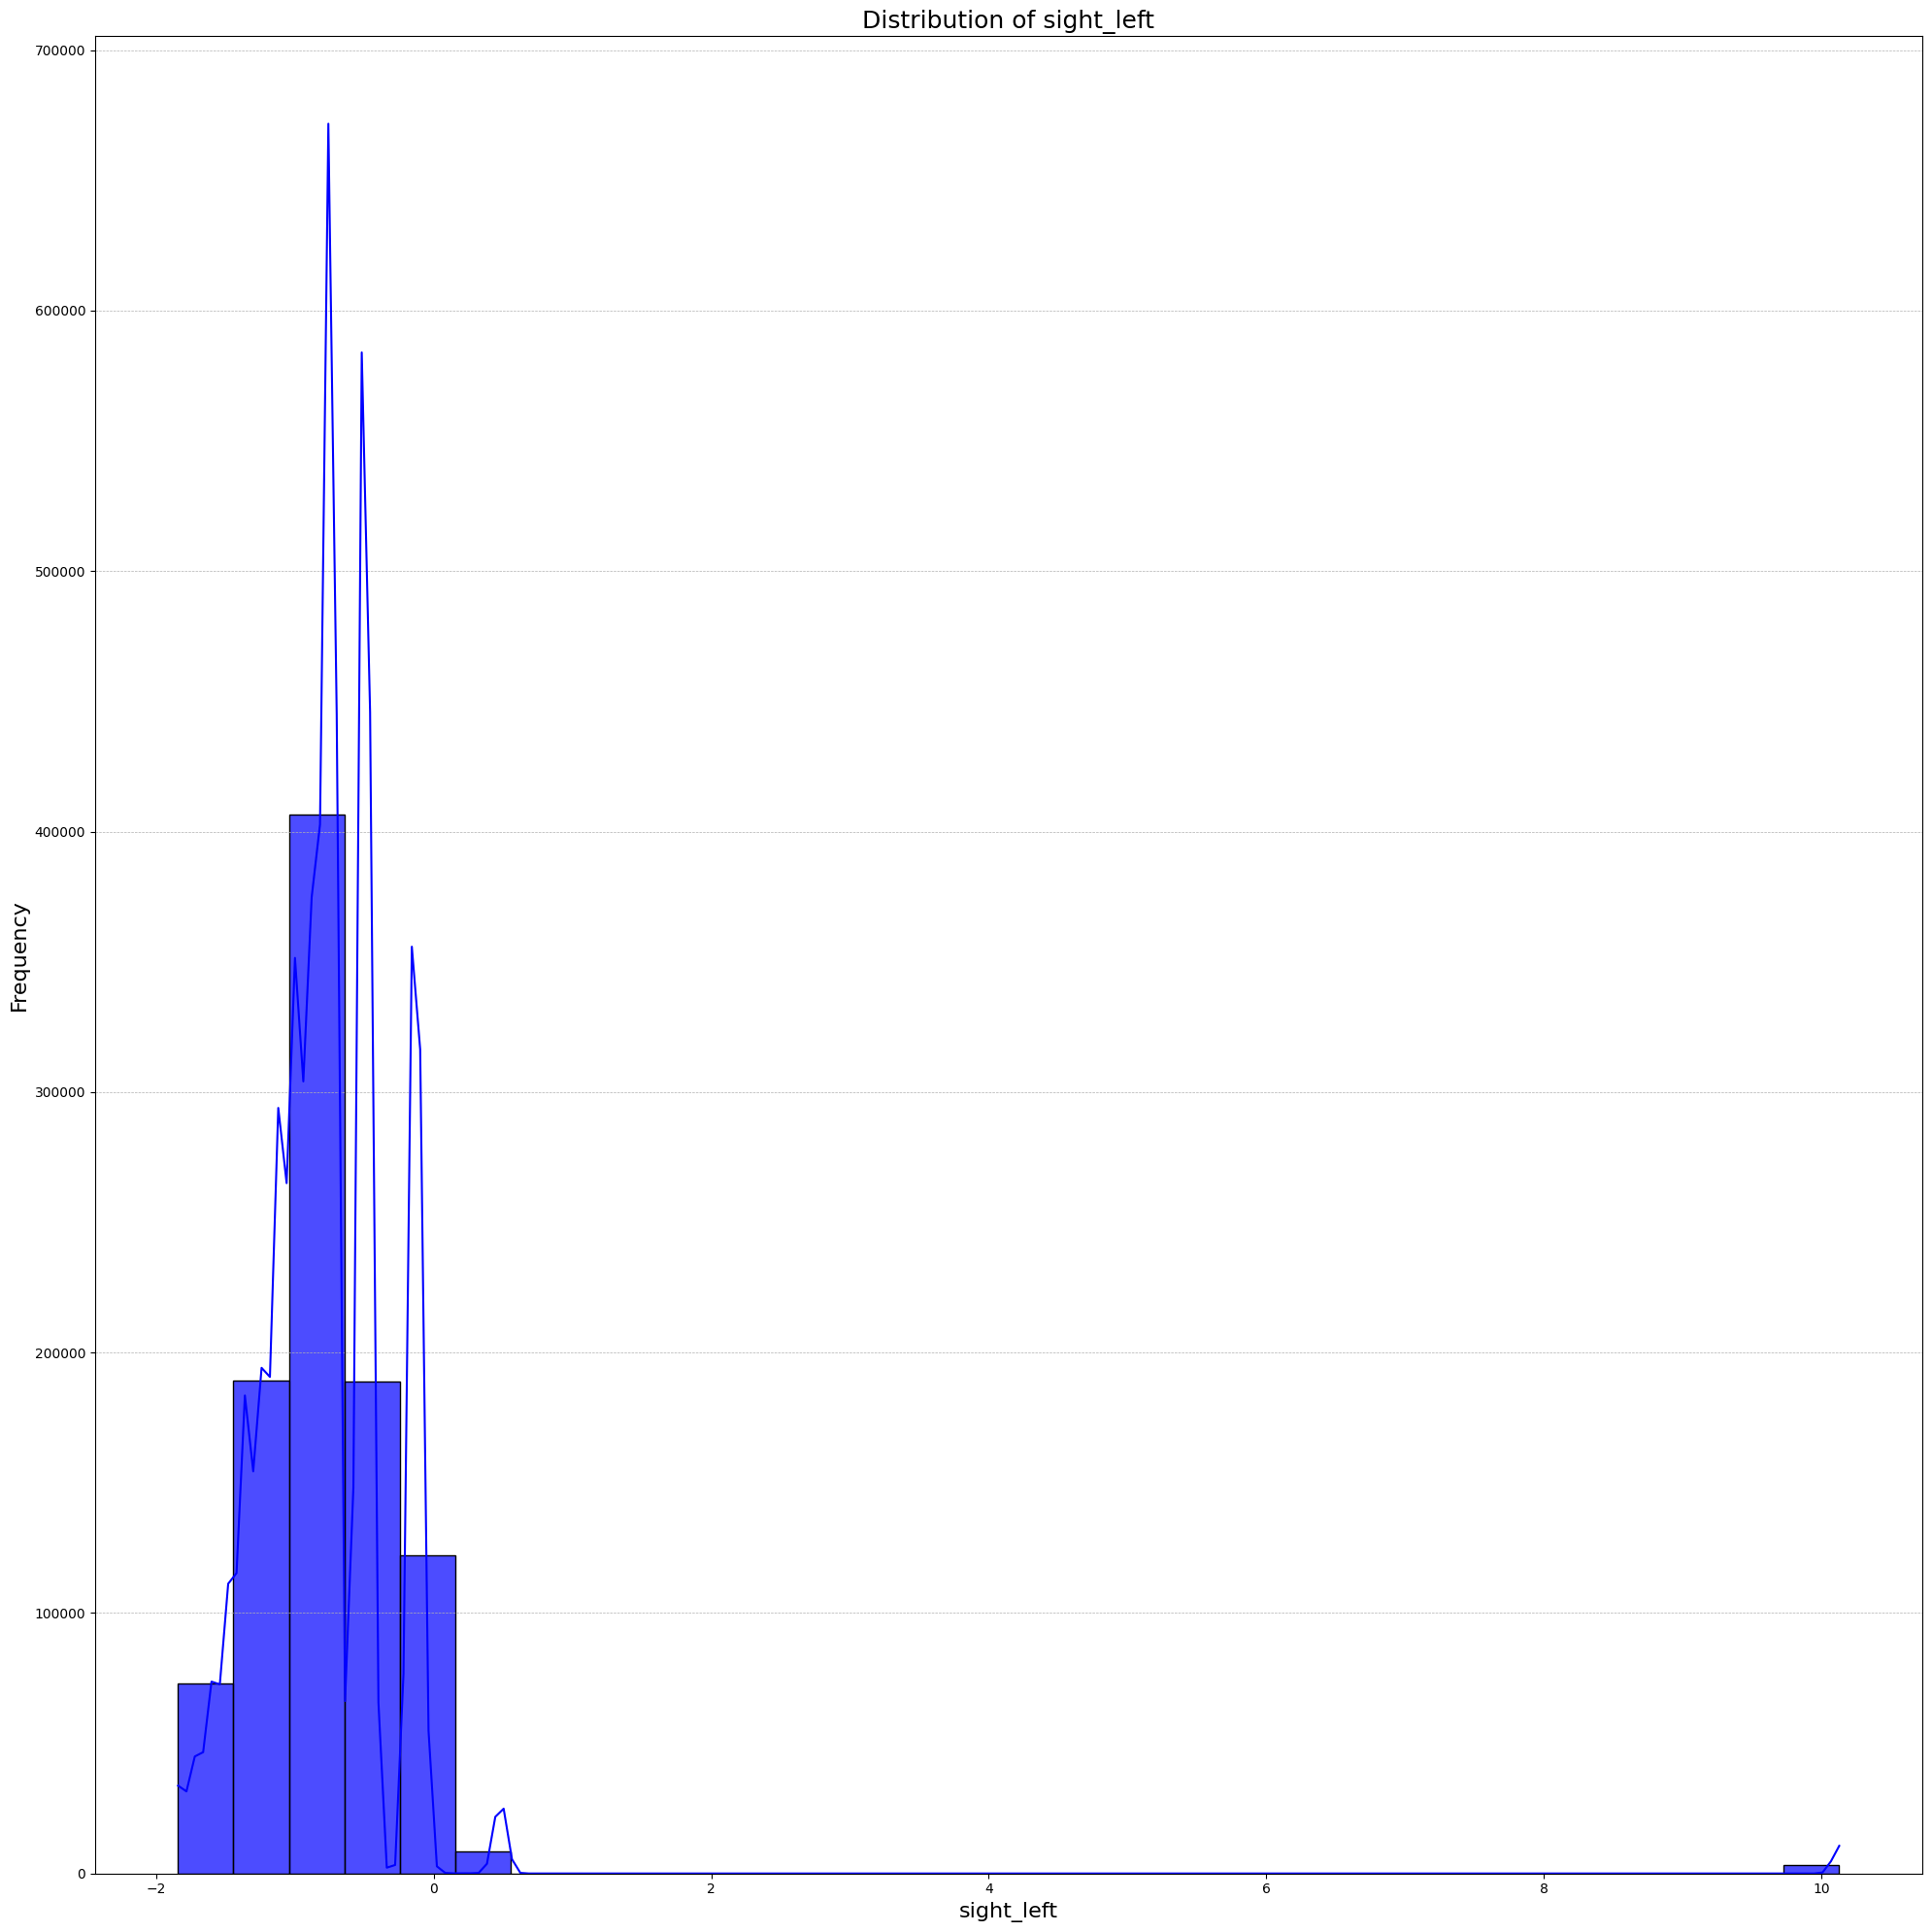

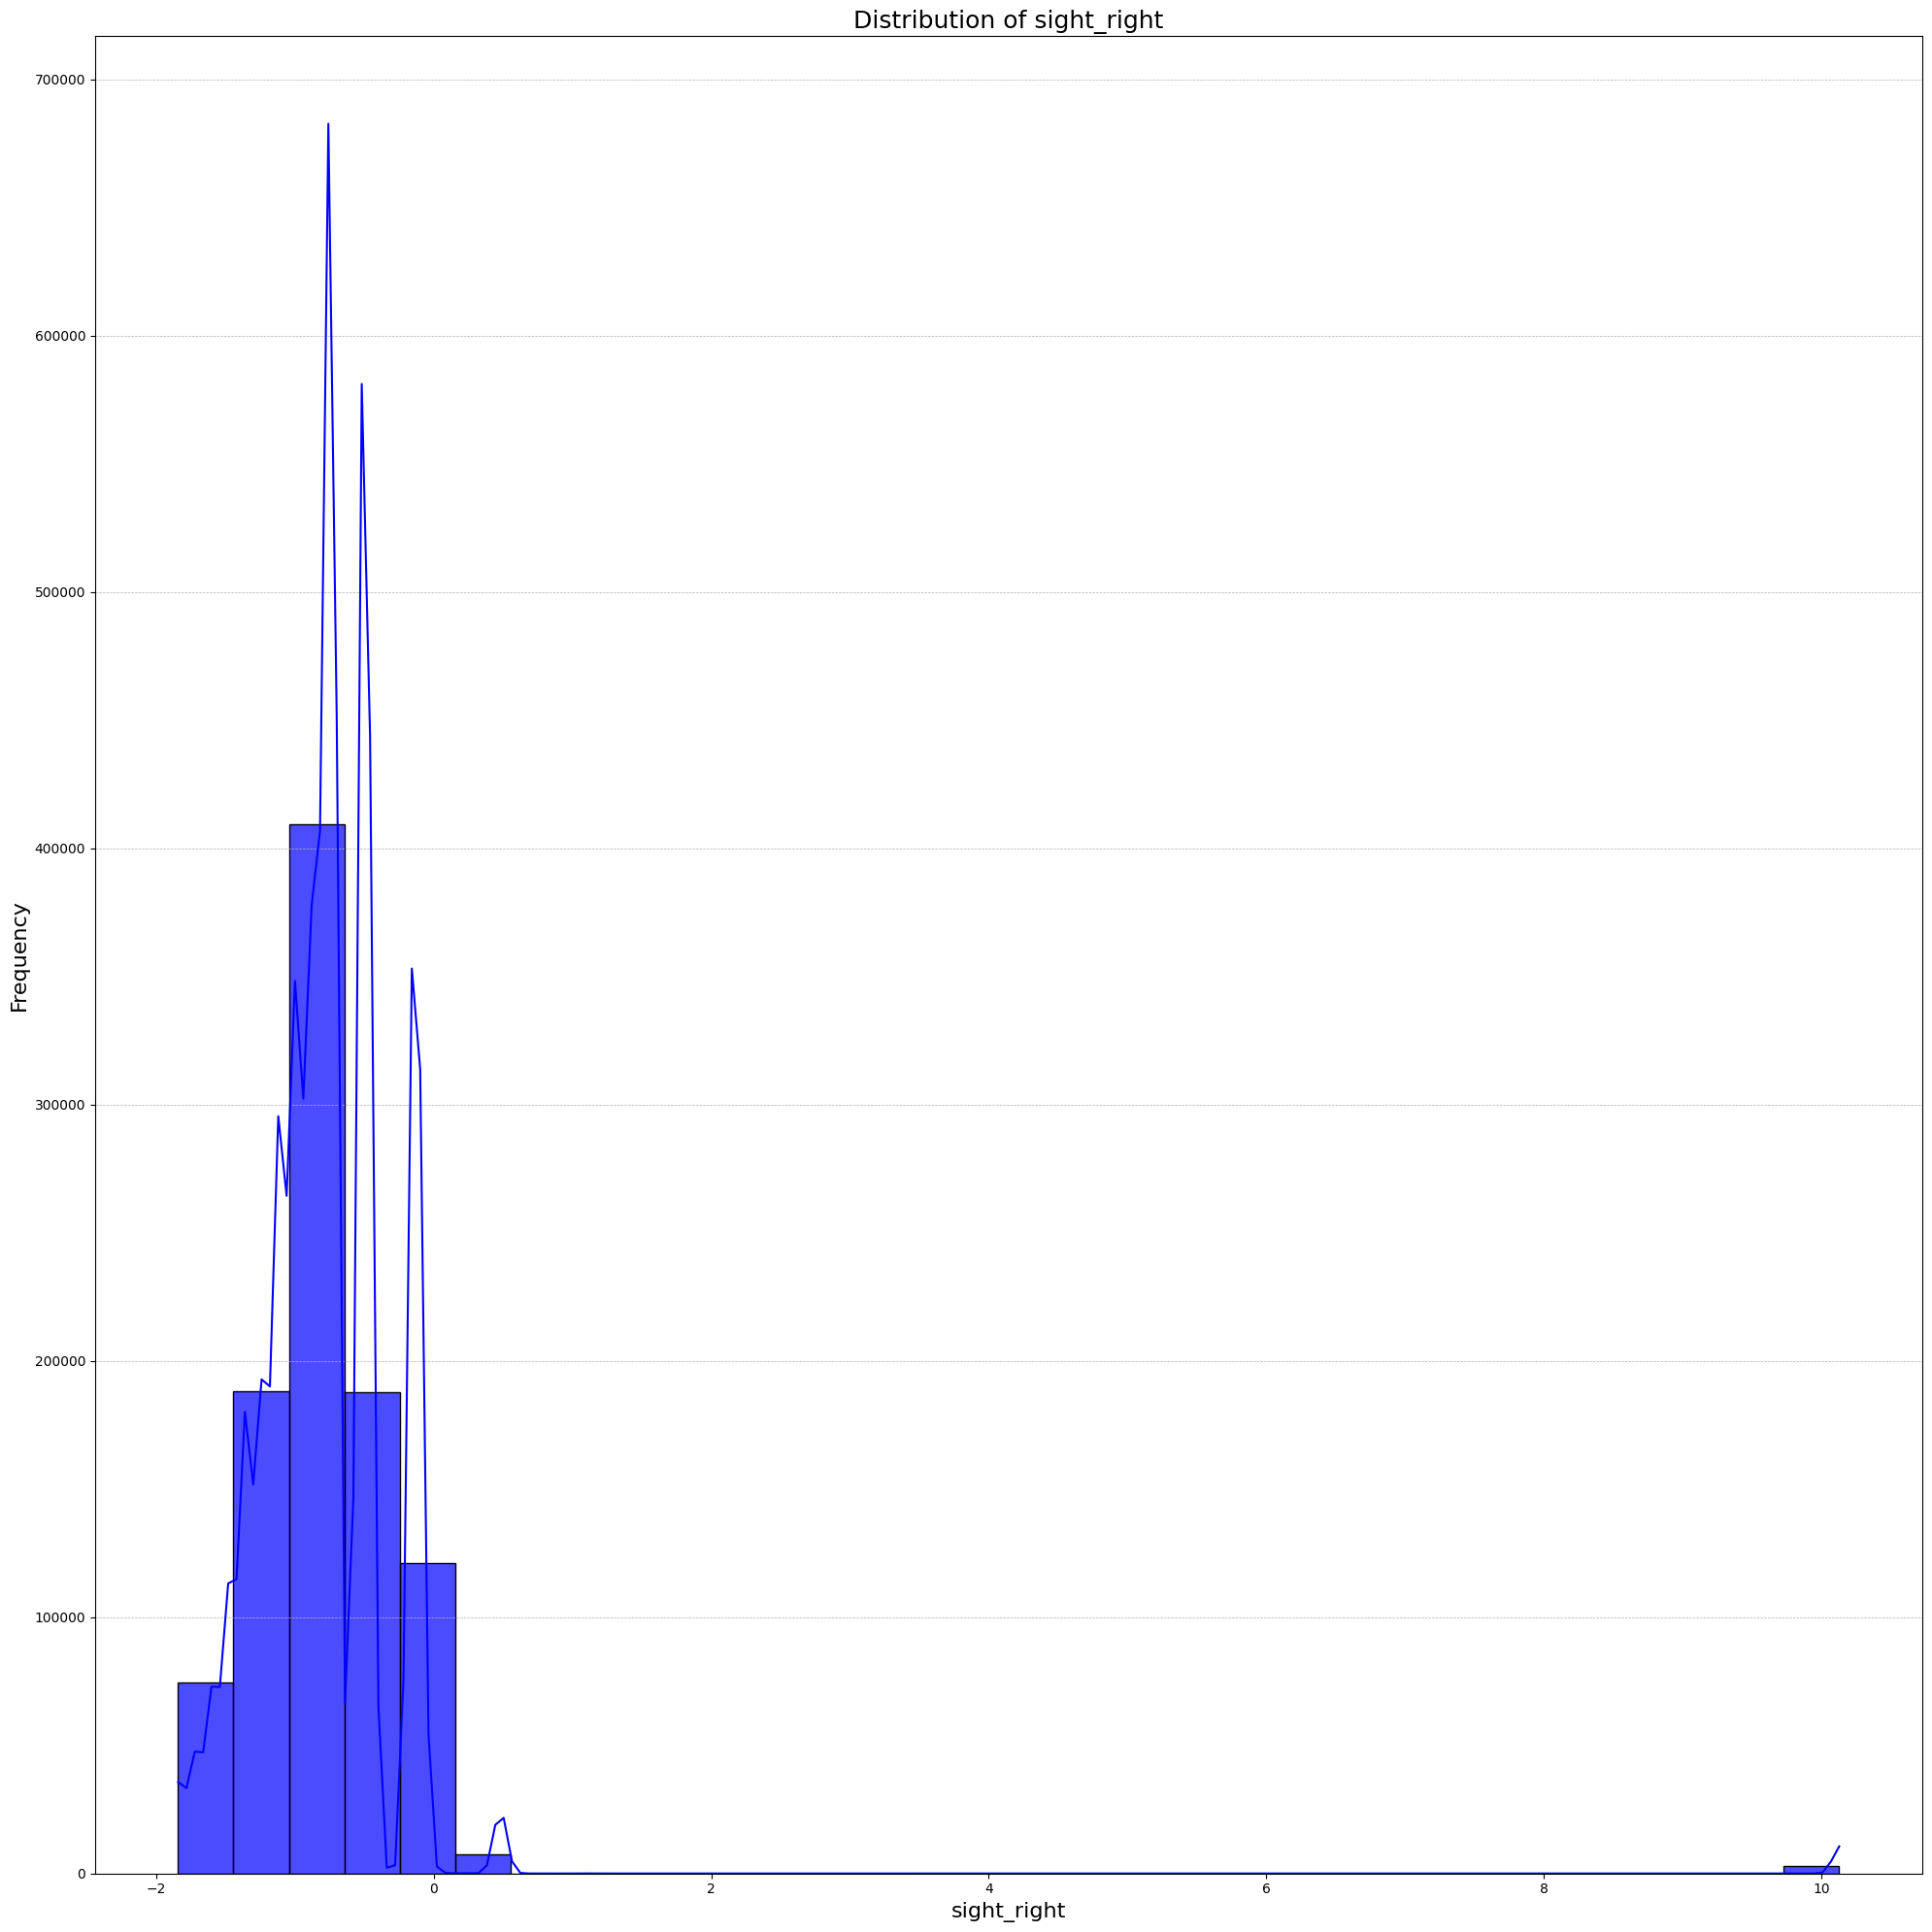

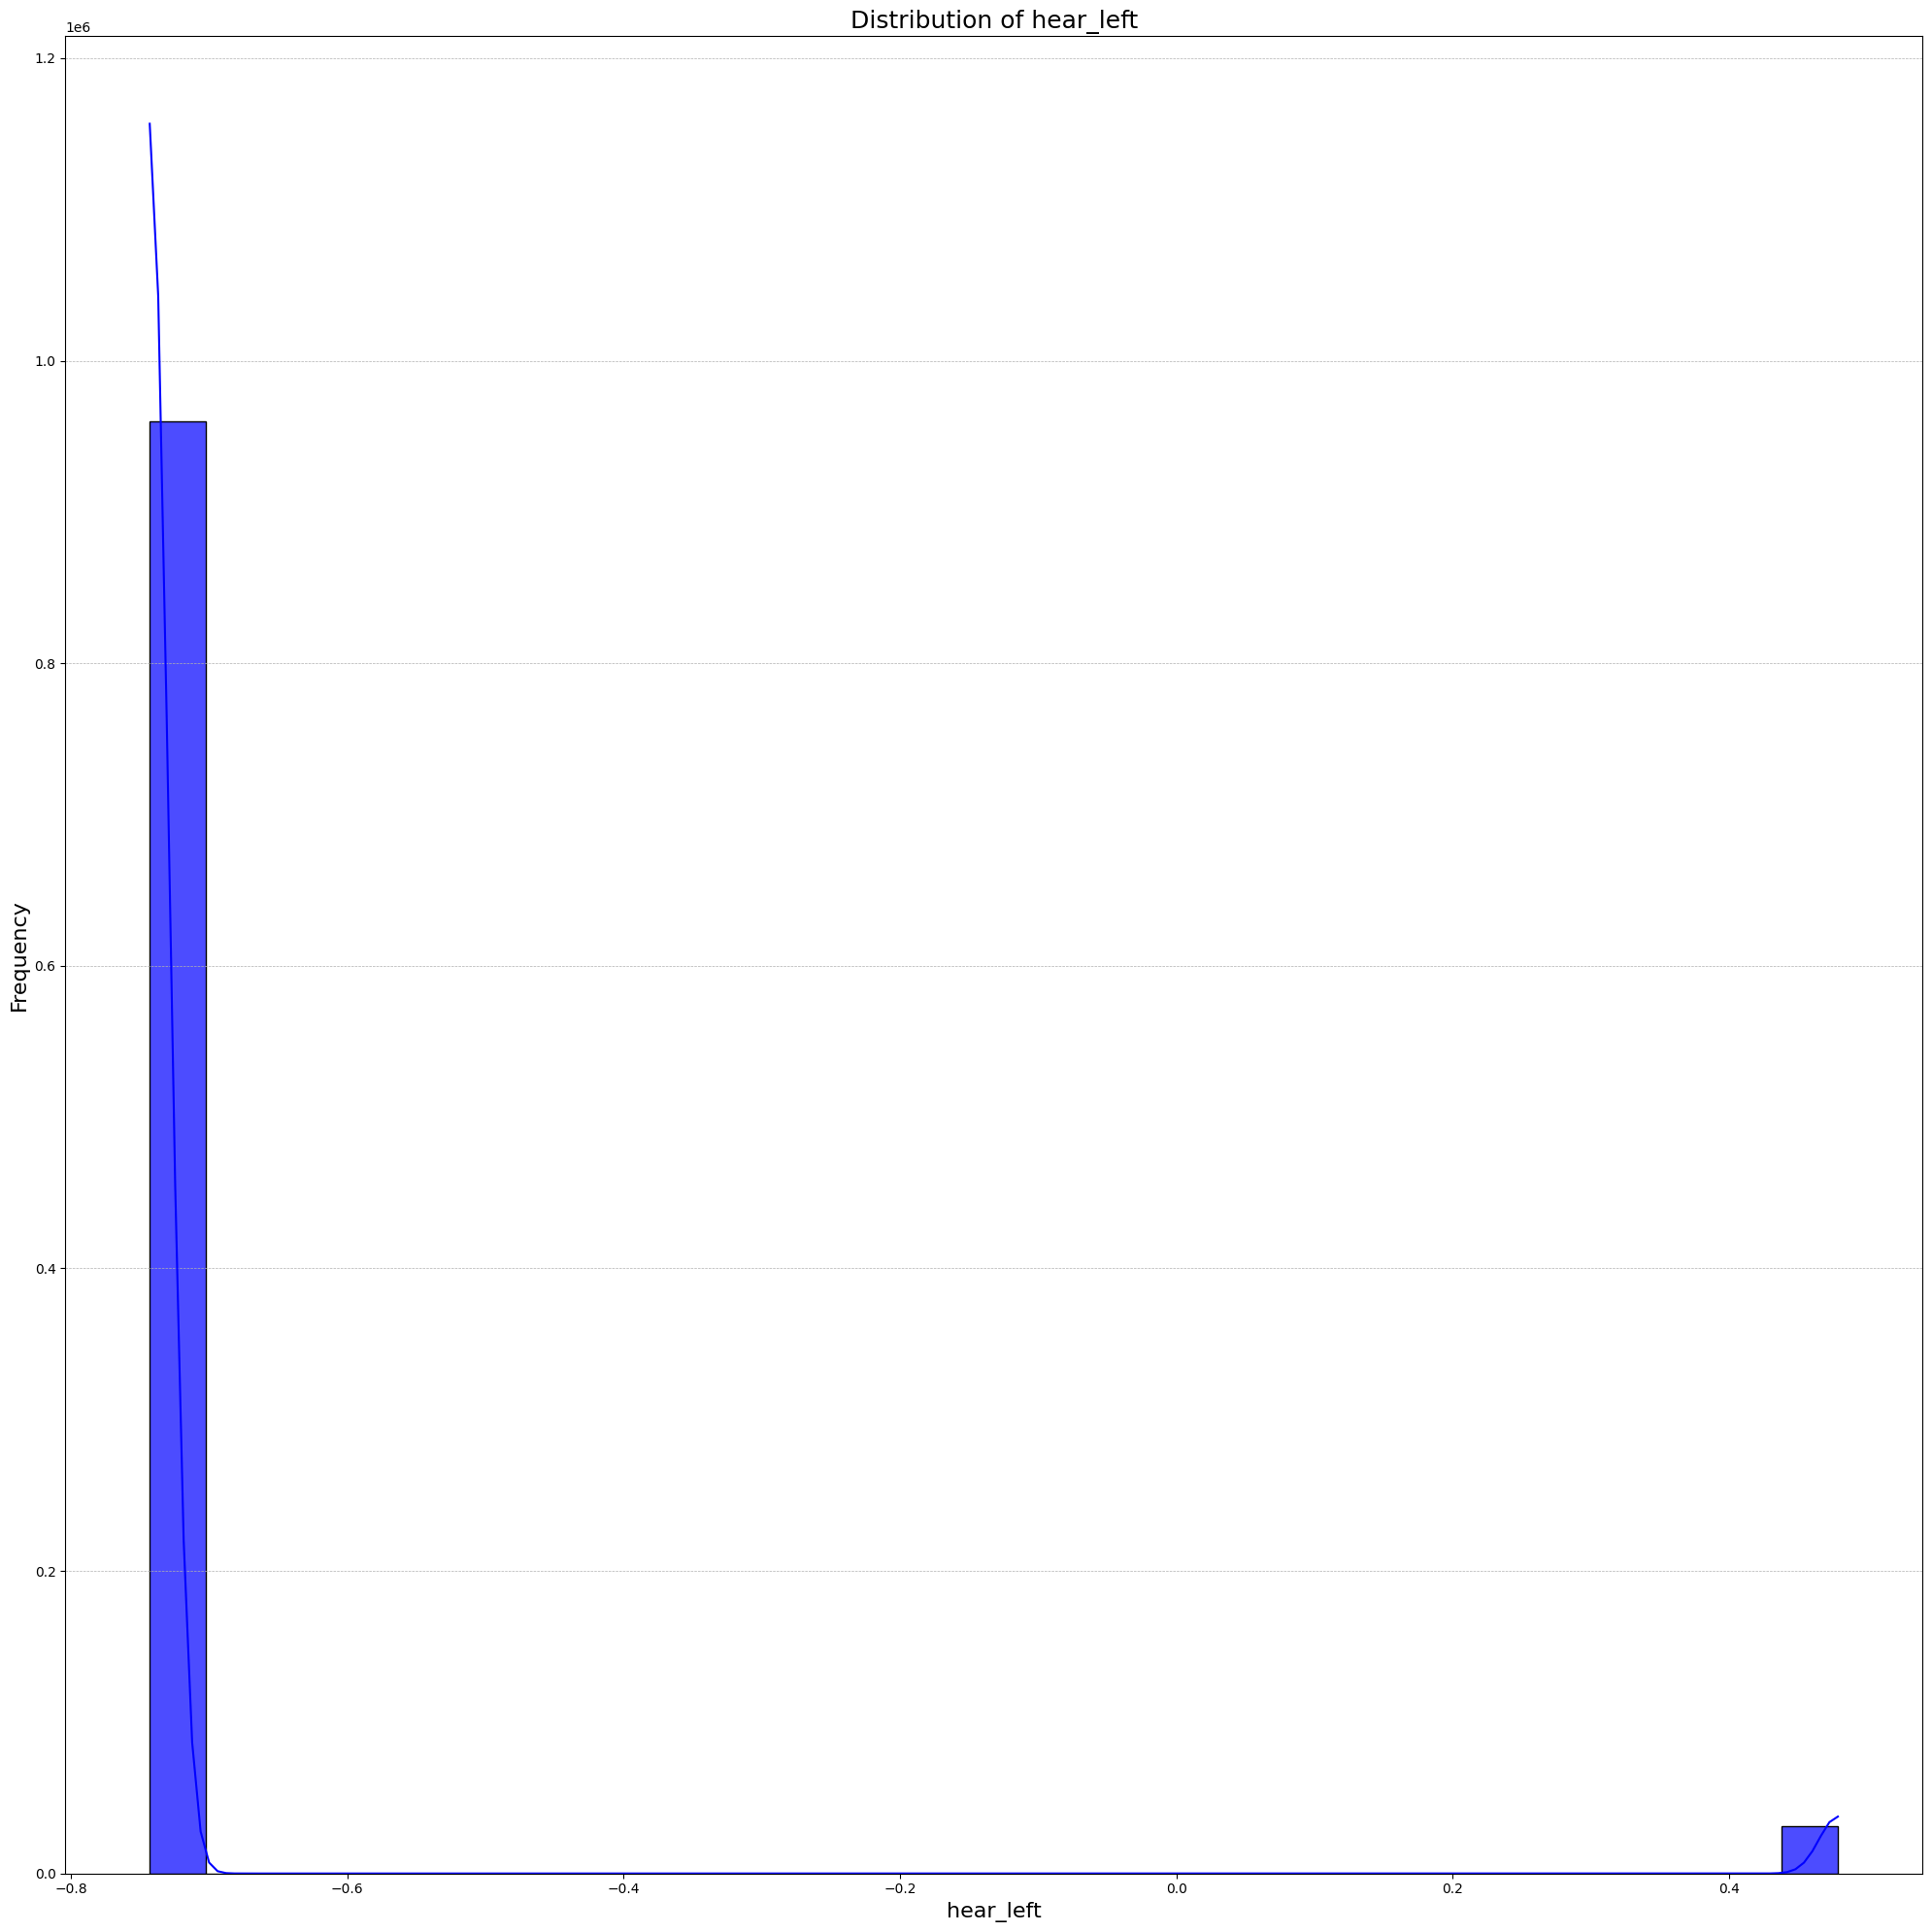

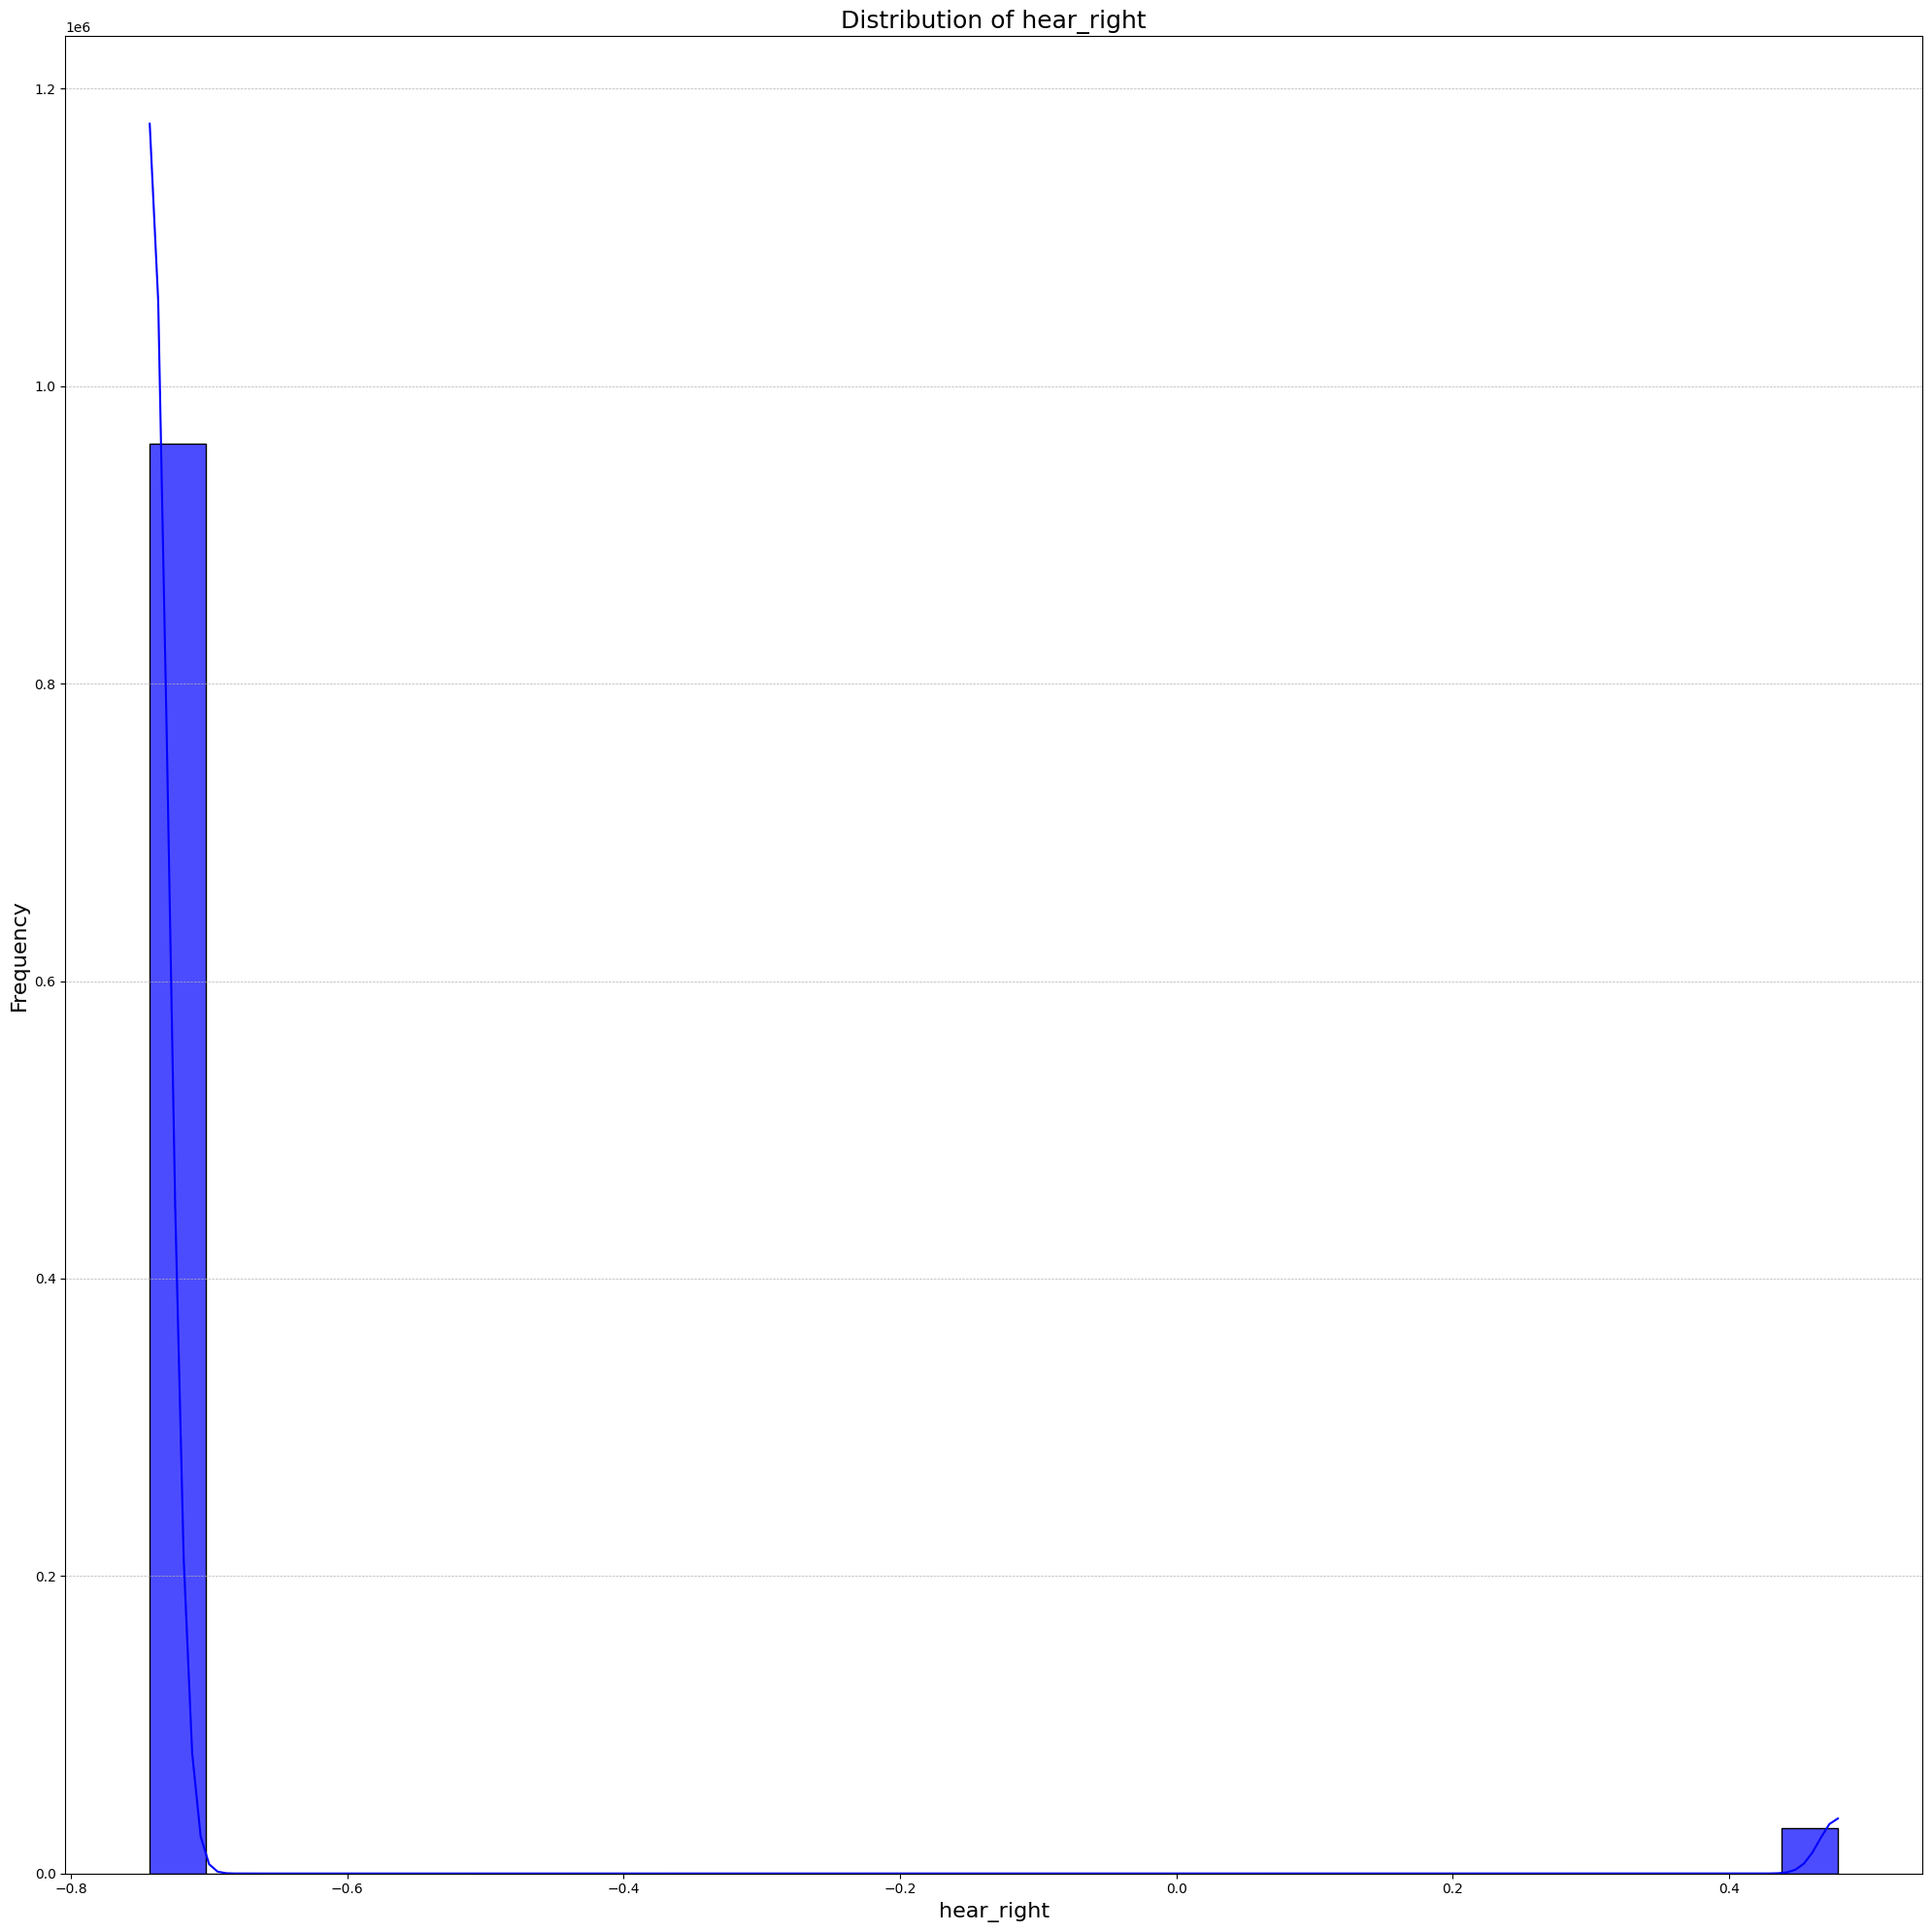

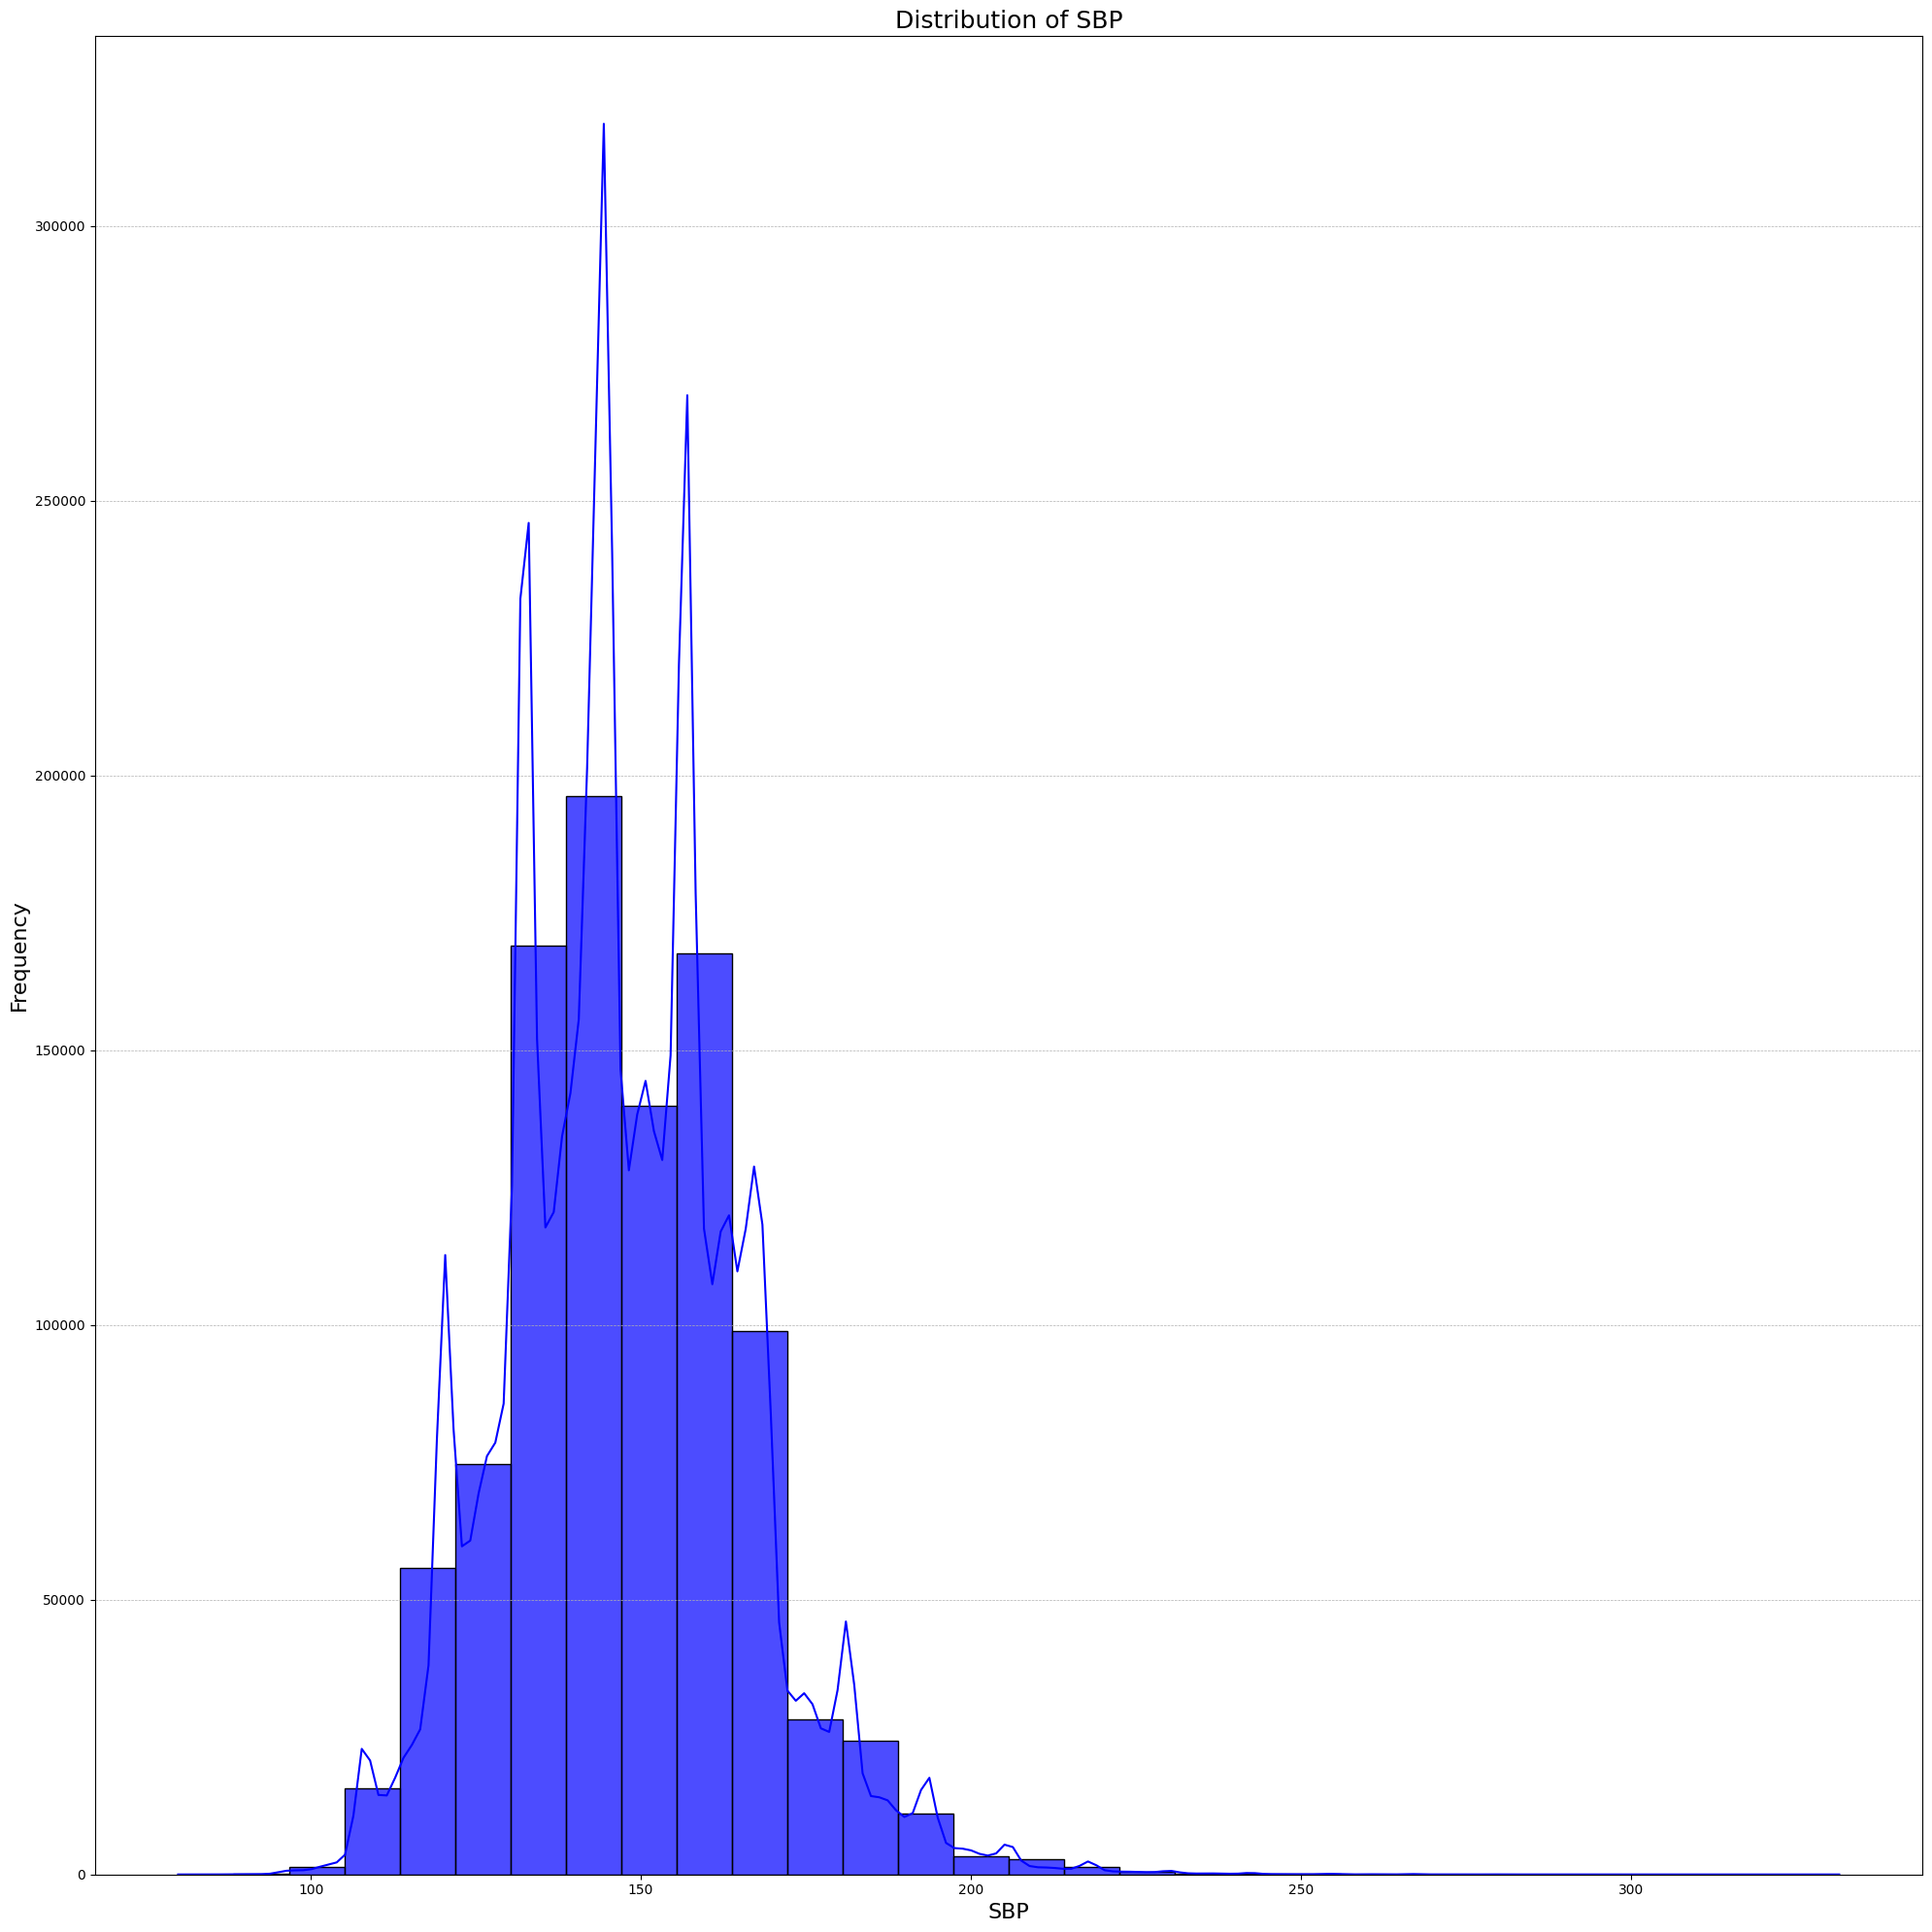

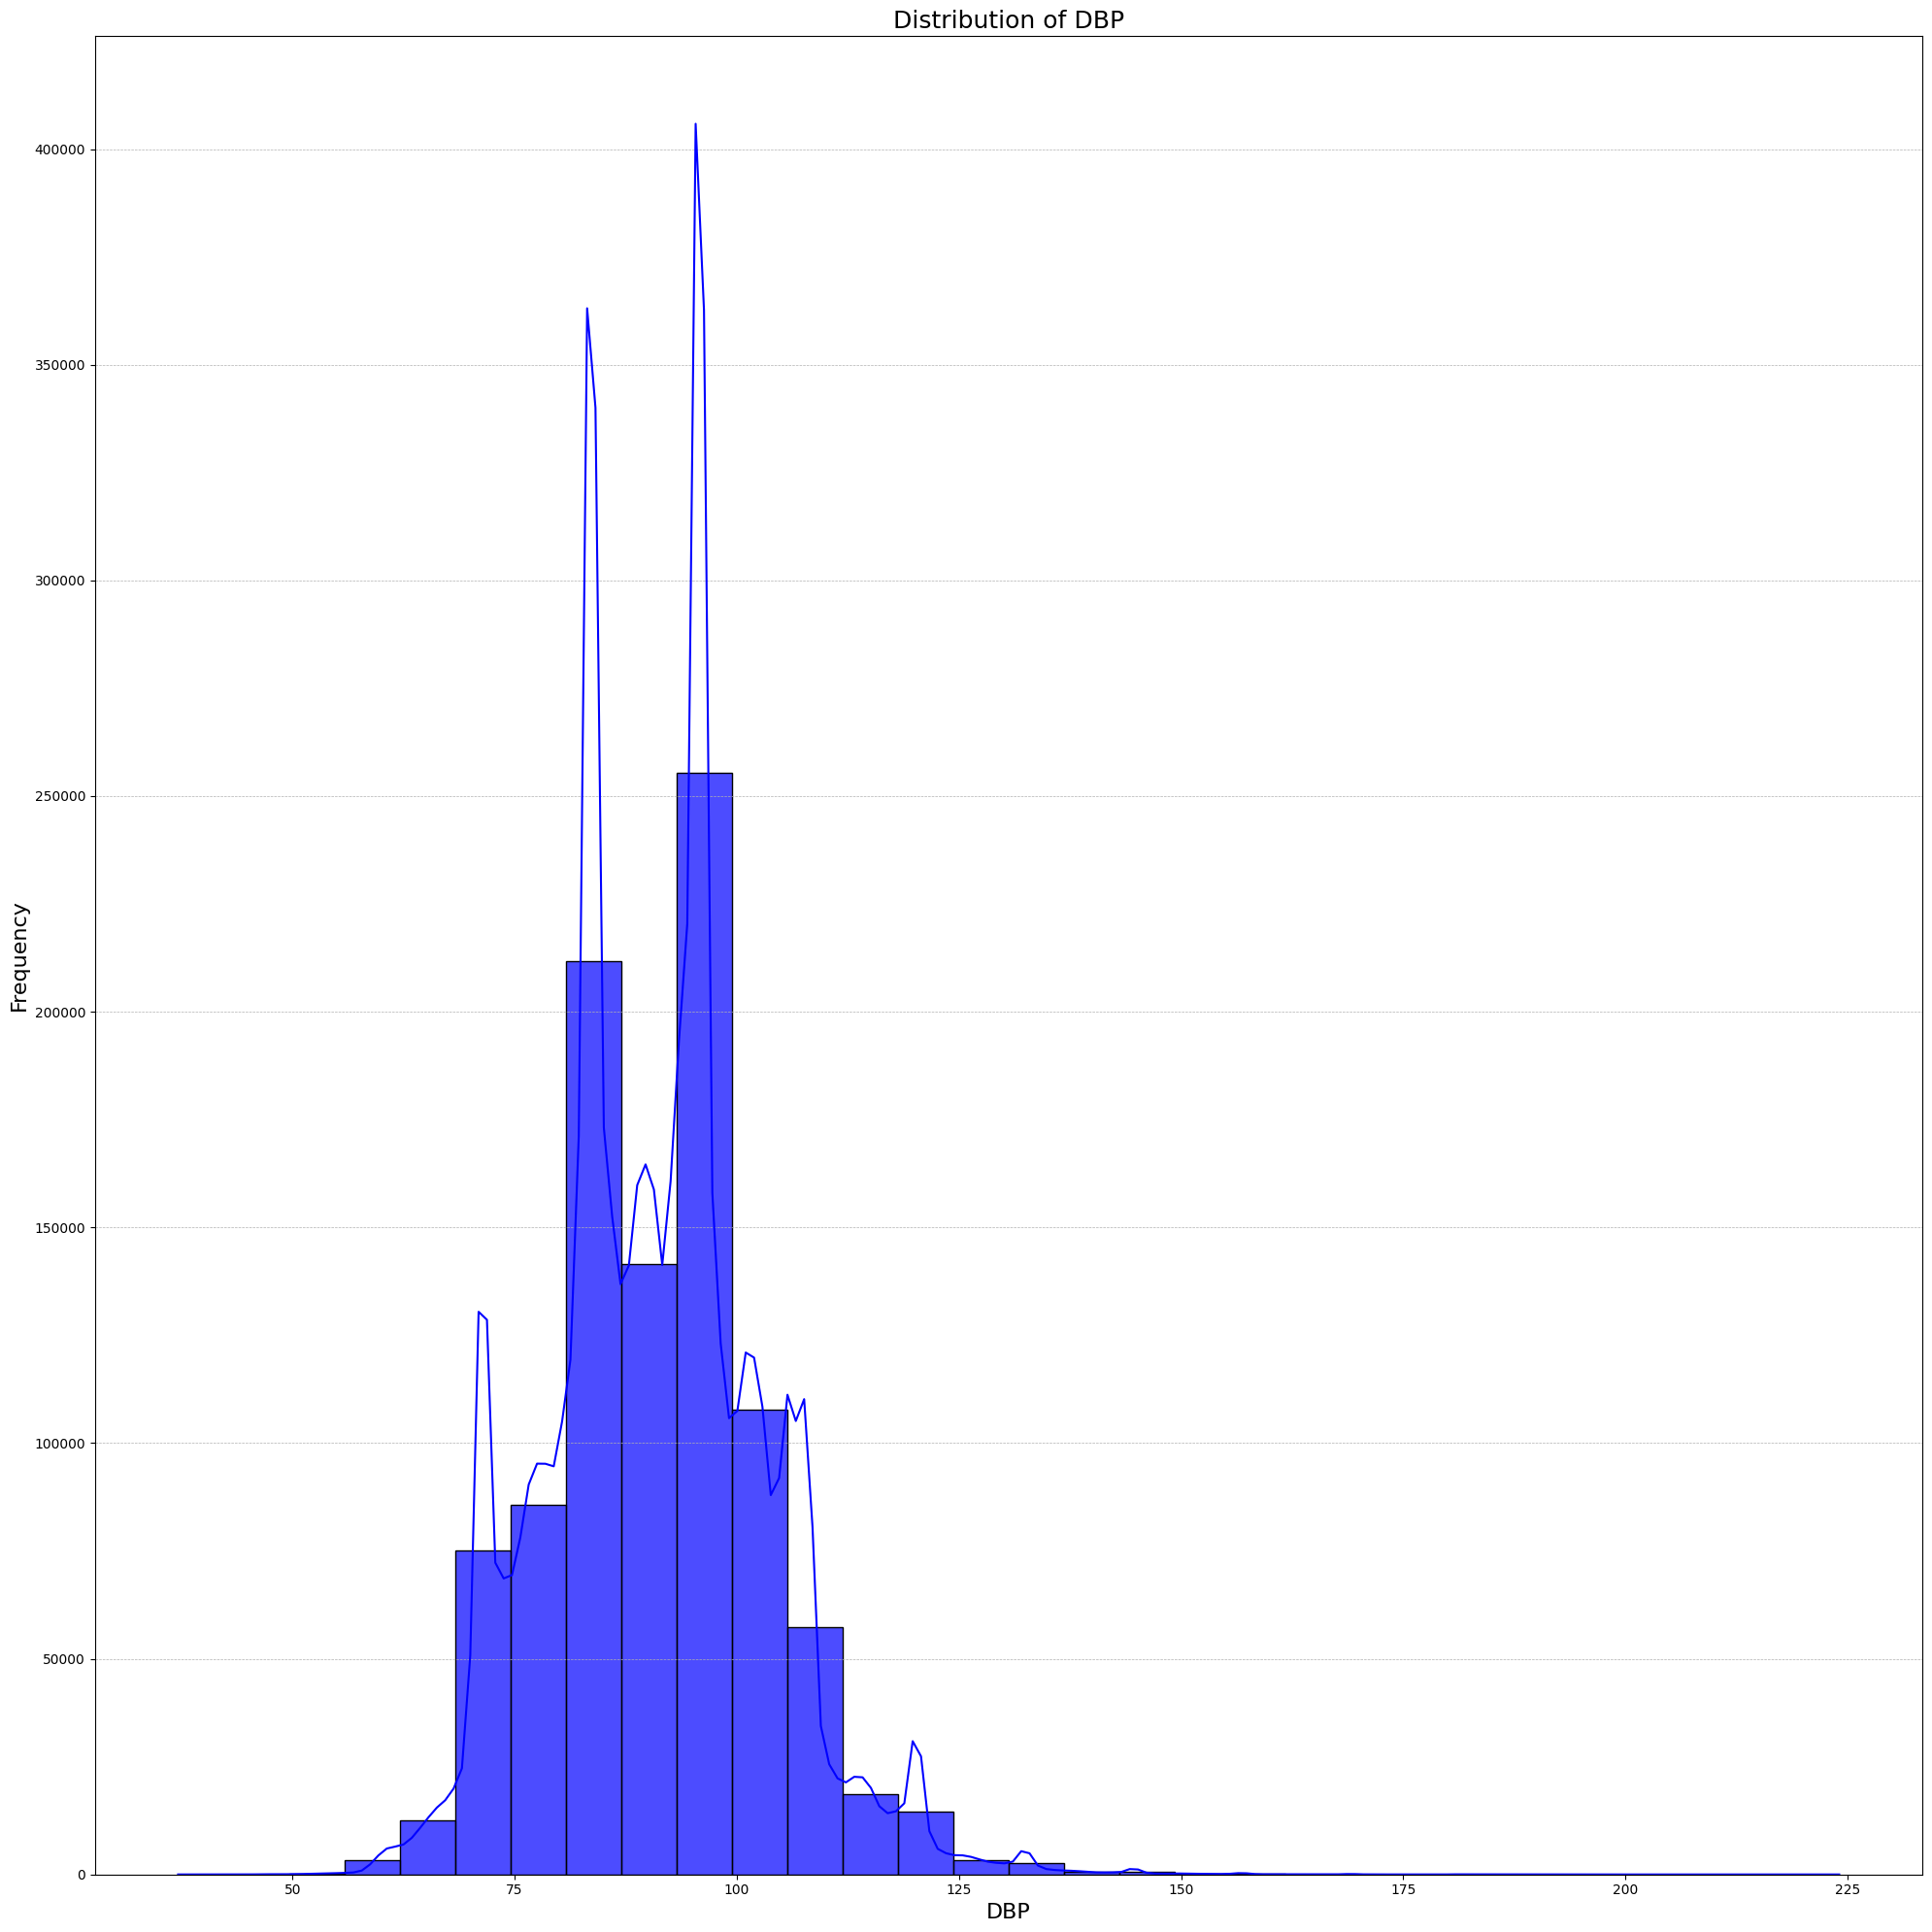

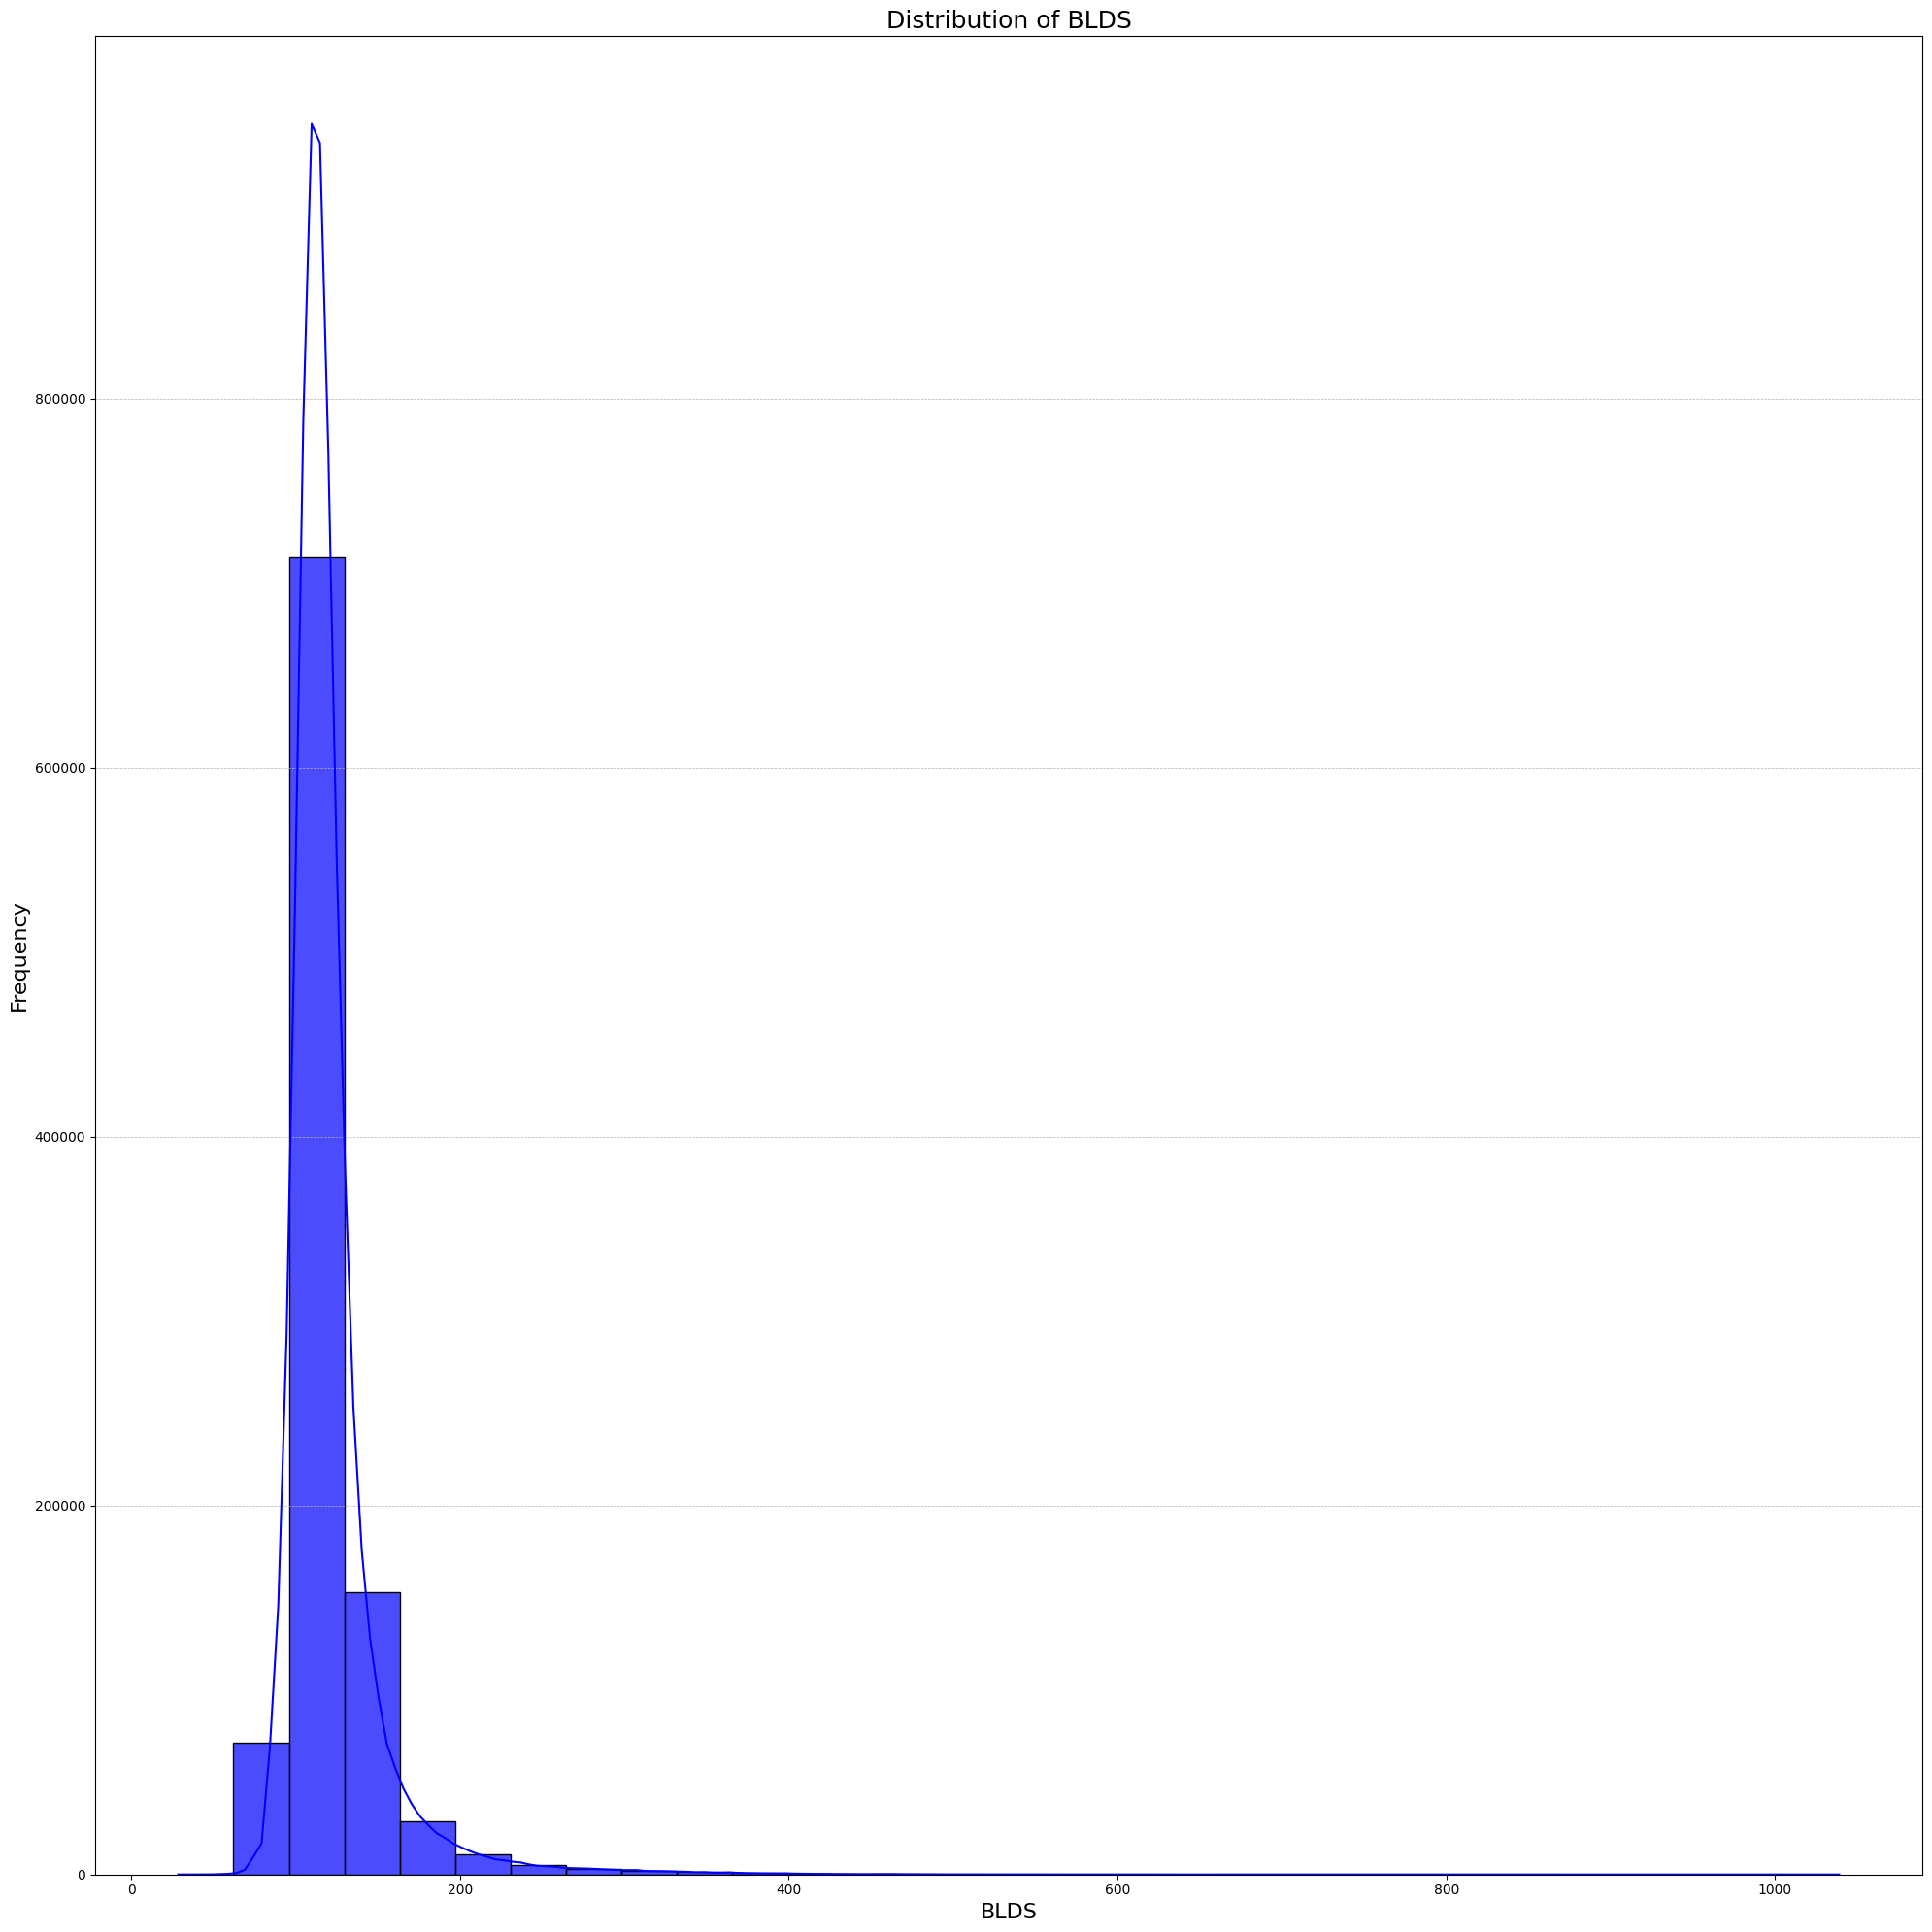

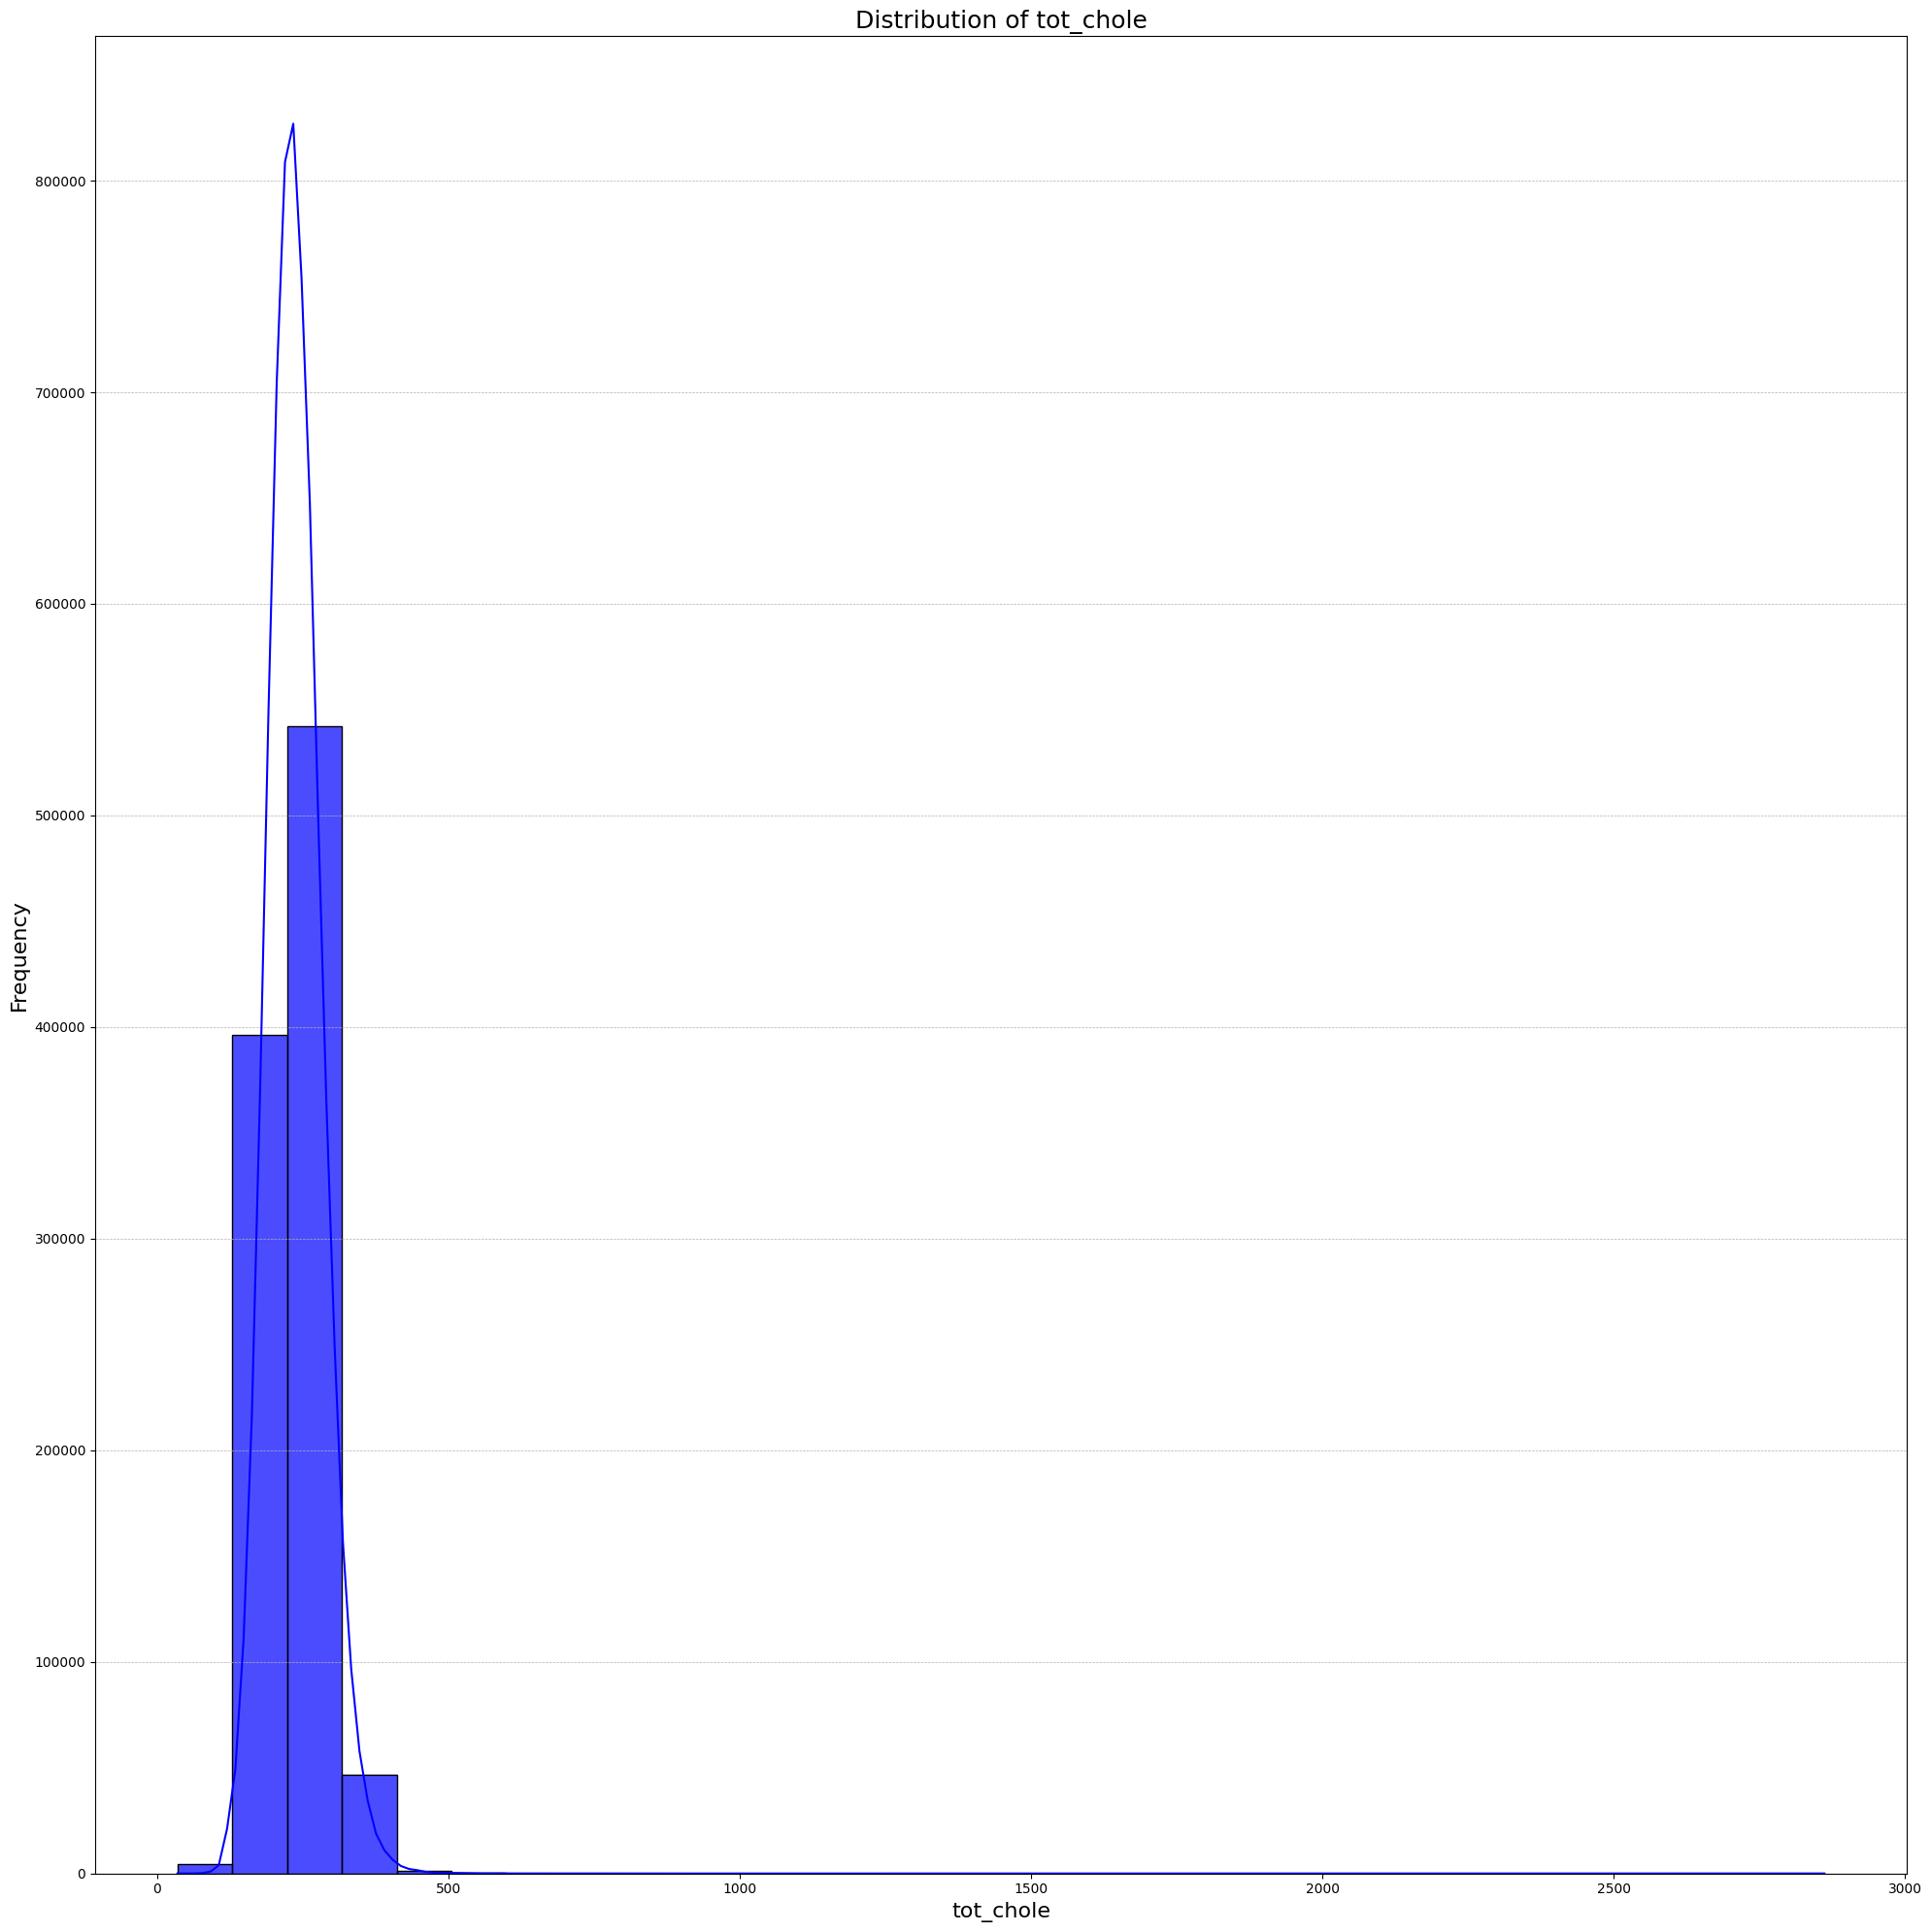

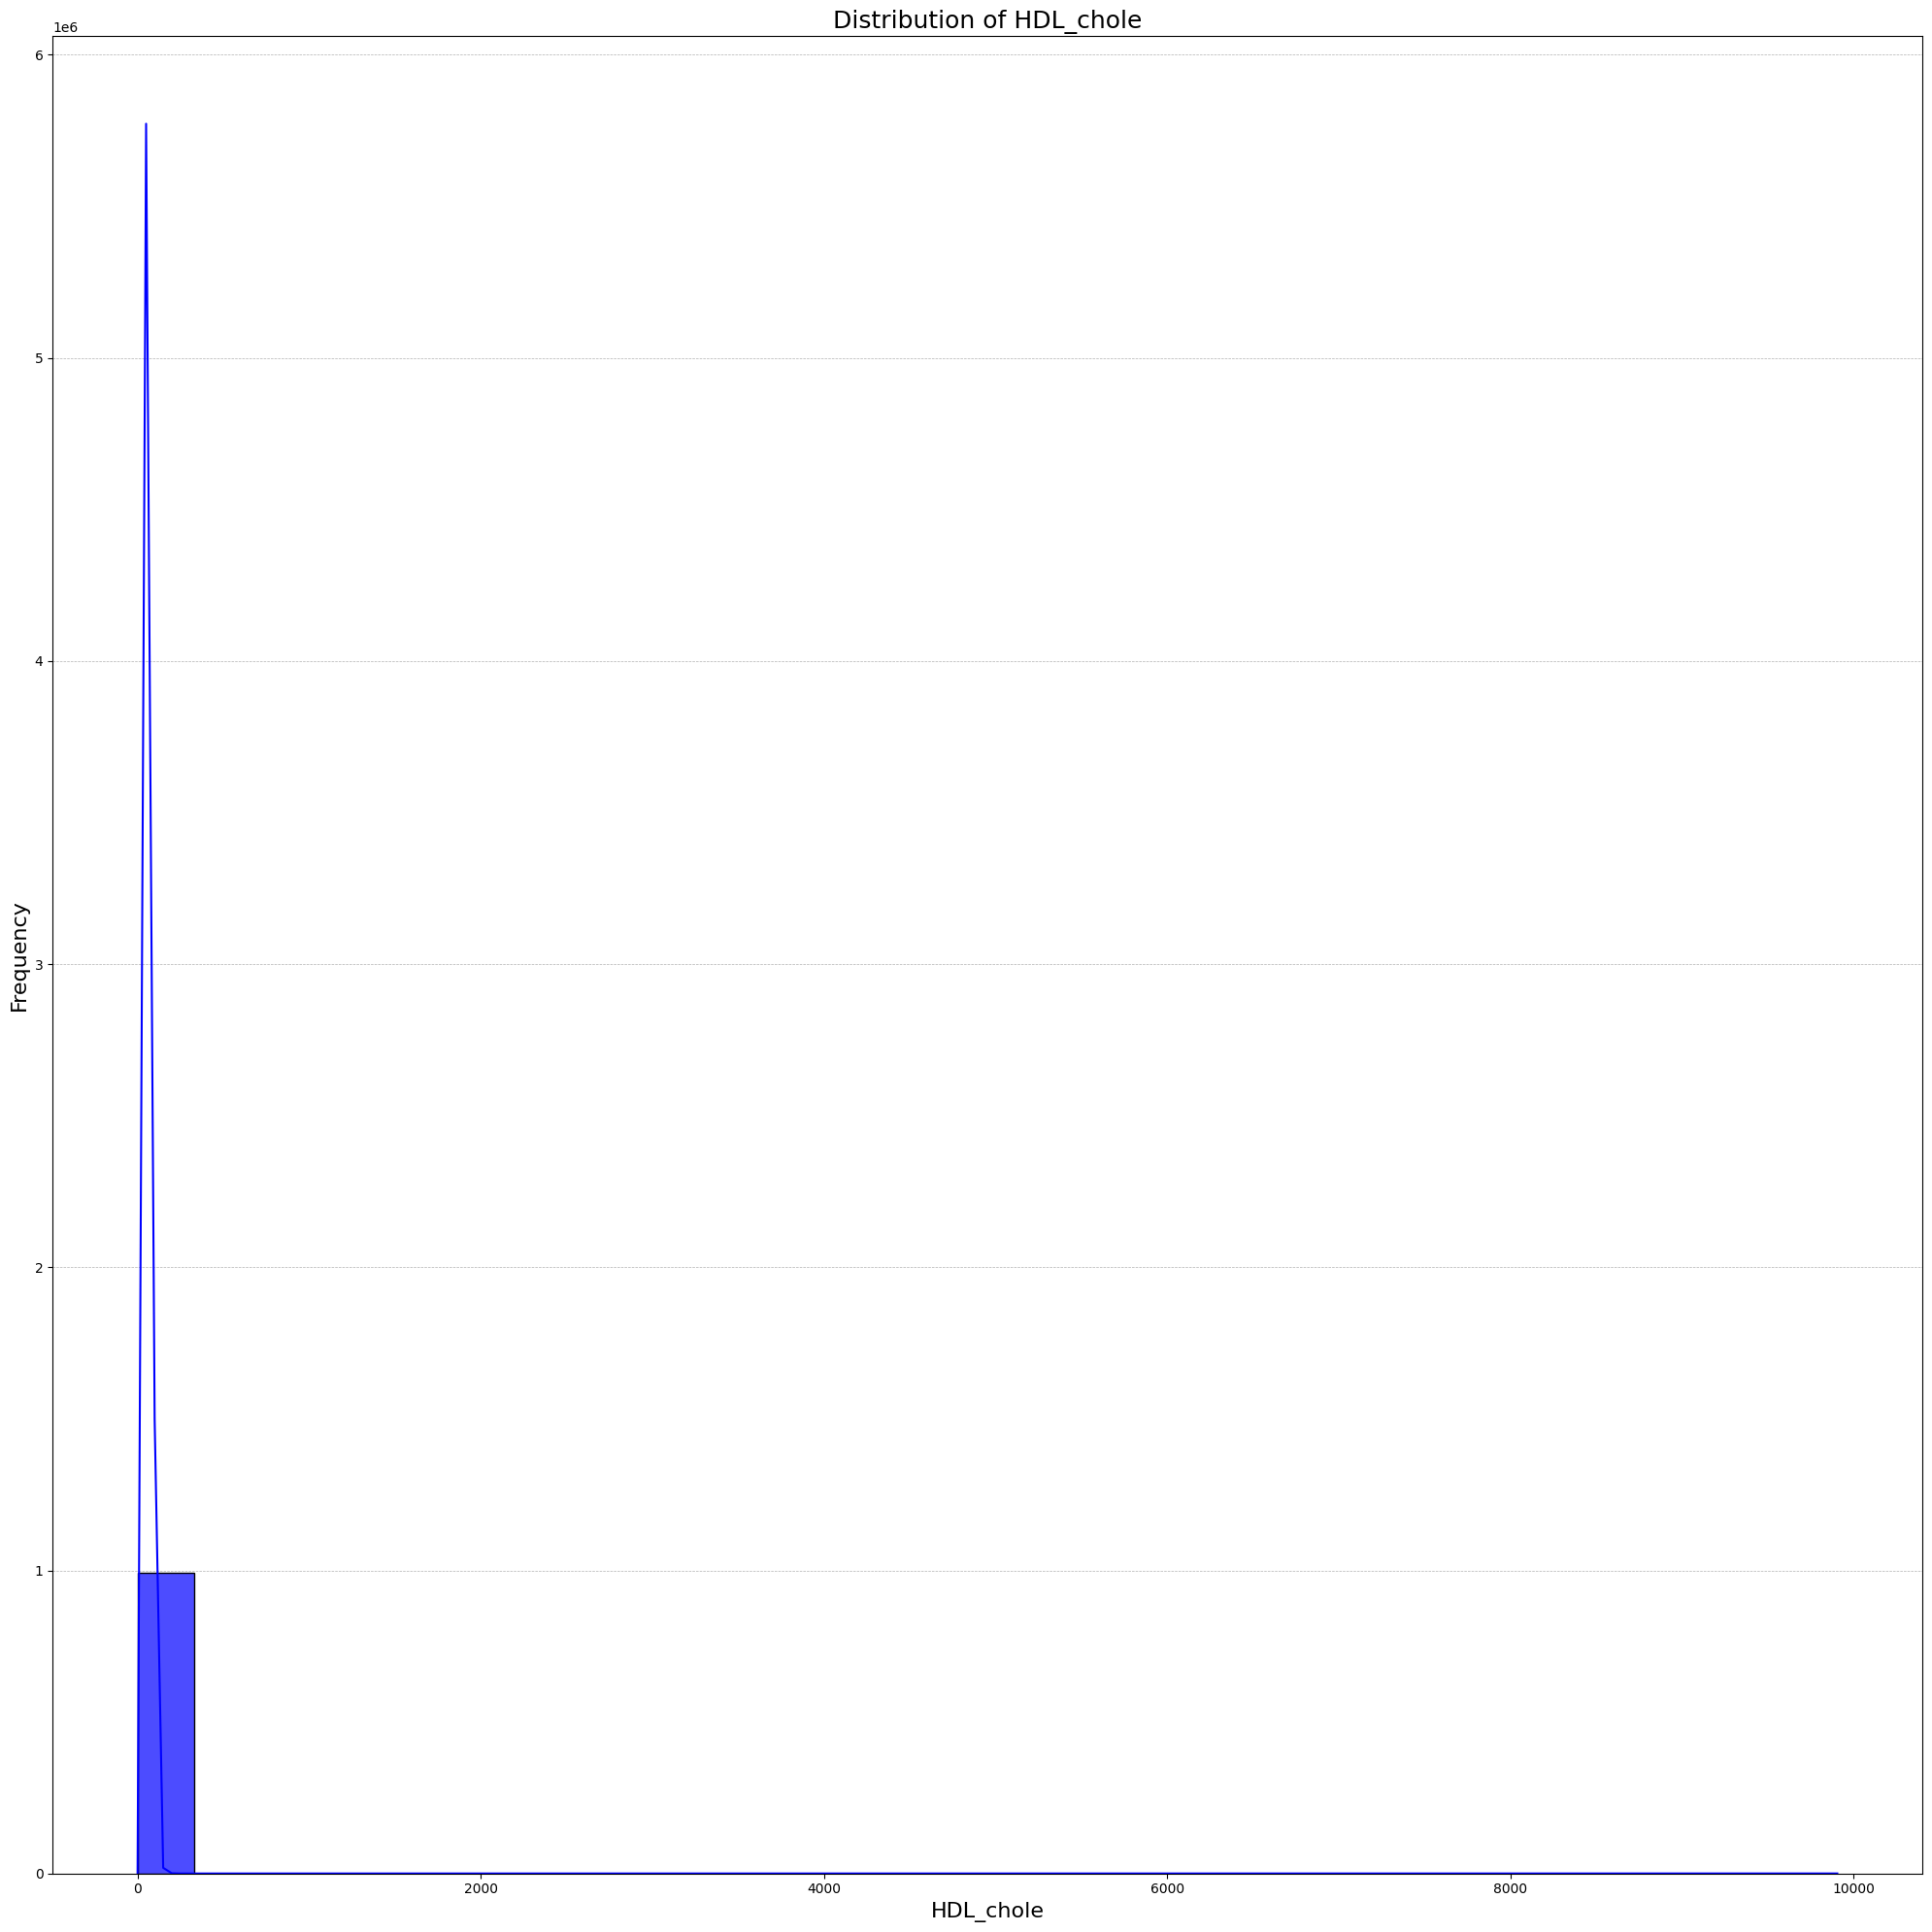

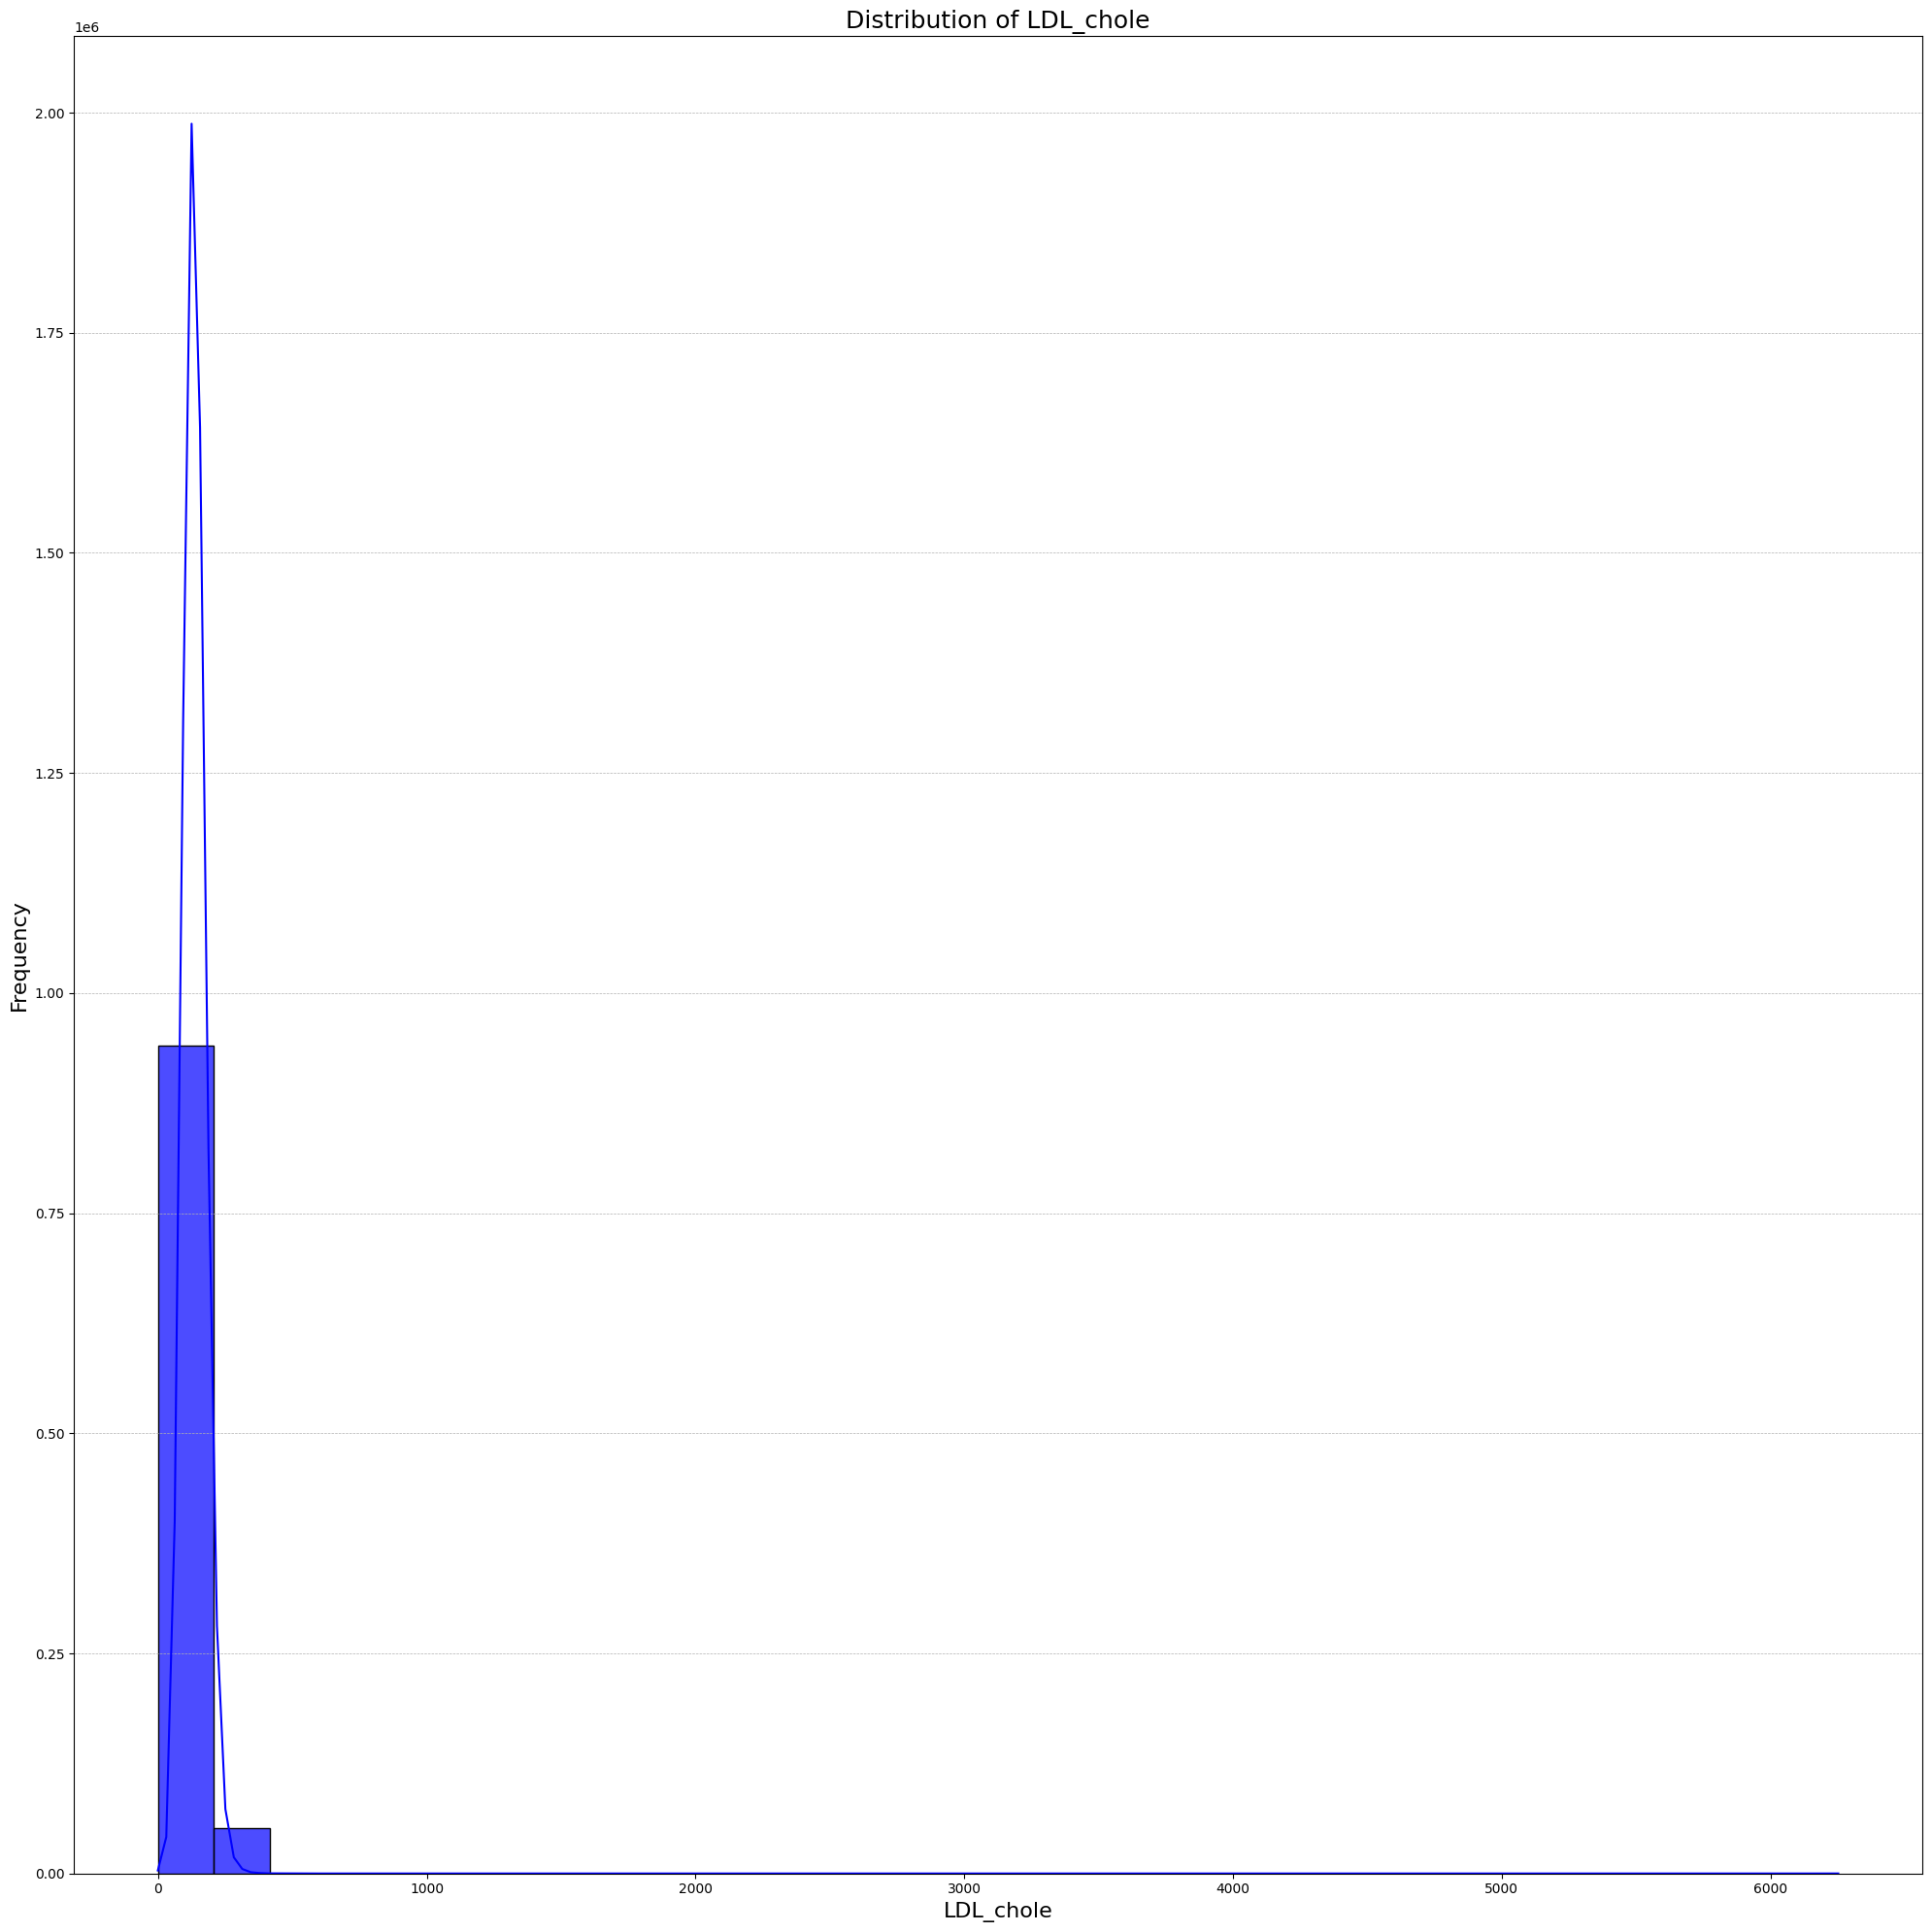

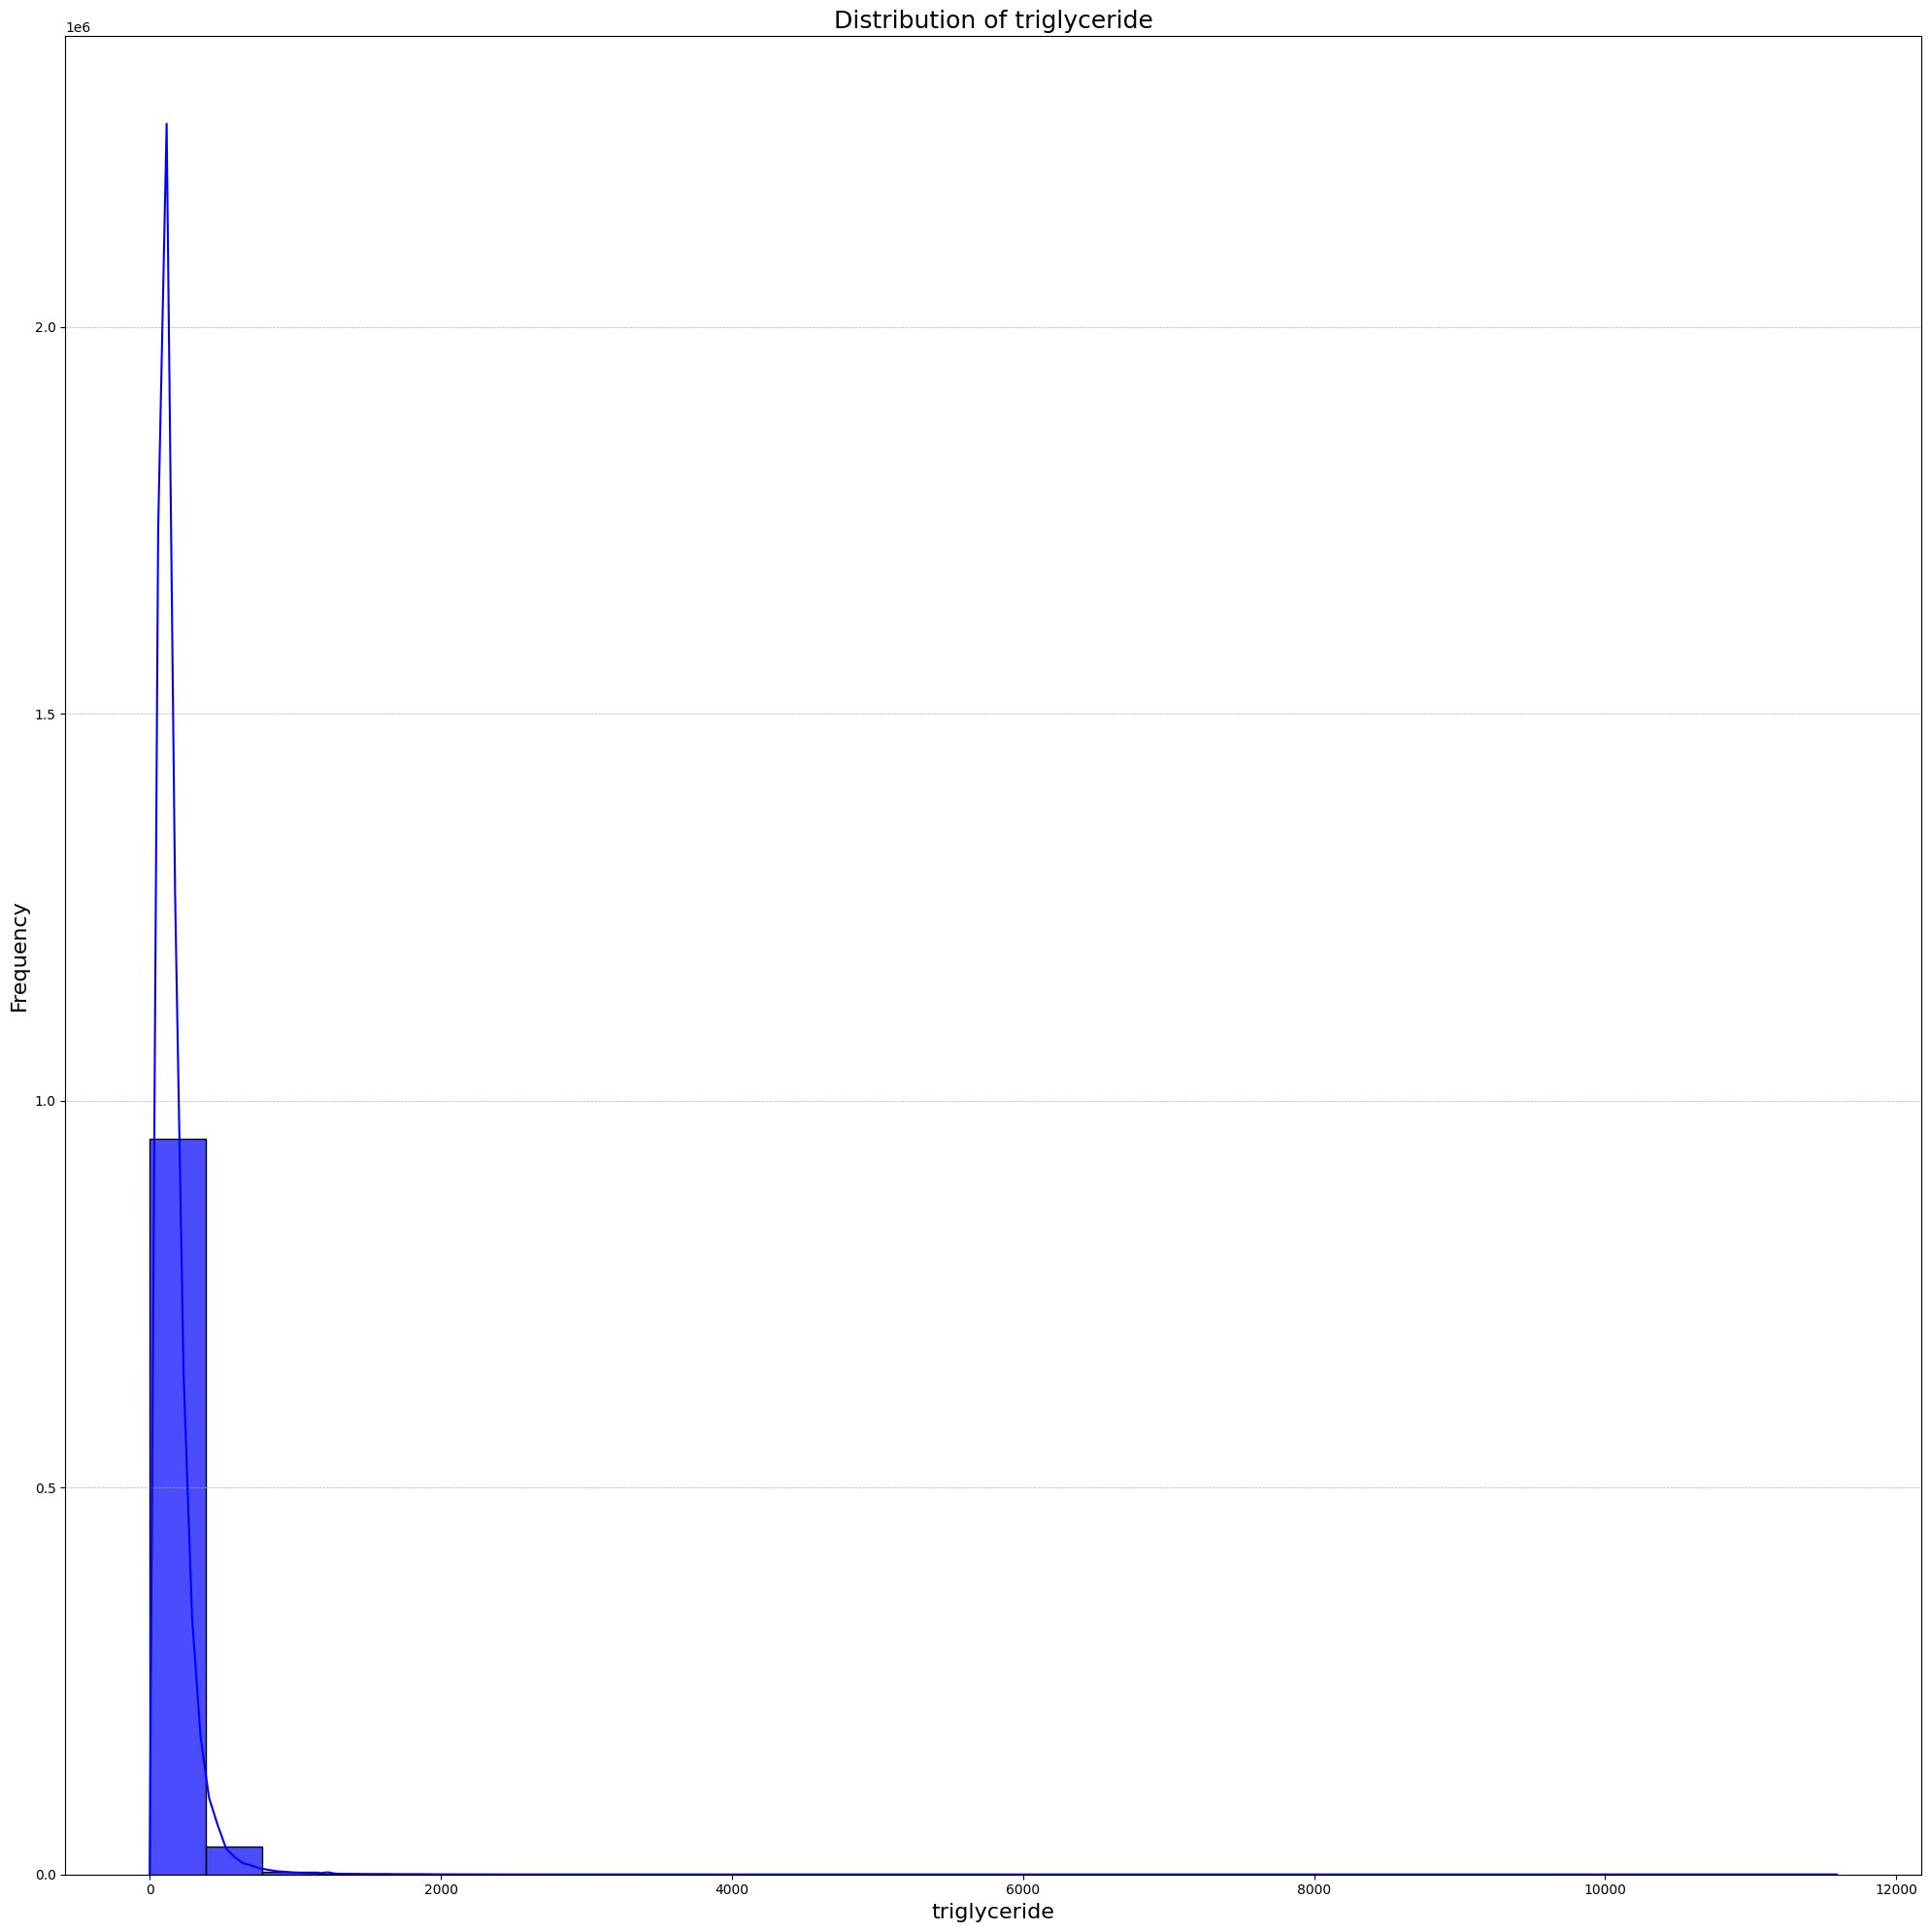

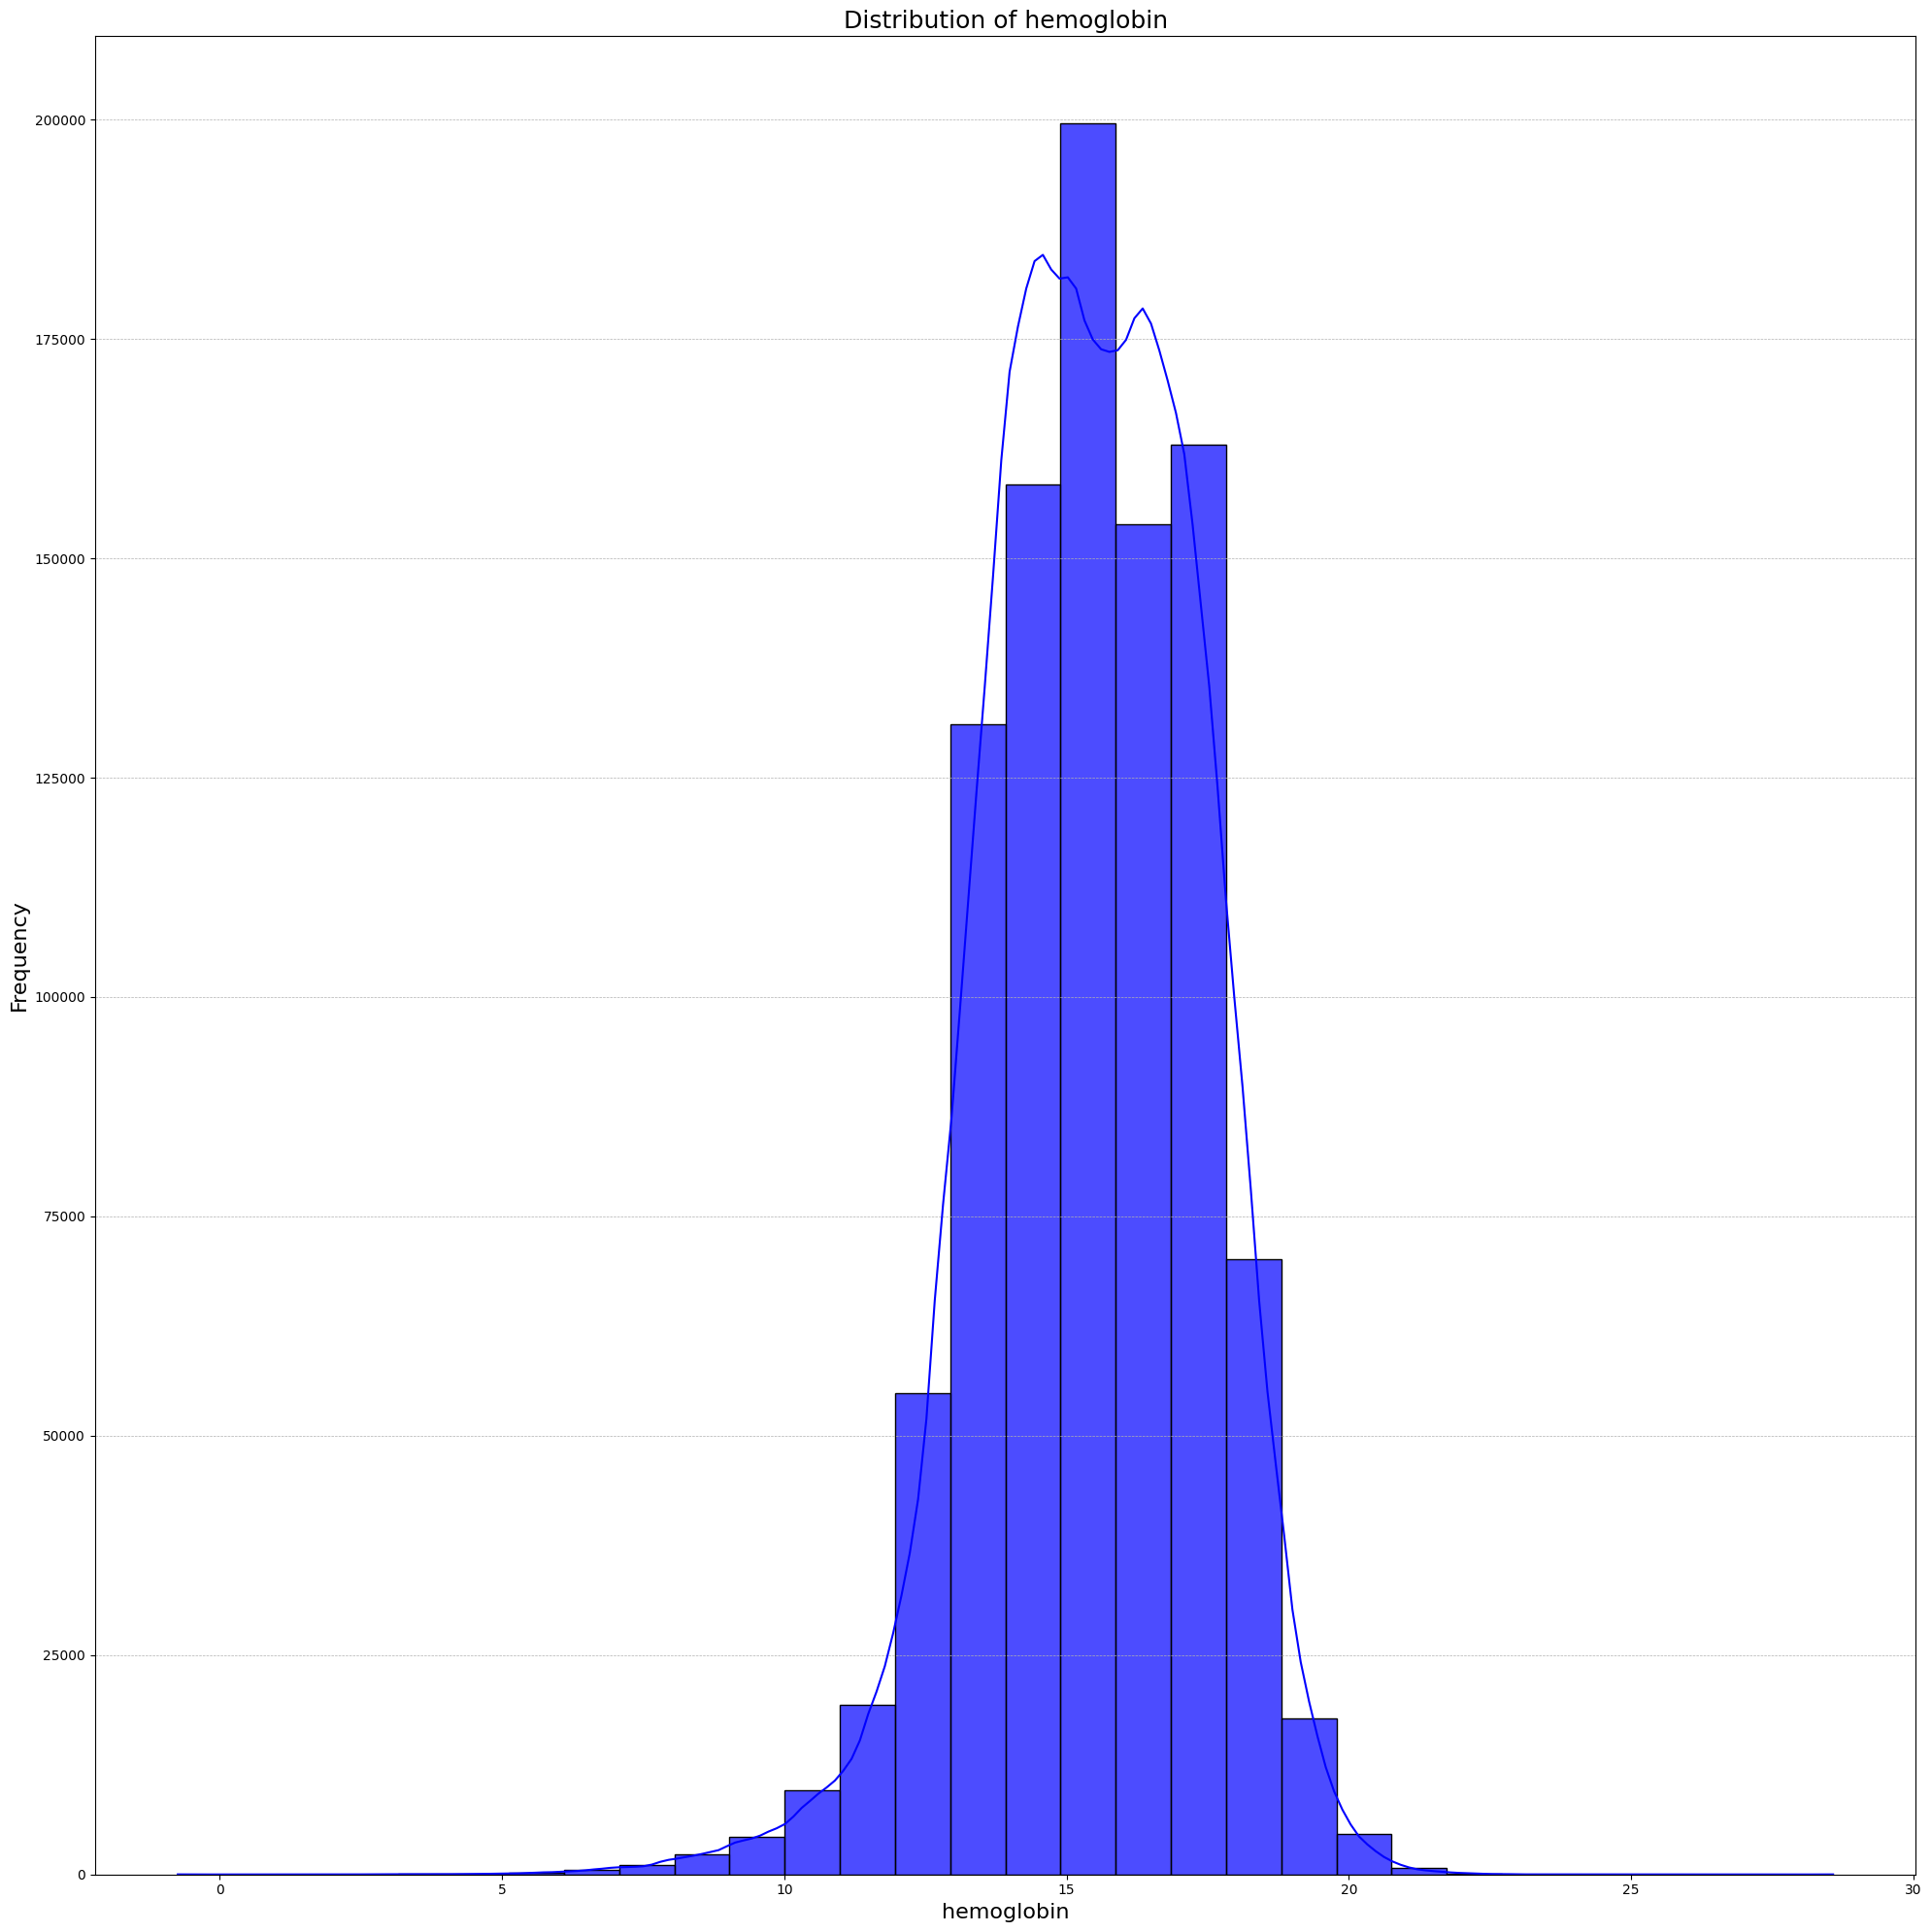

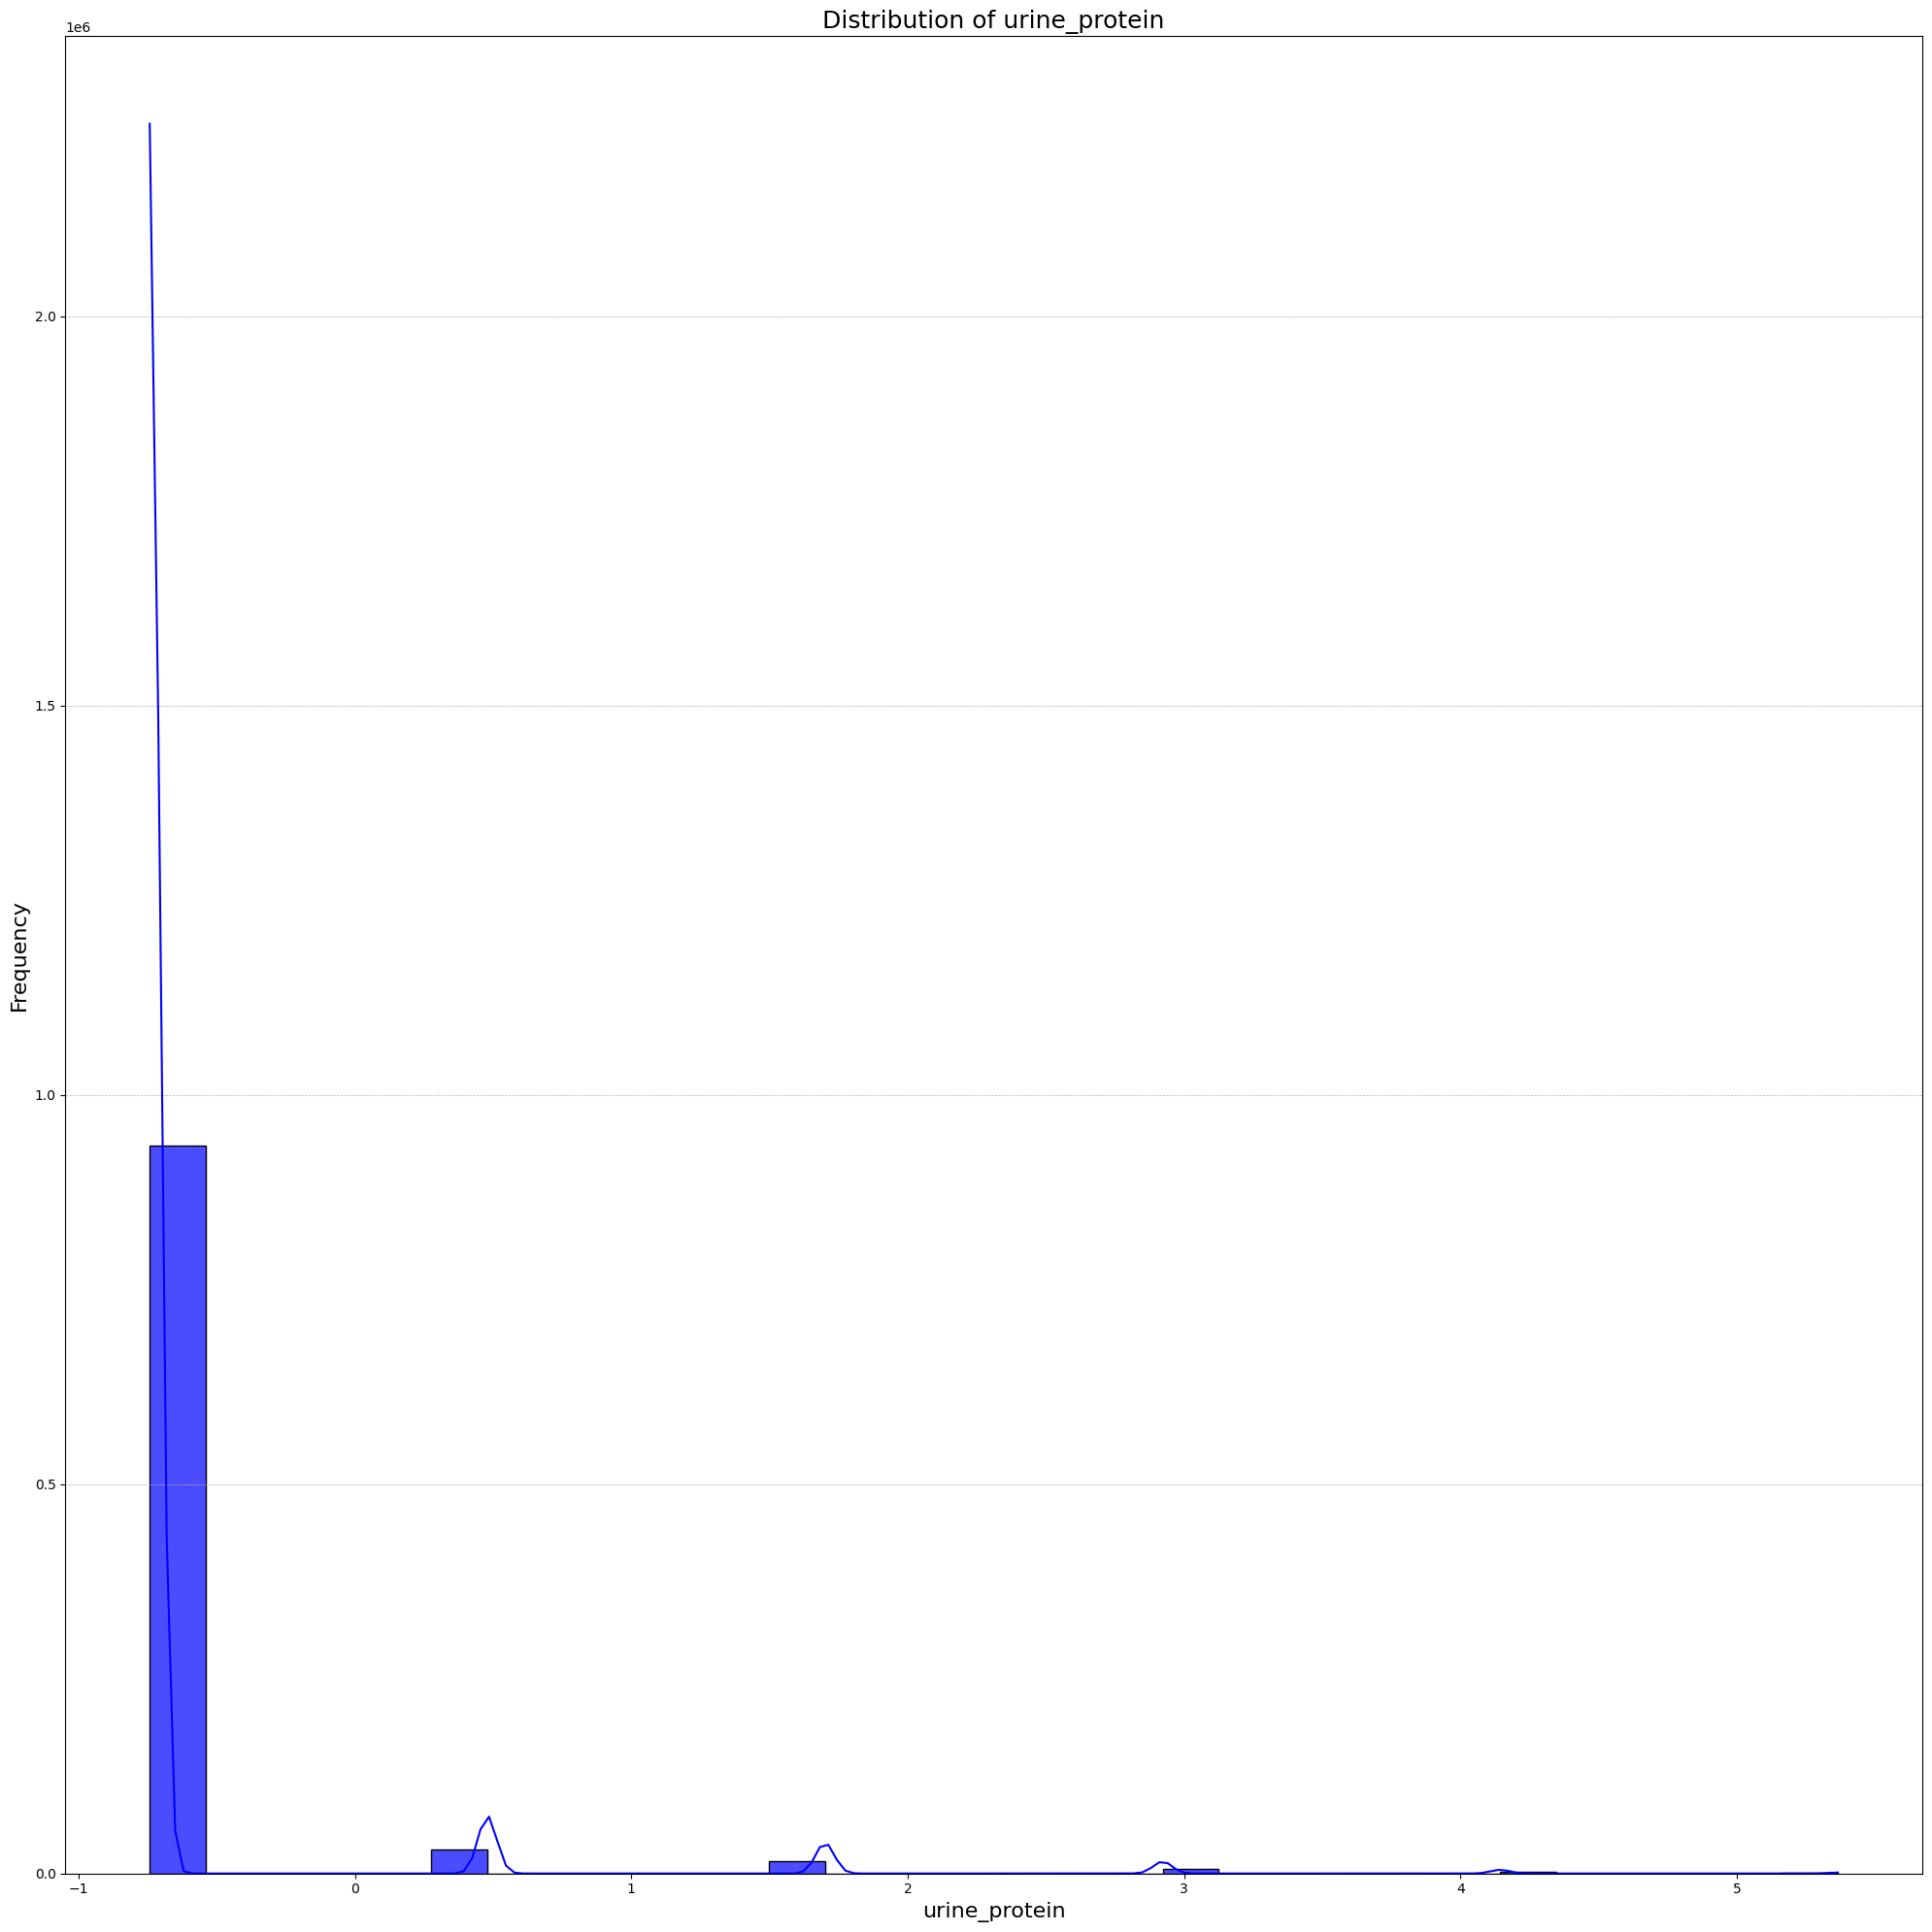

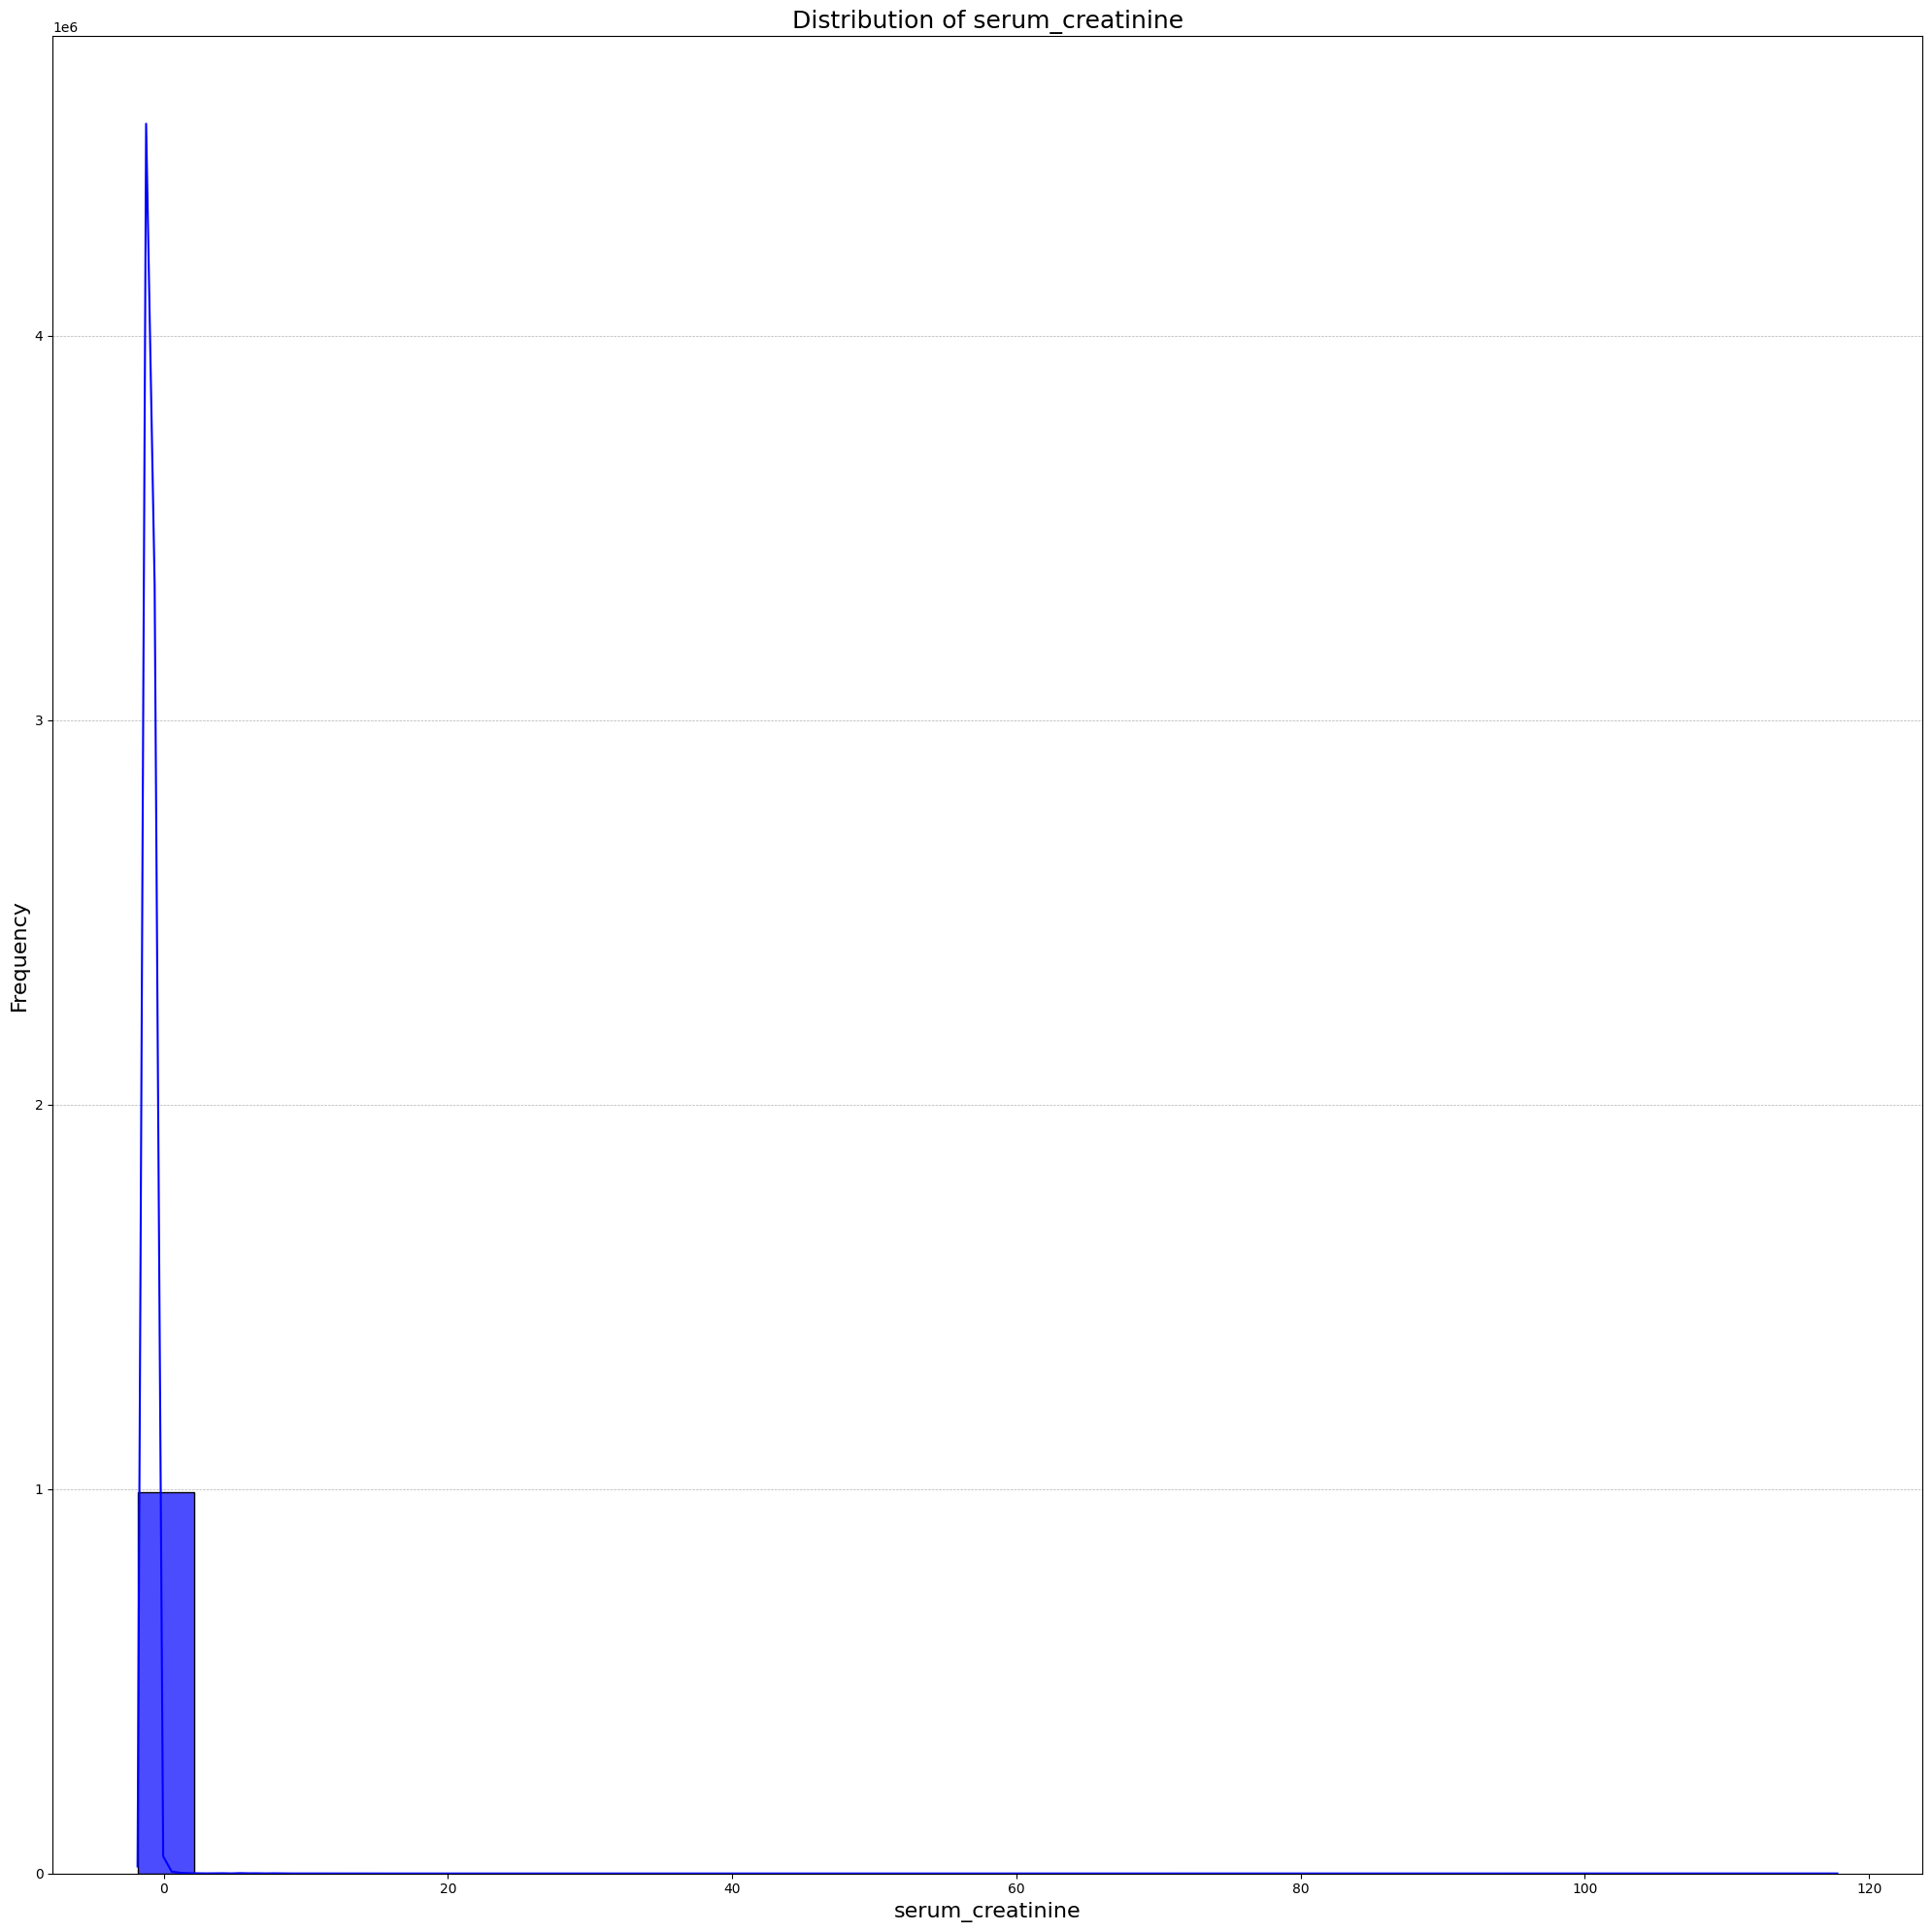

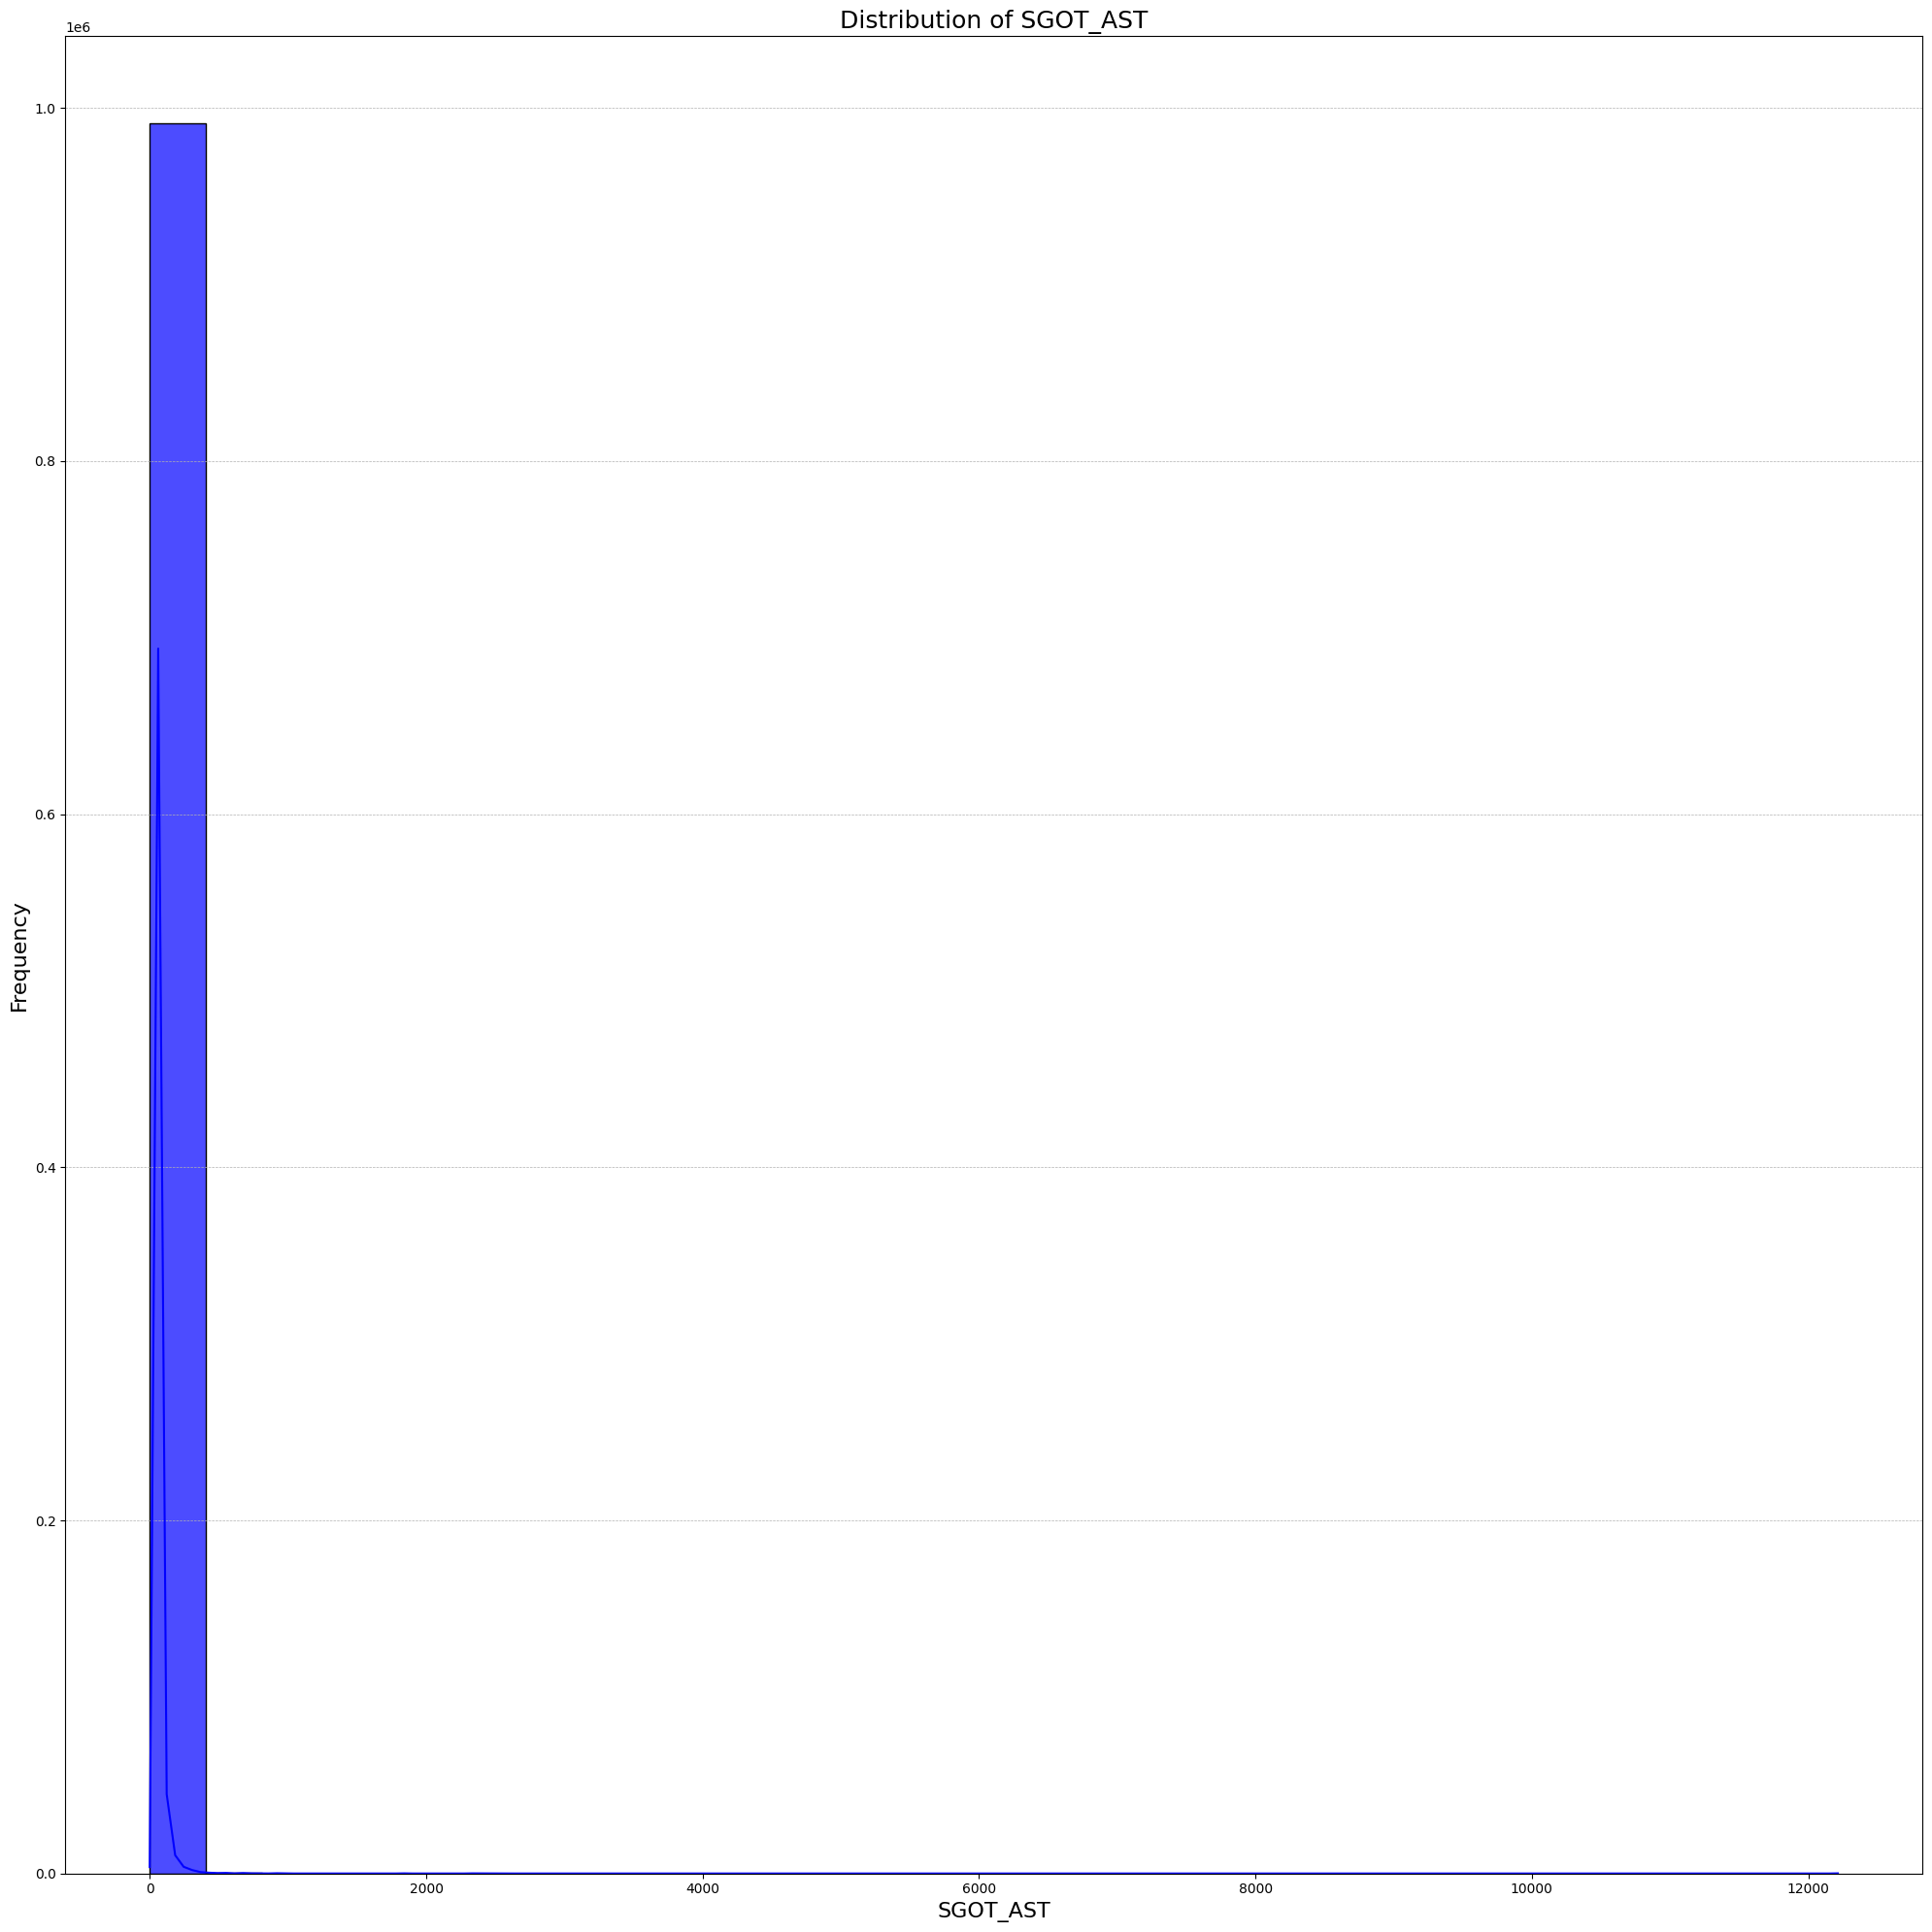

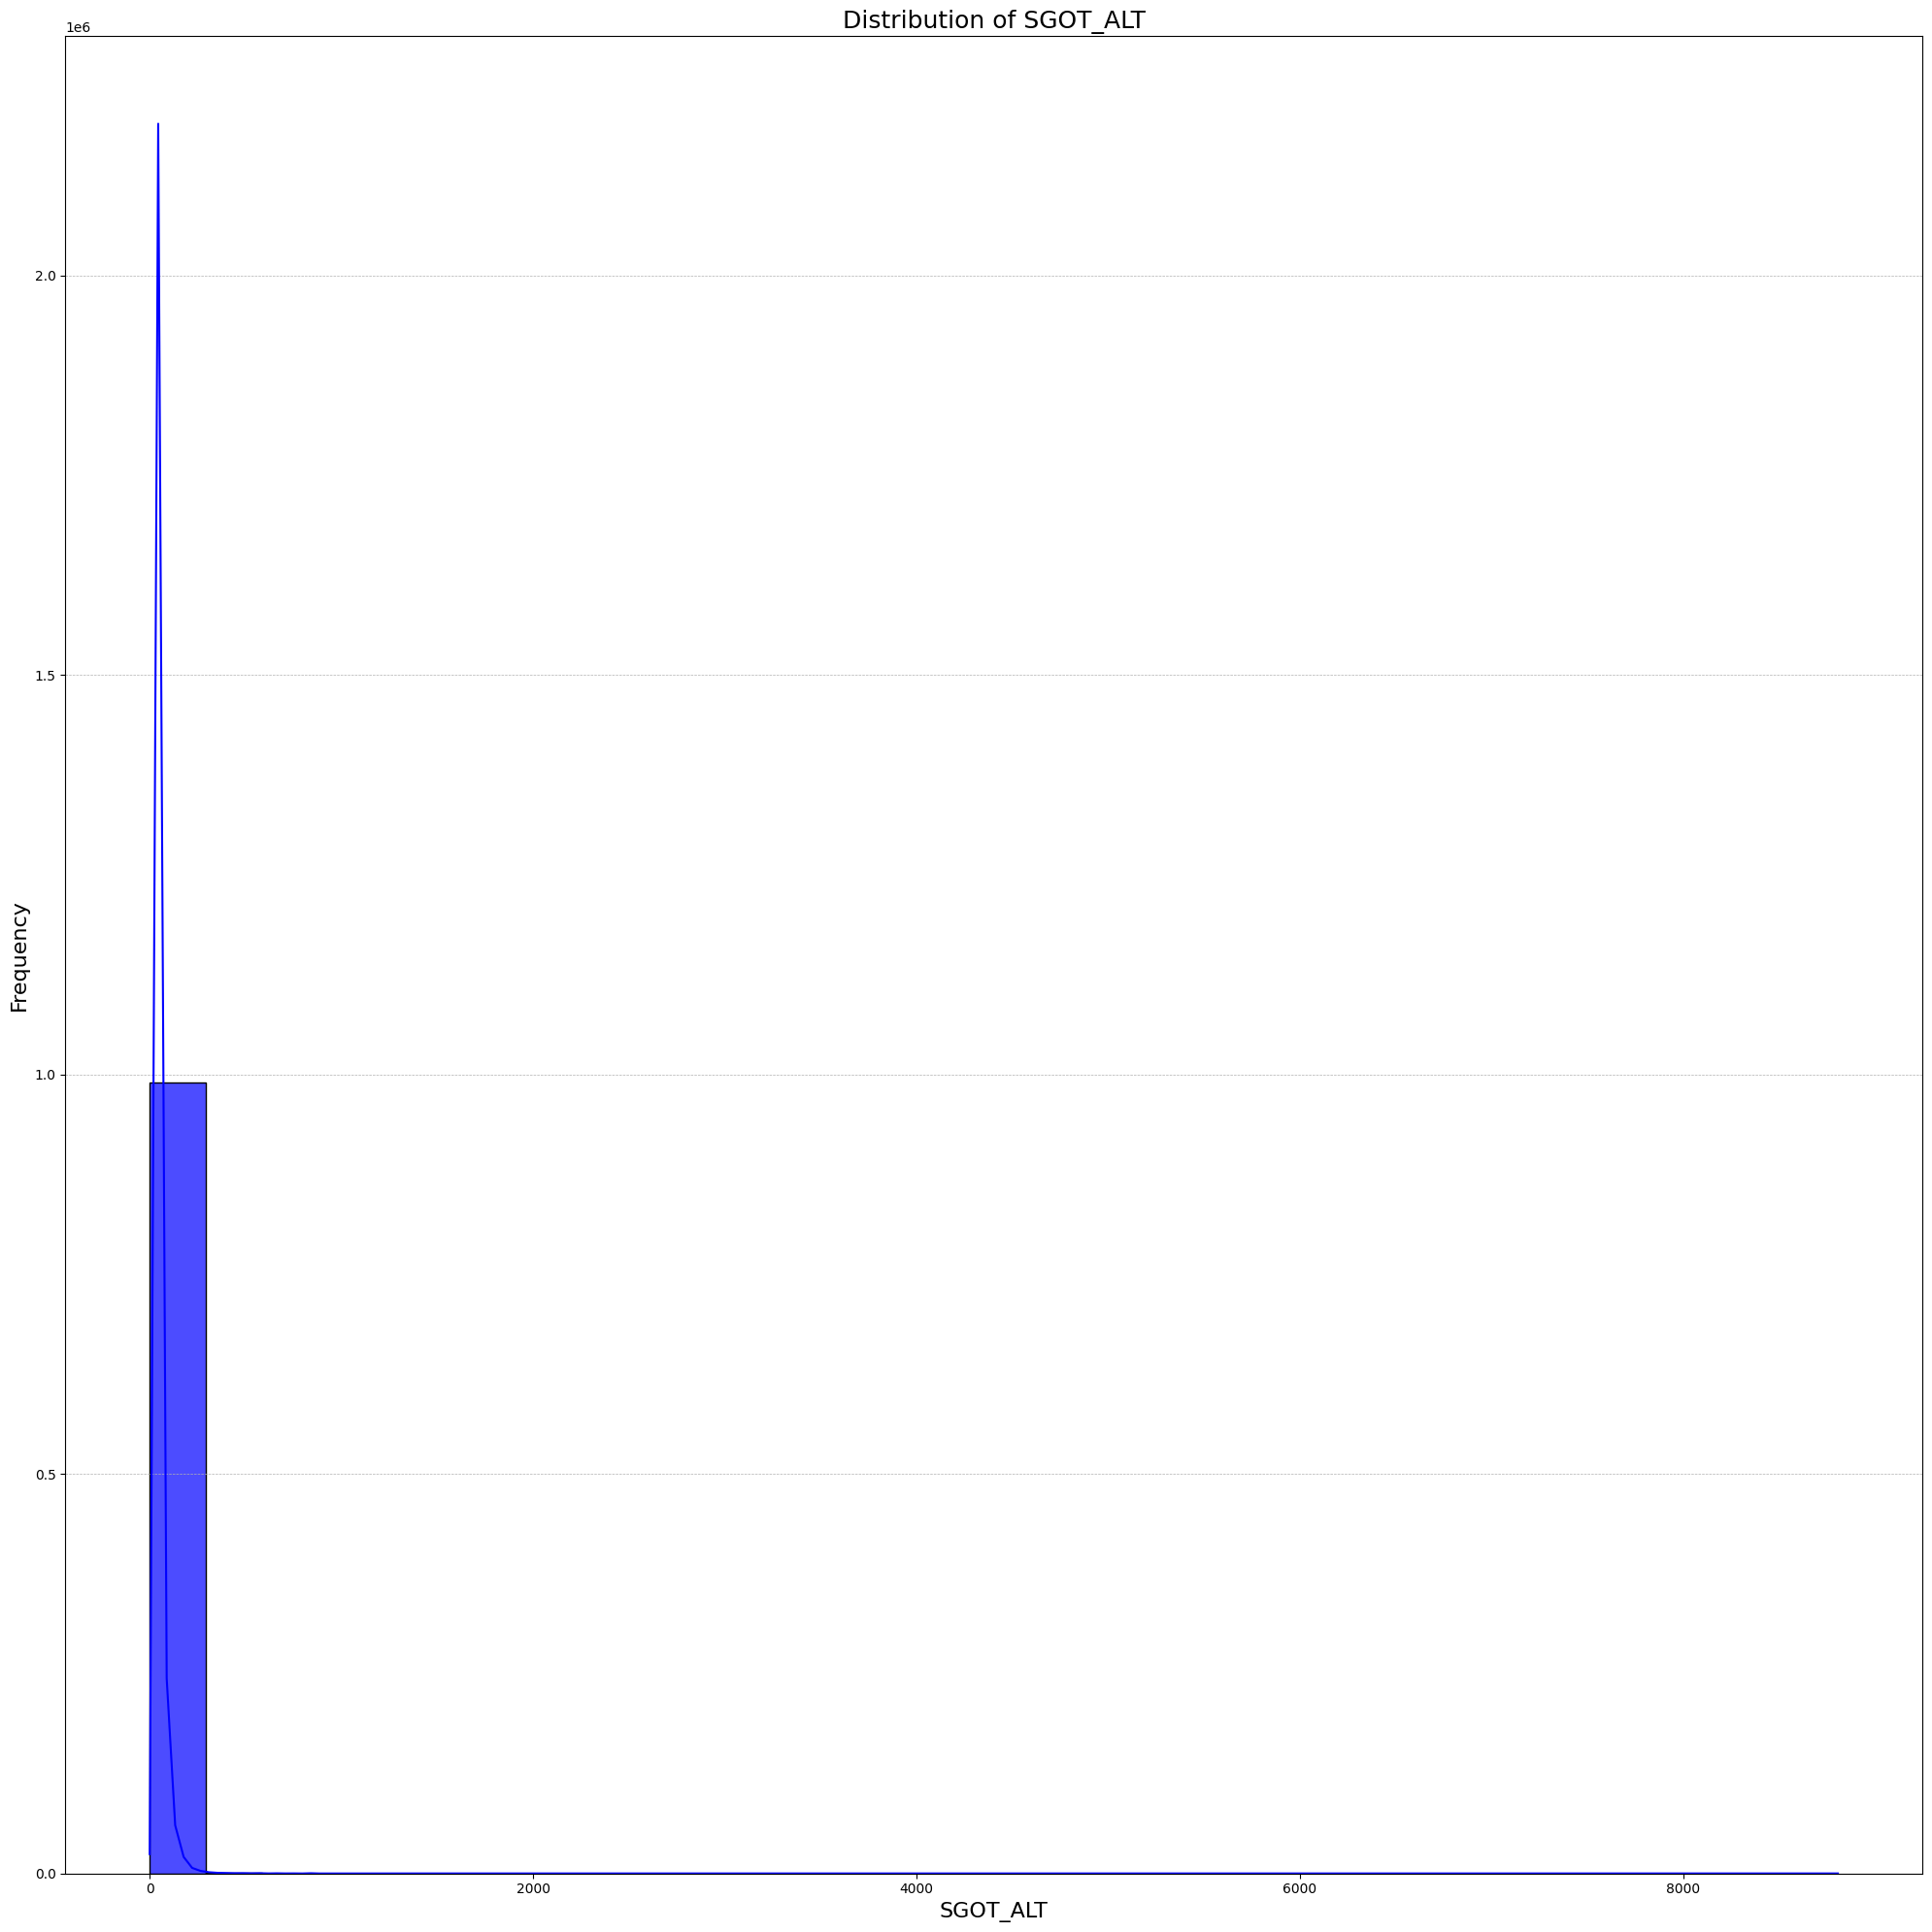

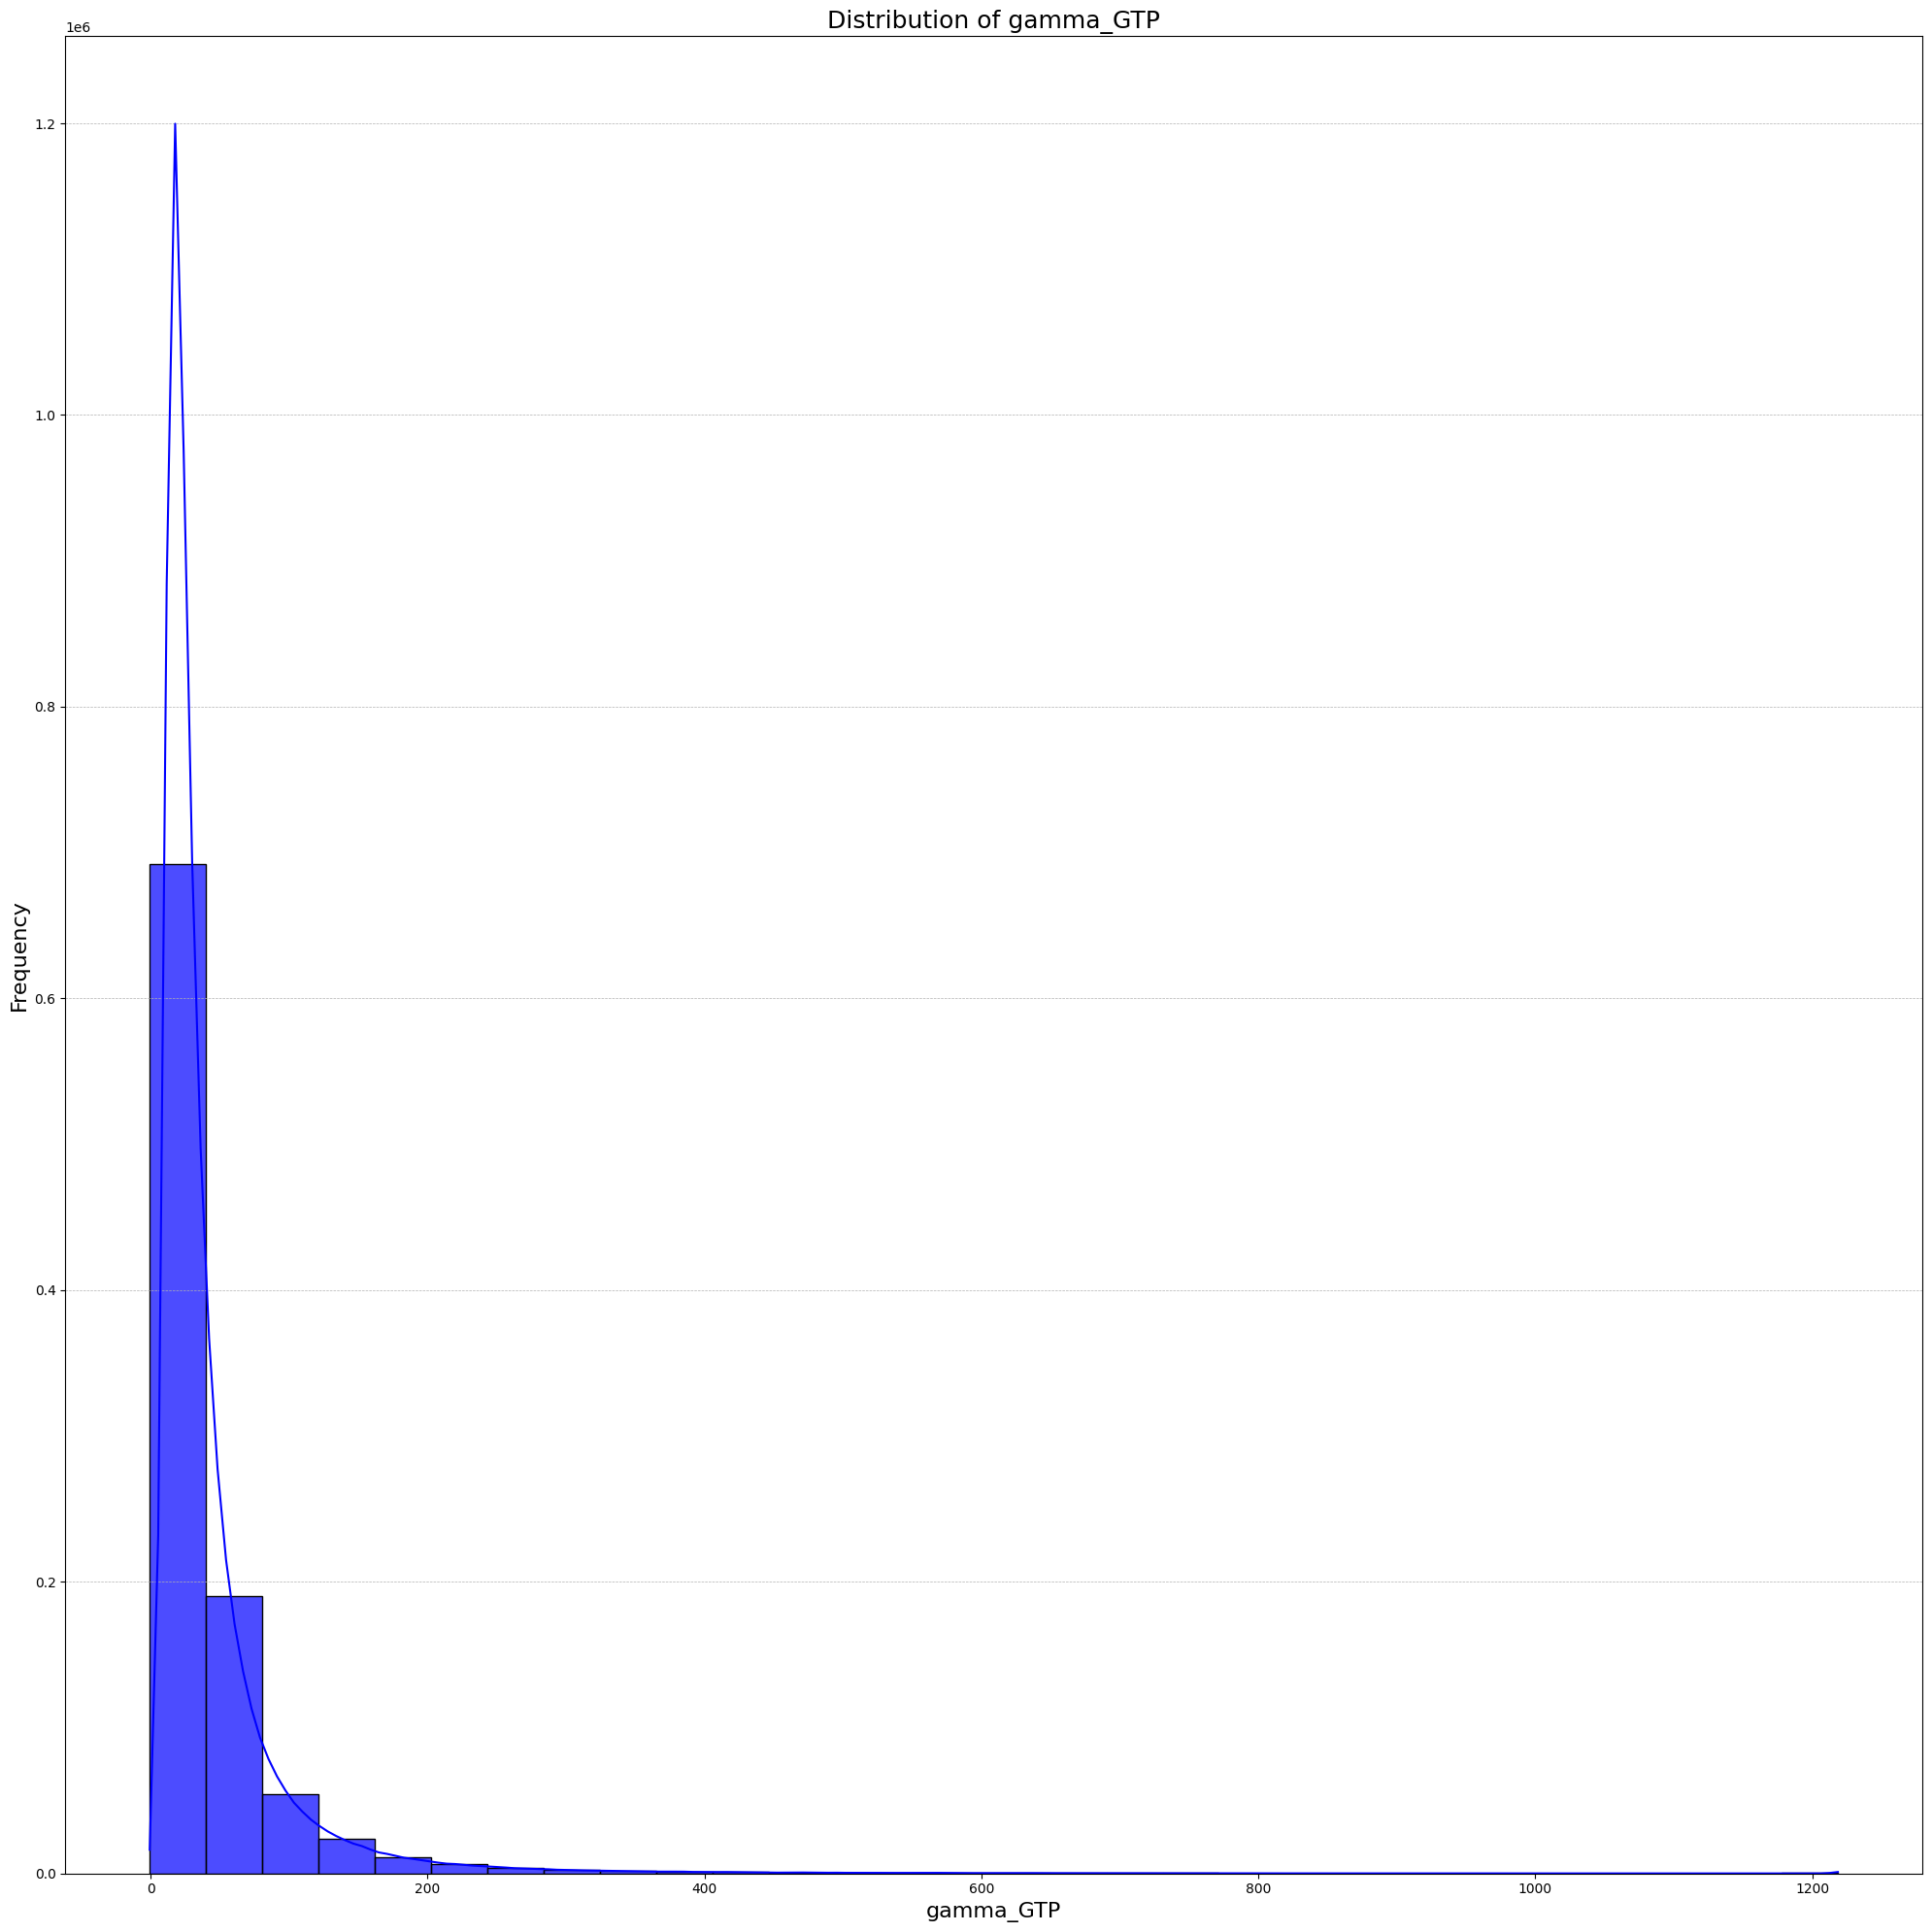

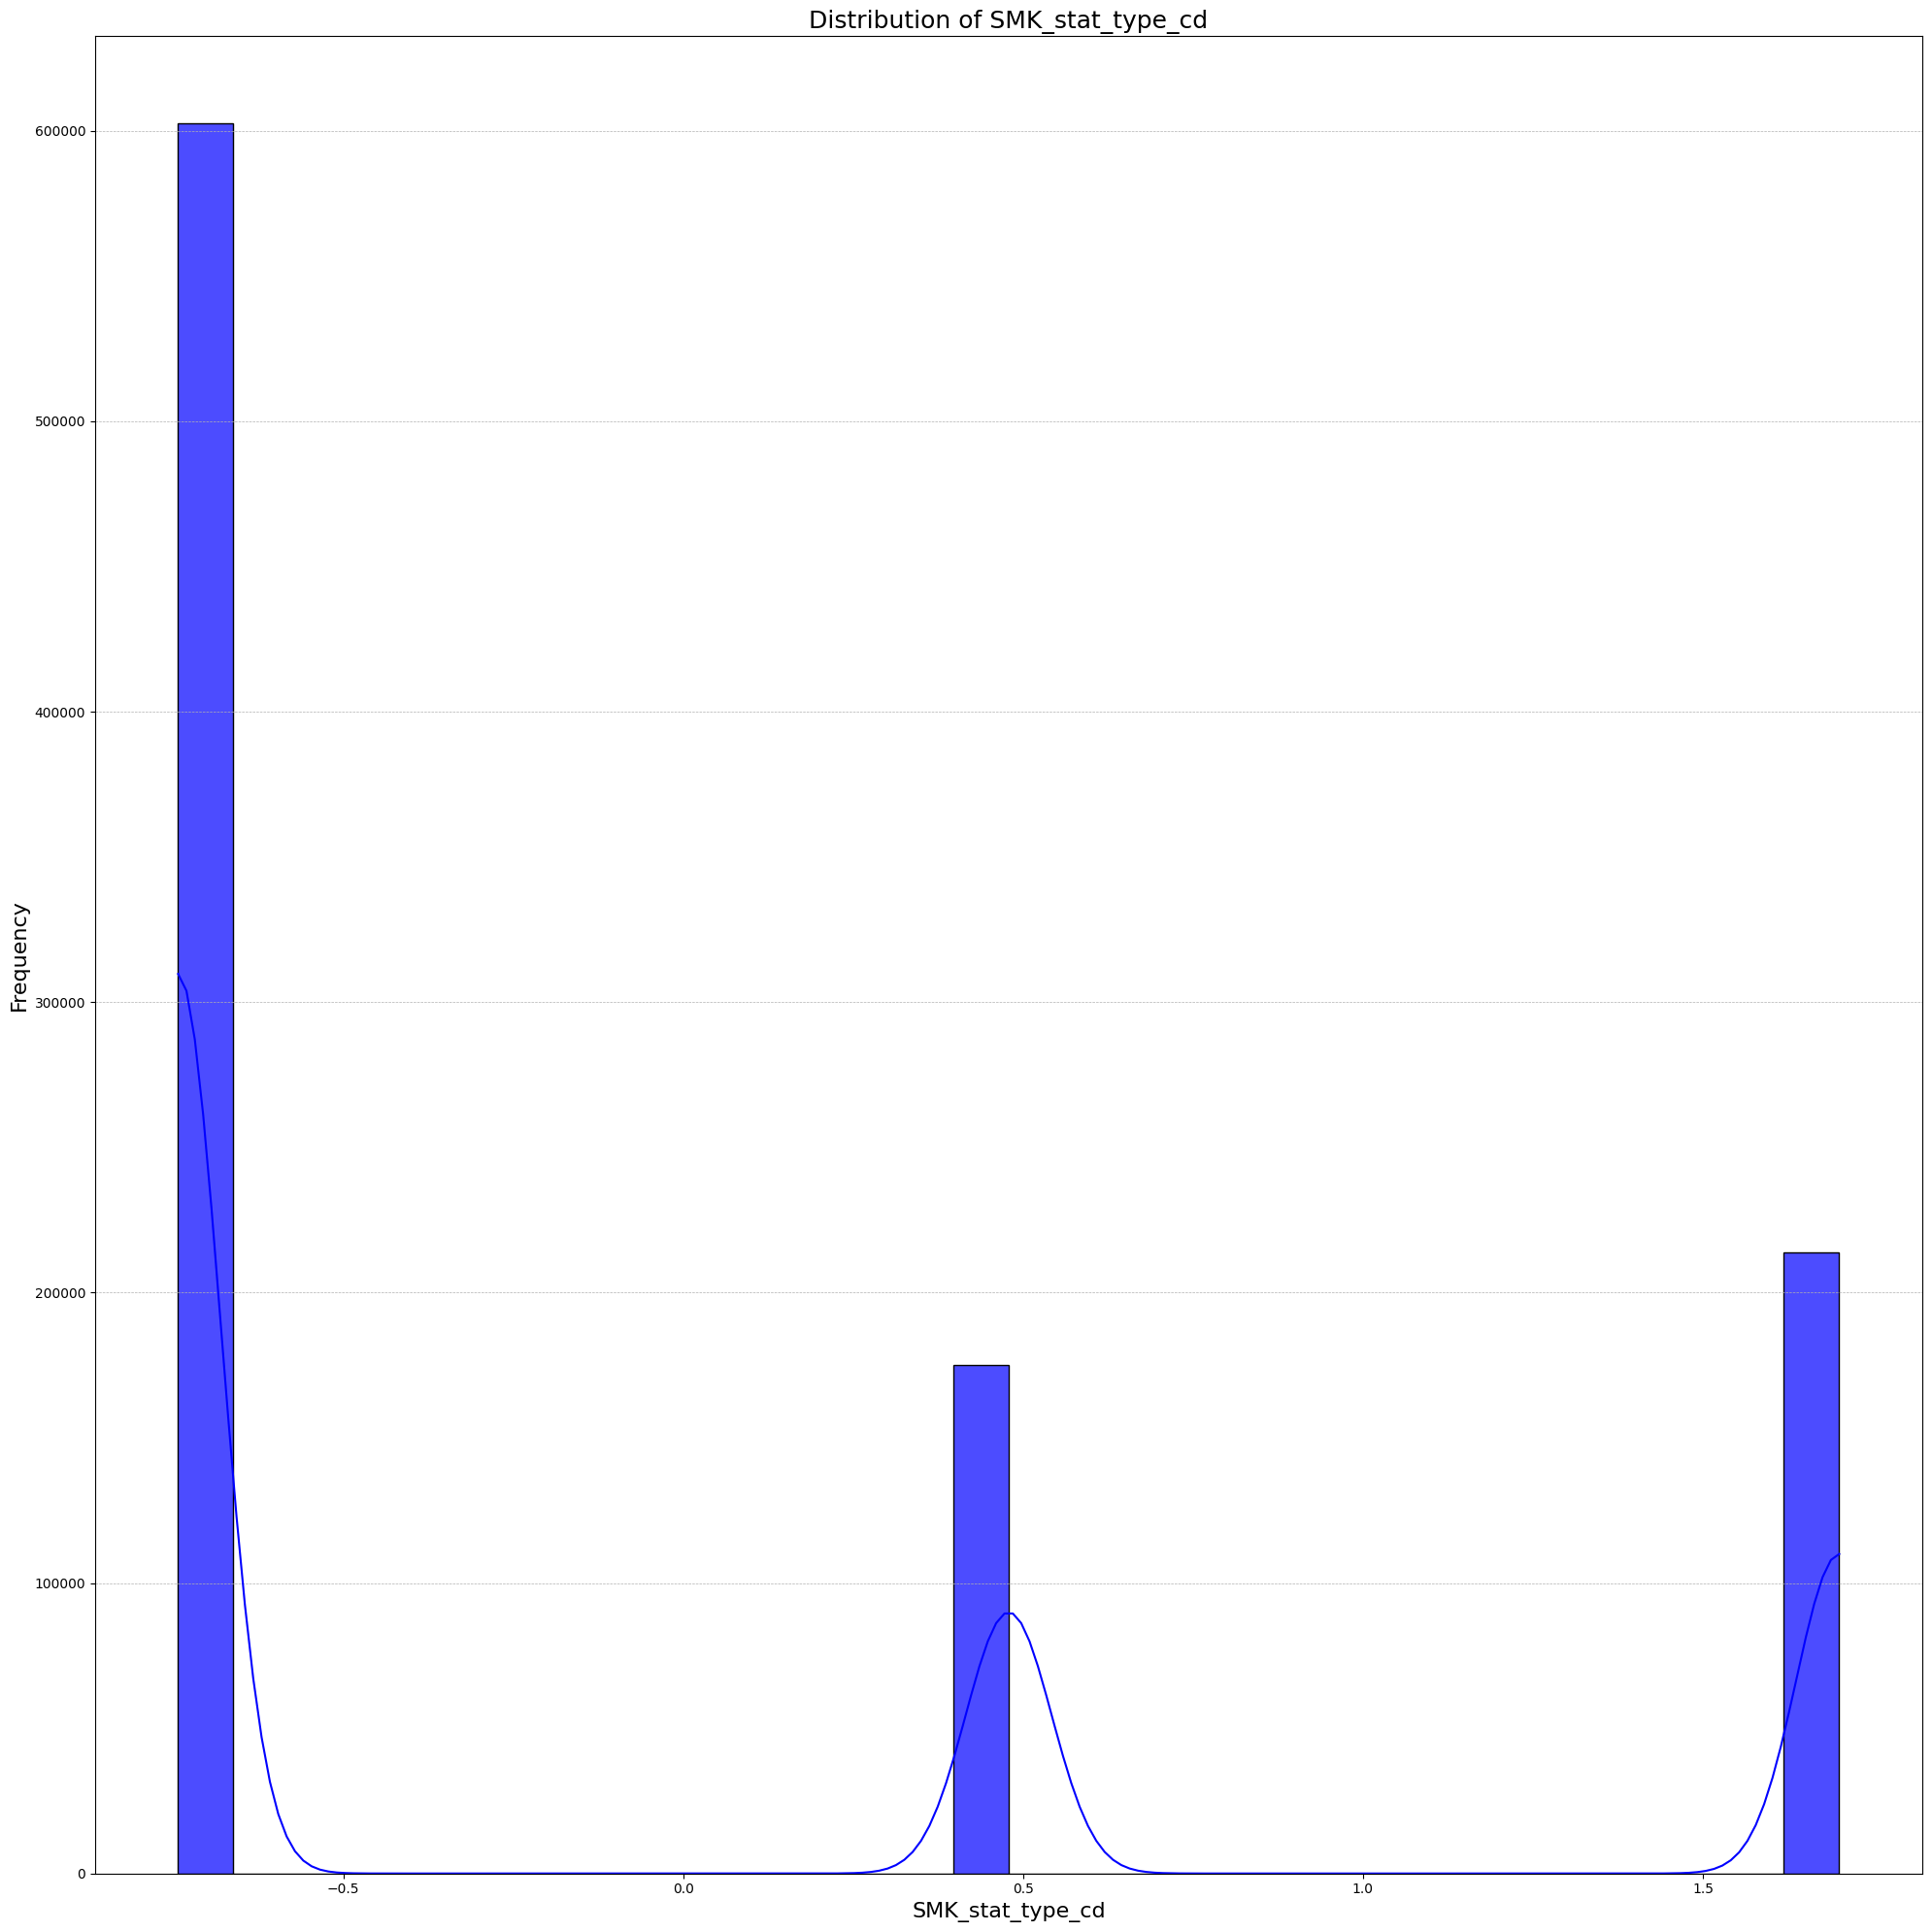

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'processed_health_data.csv'
df = pd.read_csv(file_path)

# Numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Plot histograms for numeric columns
for col in numeric_cols:
    plt.figure(figsize=(20, 20))
    sns.histplot(df[col], kde=True, bins=30, color='blue', edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of {col}", fontsize=18)
    plt.xlabel(col, fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(f"histogram_{col}.png", dpi=300)
    plt.show()


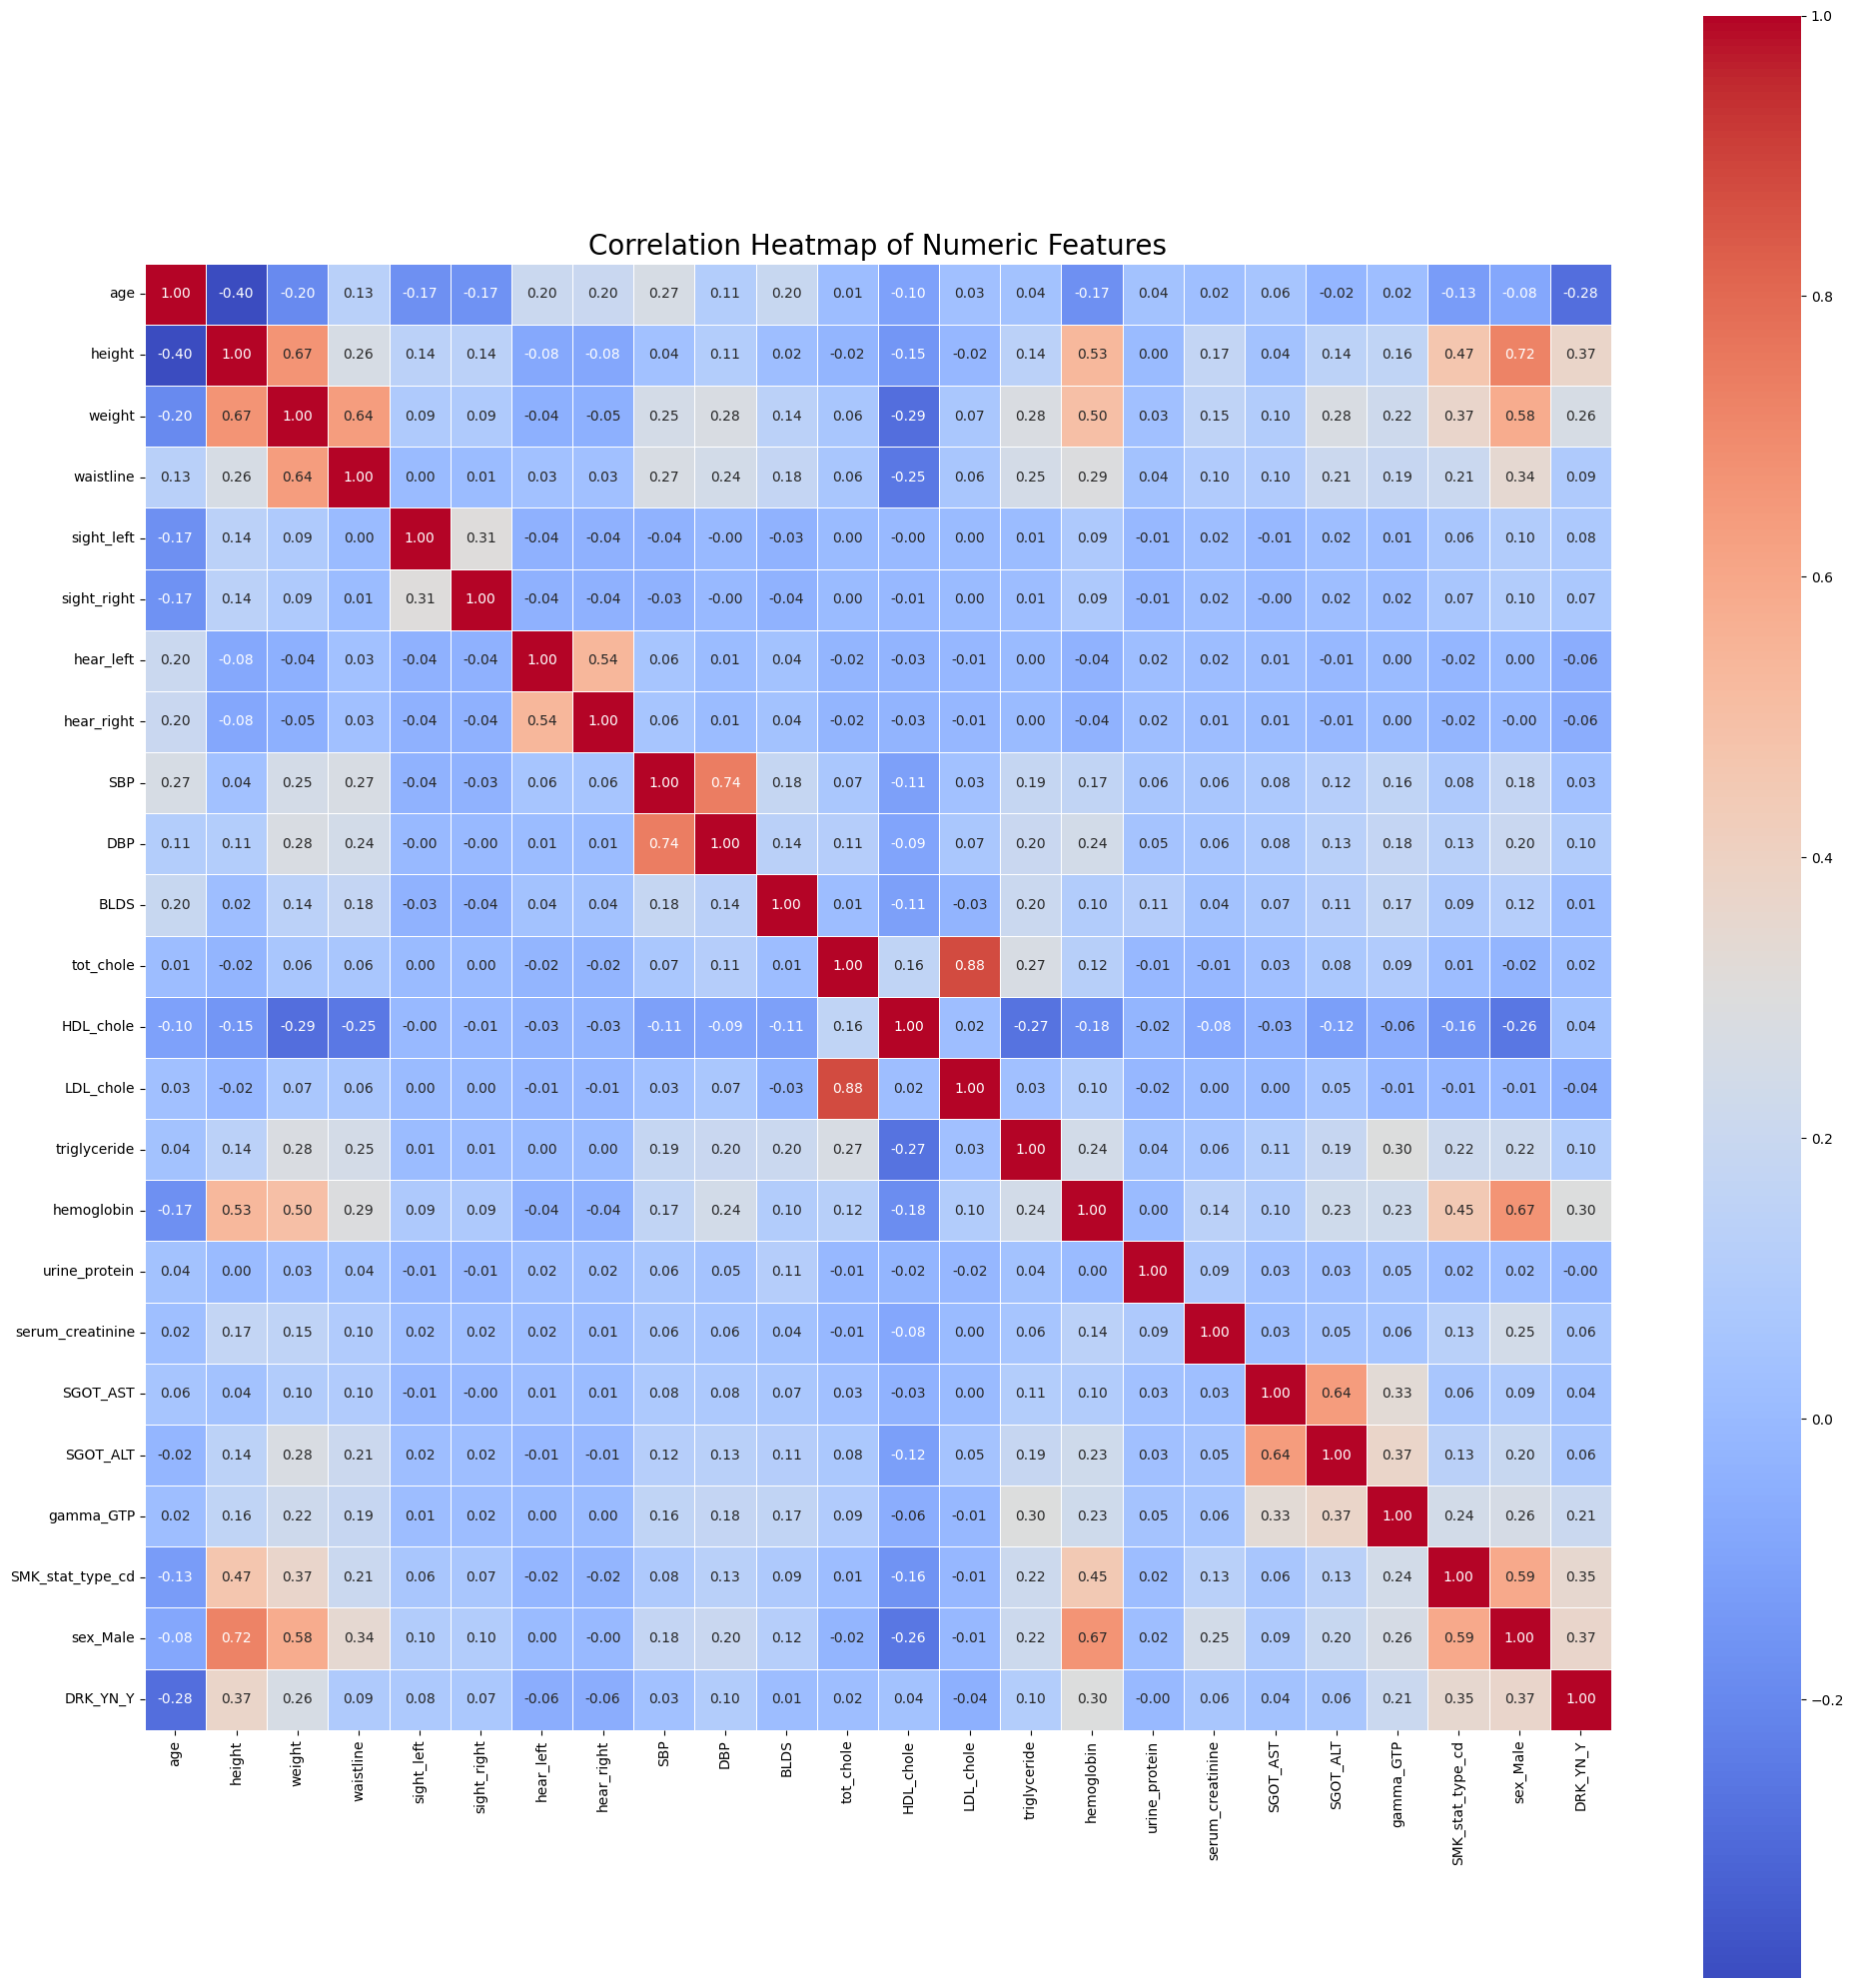

In [5]:
# Plot correlation heatmap
correlation_matrix = df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=True, fmt='.2f', linewidths=0.5, square=True)
plt.title("Correlation Heatmap of Numeric Features", fontsize=20)
plt.tight_layout()
plt.savefig("correlation_heatmap_advanced.png", dpi=300)
plt.show()


Generating pairplot for columns: Index(['age', 'height', 'weight', 'waistline', 'sight_left'], dtype='object')


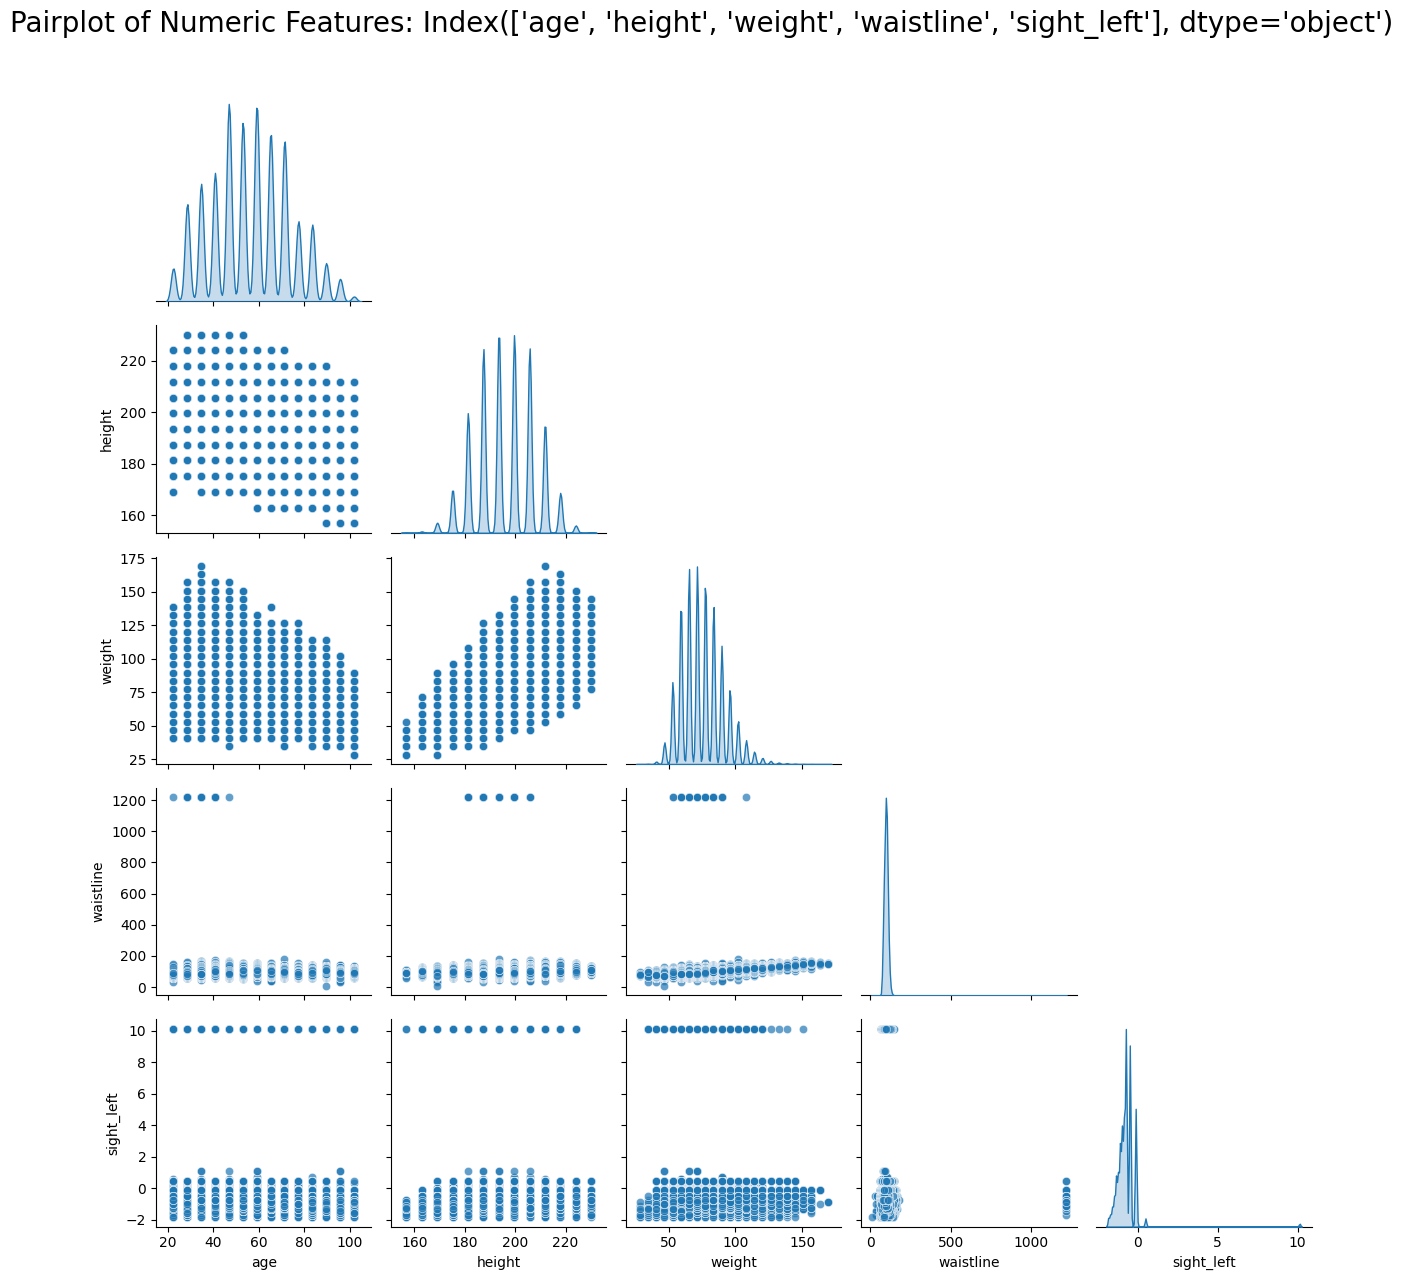

Generating pairplot for columns: Index(['sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP'], dtype='object')


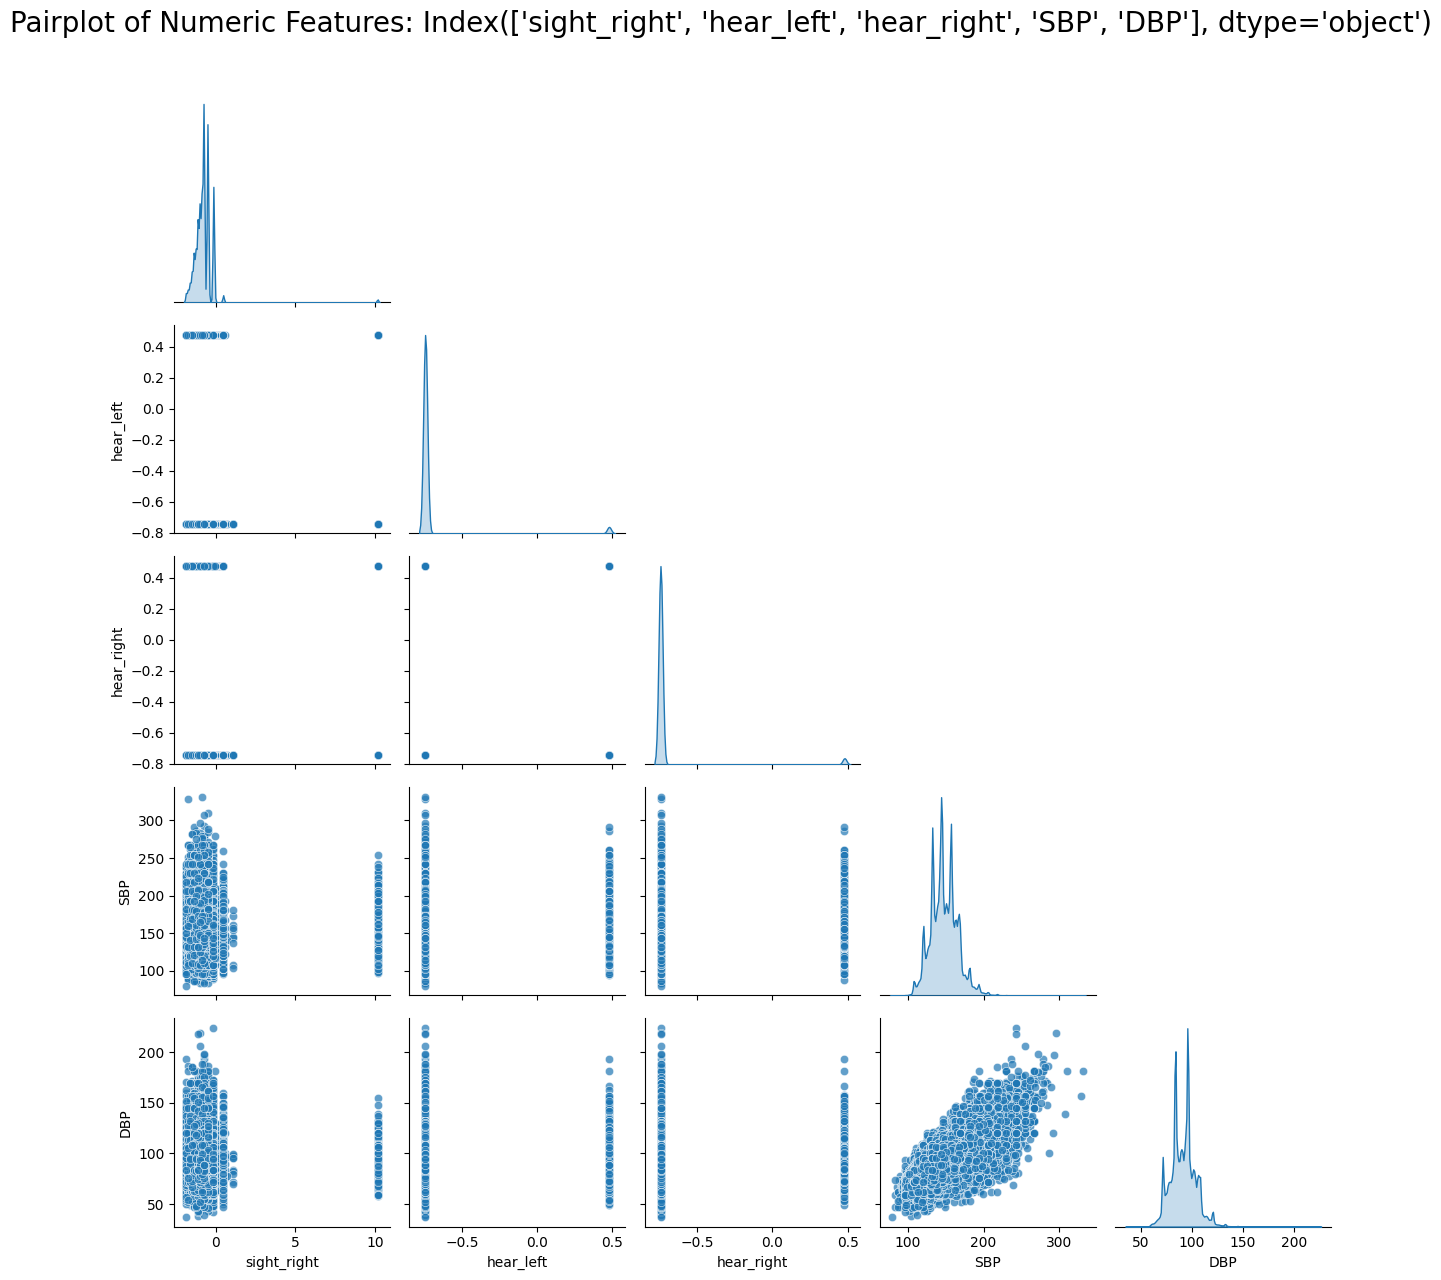

Generating pairplot for columns: Index(['BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride'], dtype='object')


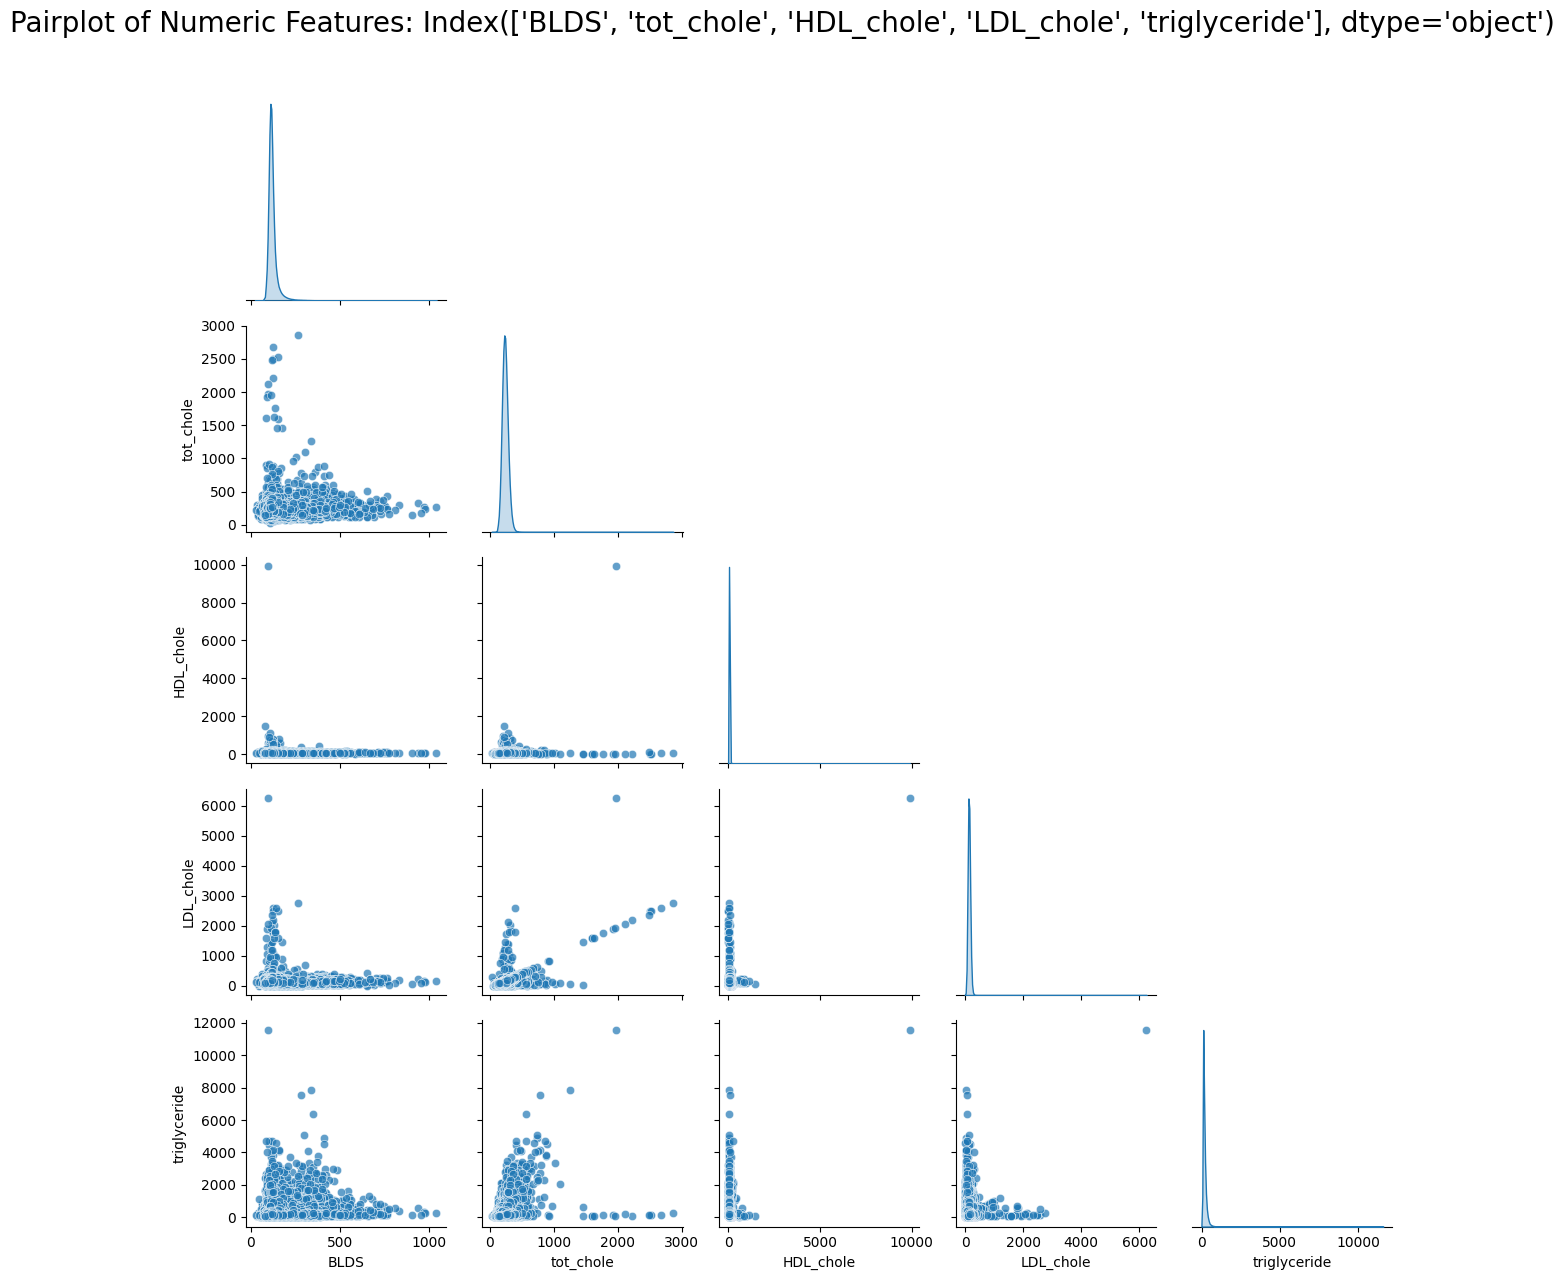

Generating pairplot for columns: Index(['hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST',
       'SGOT_ALT'],
      dtype='object')


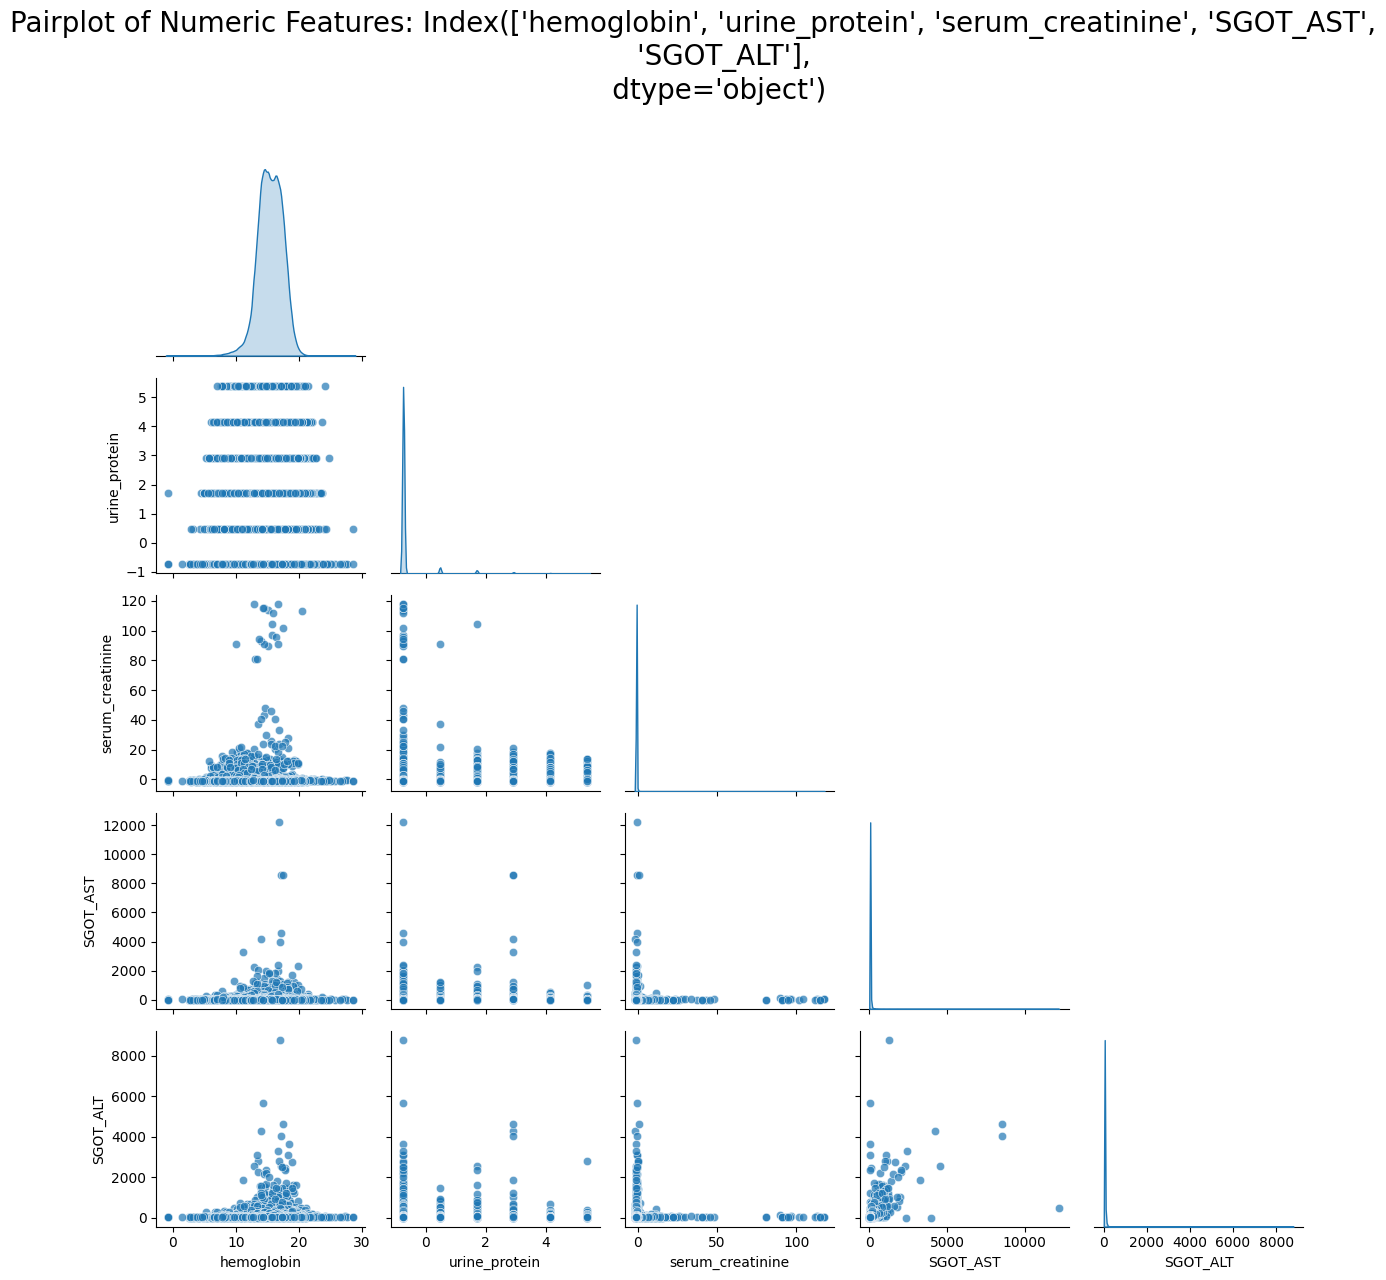

Generating pairplot for columns: Index(['gamma_GTP', 'SMK_stat_type_cd'], dtype='object')


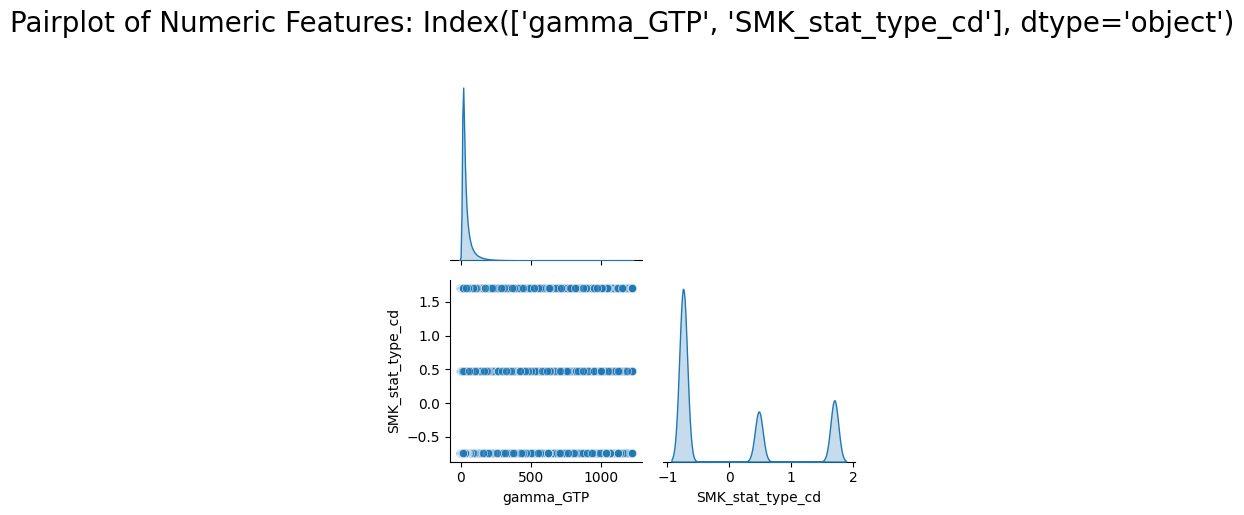

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset
file_path = 'processed_health_data.csv'  # Update with your file path
df = pd.read_csv(file_path)

# Select numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Function to generate pairplots for groups of columns
def generate_pairplots(df, numeric_cols, group_size=5):
    """
    Generate pairplots for groups of numeric columns.

    Parameters:
    df (DataFrame): Input data.
    numeric_cols (list): List of numeric column names.
    group_size (int): Number of columns to include in each group for pairplot.
    """
    # Split columns into groups
    num_columns = len(numeric_cols)
    for i in range(0, num_columns, group_size):
        group = numeric_cols[i:i + group_size]
        
        # Generate pairplot
        print(f"Generating pairplot for columns: {group}")
        pairplot = sns.pairplot(df[group], diag_kind='kde', corner=True, plot_kws={'alpha': 0.7})
        
        # Add title and save the plot
        pairplot.fig.suptitle(f"Pairplot of Numeric Features: {group}", y=1.02, fontsize=20)
        plt.tight_layout()
        plt.savefig(f"pairplot_{'_'.join(group)}.png", dpi=300)
        plt.show()

# Generate pairplots for numeric columns in groups of 5
generate_pairplots(df, numeric_cols, group_size=5)


In [ ]:
# Ensure BMI and BP_Category are calculated
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2
df['BP_Category'] = np.where(df['SBP'] >= 140, 'High', 
                              np.where(df['SBP'] >= 120, 'Elevated', 'Normal'))

plt.figure(figsize=(20, 20))
sns.boxplot(x='BP_Category', y='BMI', data=df, palette='Set3')
plt.title("Boxplot of BMI by Blood Pressure Category", fontsize=20)
plt.xlabel("Blood Pressure Category", fontsize=18)
plt.ylabel("BMI", fontsize=18)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("boxplot_bmi_bp_category_advanced.png", dpi=300)
plt.show()


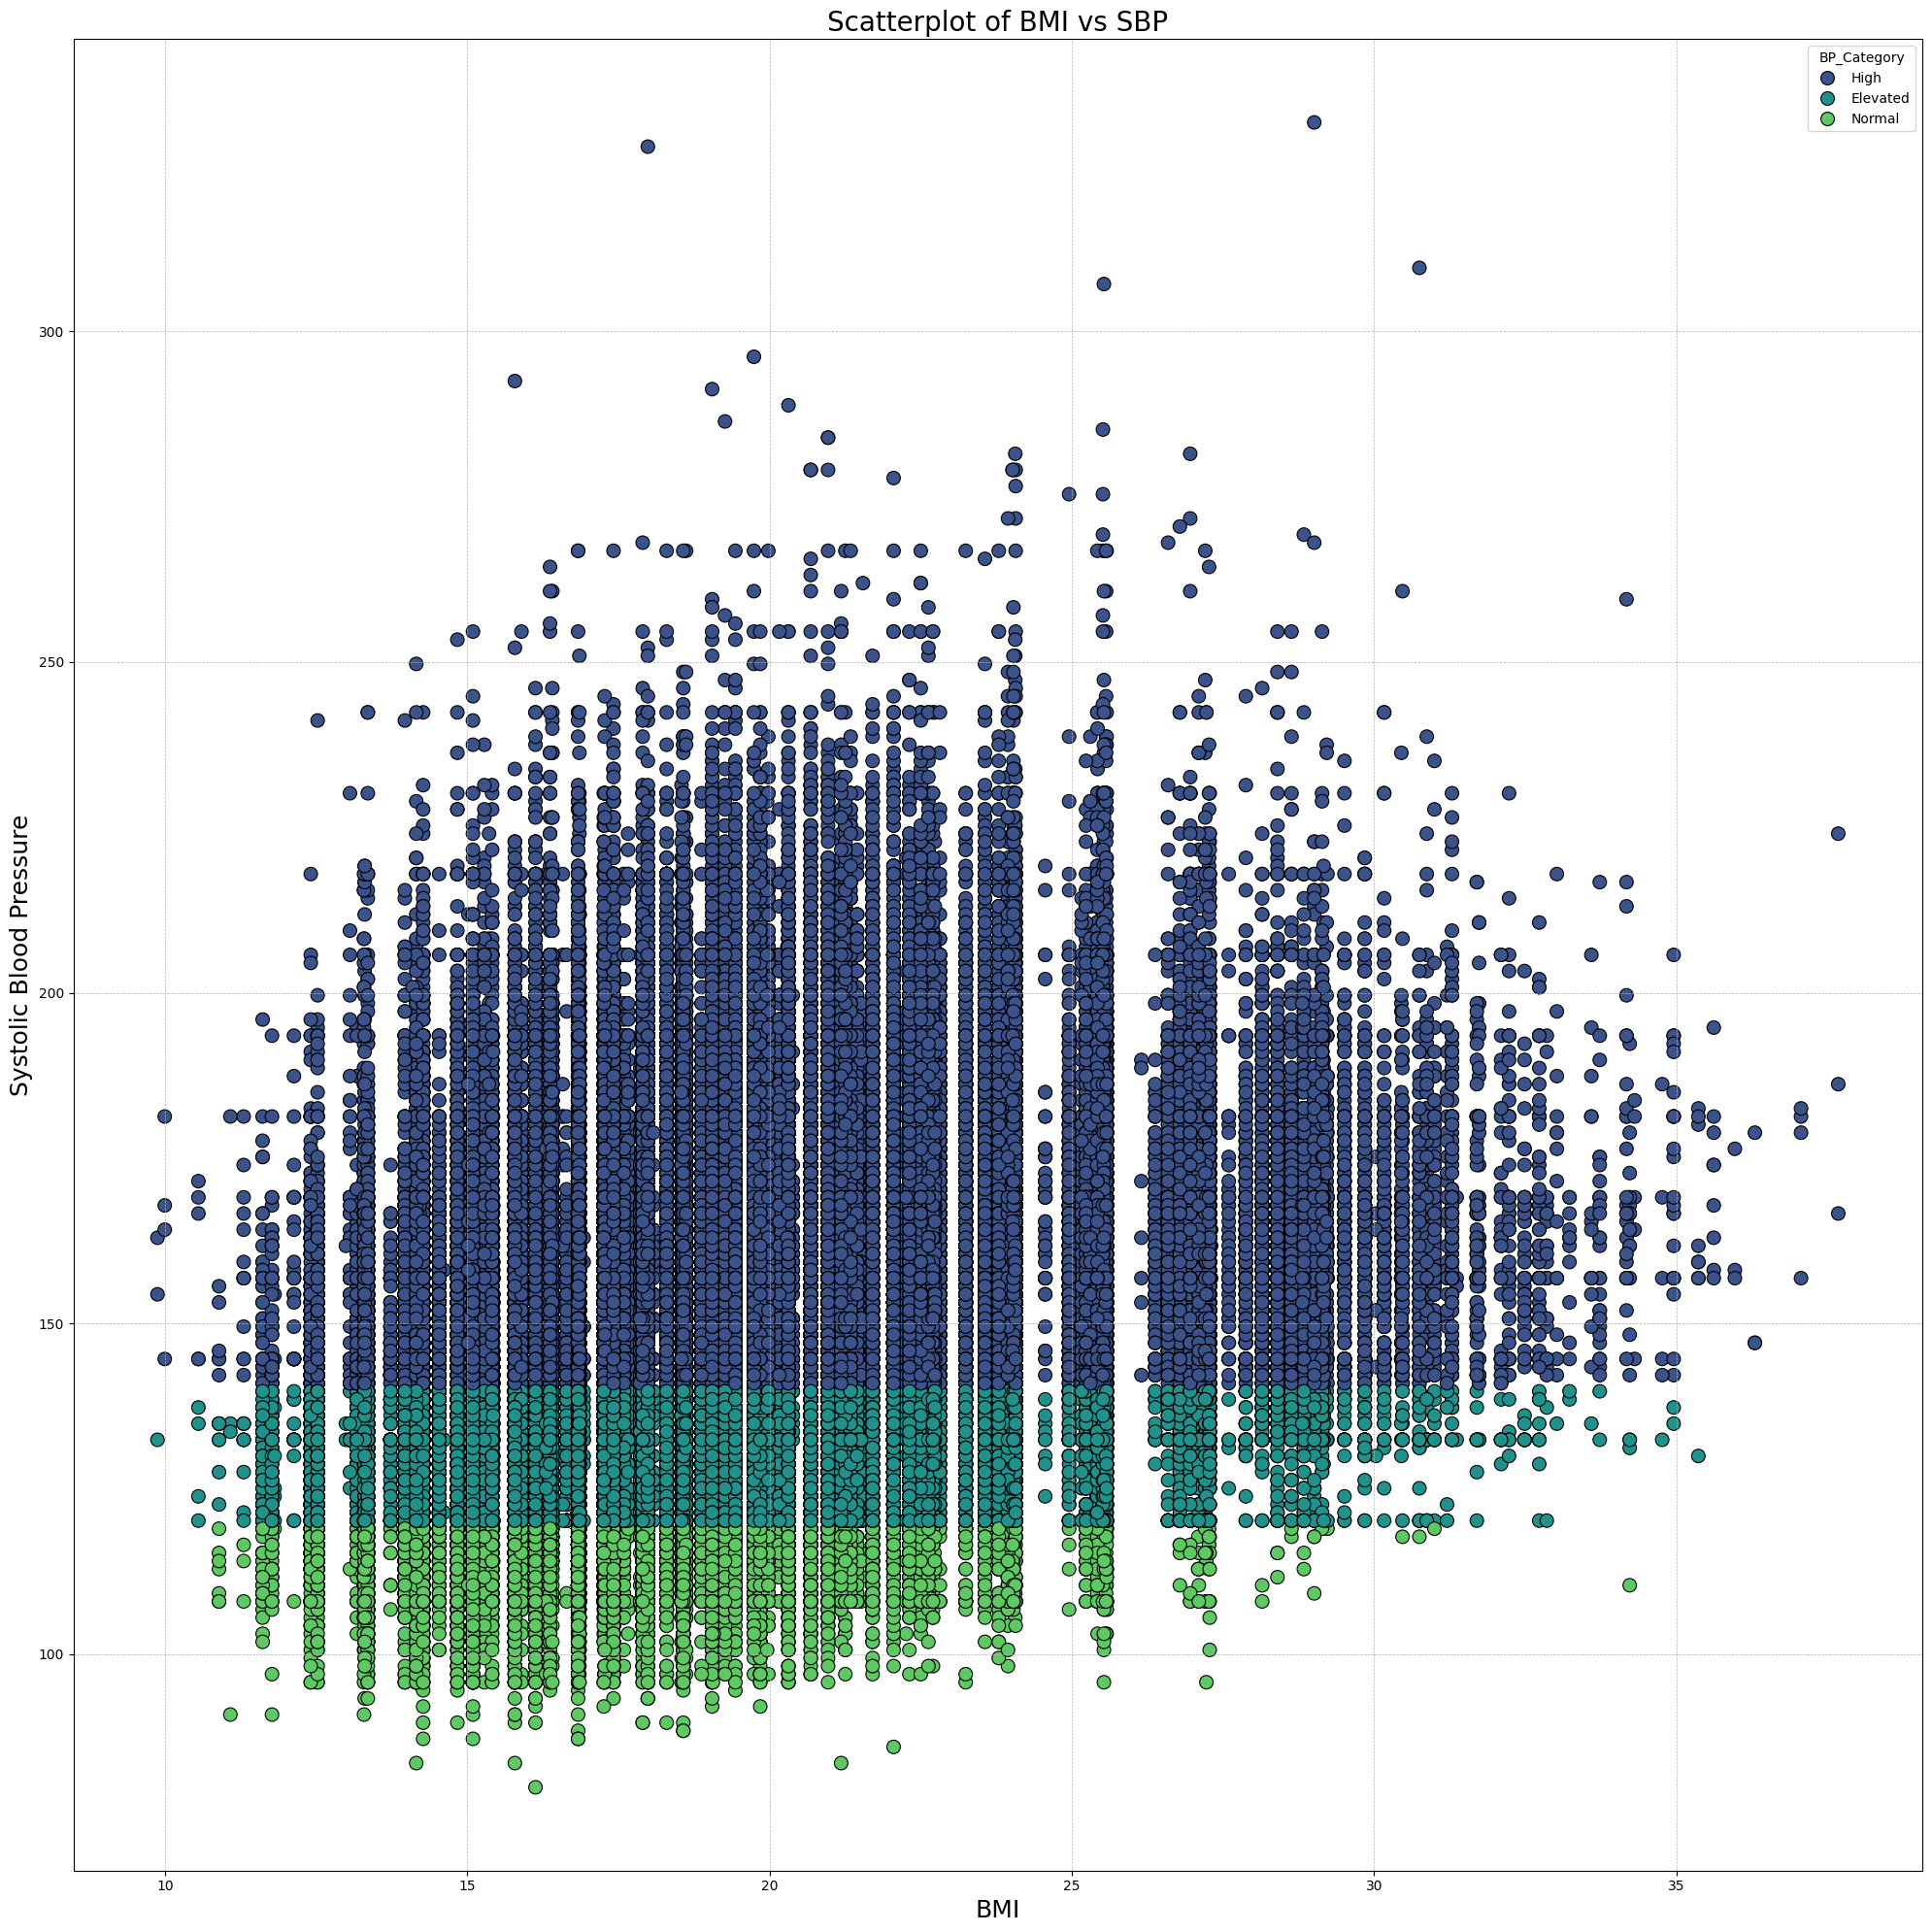

In [8]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x='BMI', y='SBP', hue='BP_Category', data=df, palette='viridis', s=100, edgecolor='black')
plt.title("Scatterplot of BMI vs SBP", fontsize=20)
plt.xlabel("BMI", fontsize=18)
plt.ylabel("Systolic Blood Pressure", fontsize=18)
plt.grid(axis='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("scatterplot_bmi_sbp_advanced.png", dpi=300)
plt.show()


In [9]:
# Analyze missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if not missing_data.empty:
    plt.figure(figsize=(20, 20))
    missing_data.plot(kind='bar', color='red', alpha=0.8, edgecolor='black')
    plt.title("Missing Data by Feature", fontsize=20)
    plt.ylabel("Number of Missing Values", fontsize=18)
    plt.xlabel("Features", fontsize=18)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig("missing_data_advanced.png", dpi=300)
    plt.show()
else:
    print("No missing data found.")


No missing data found.


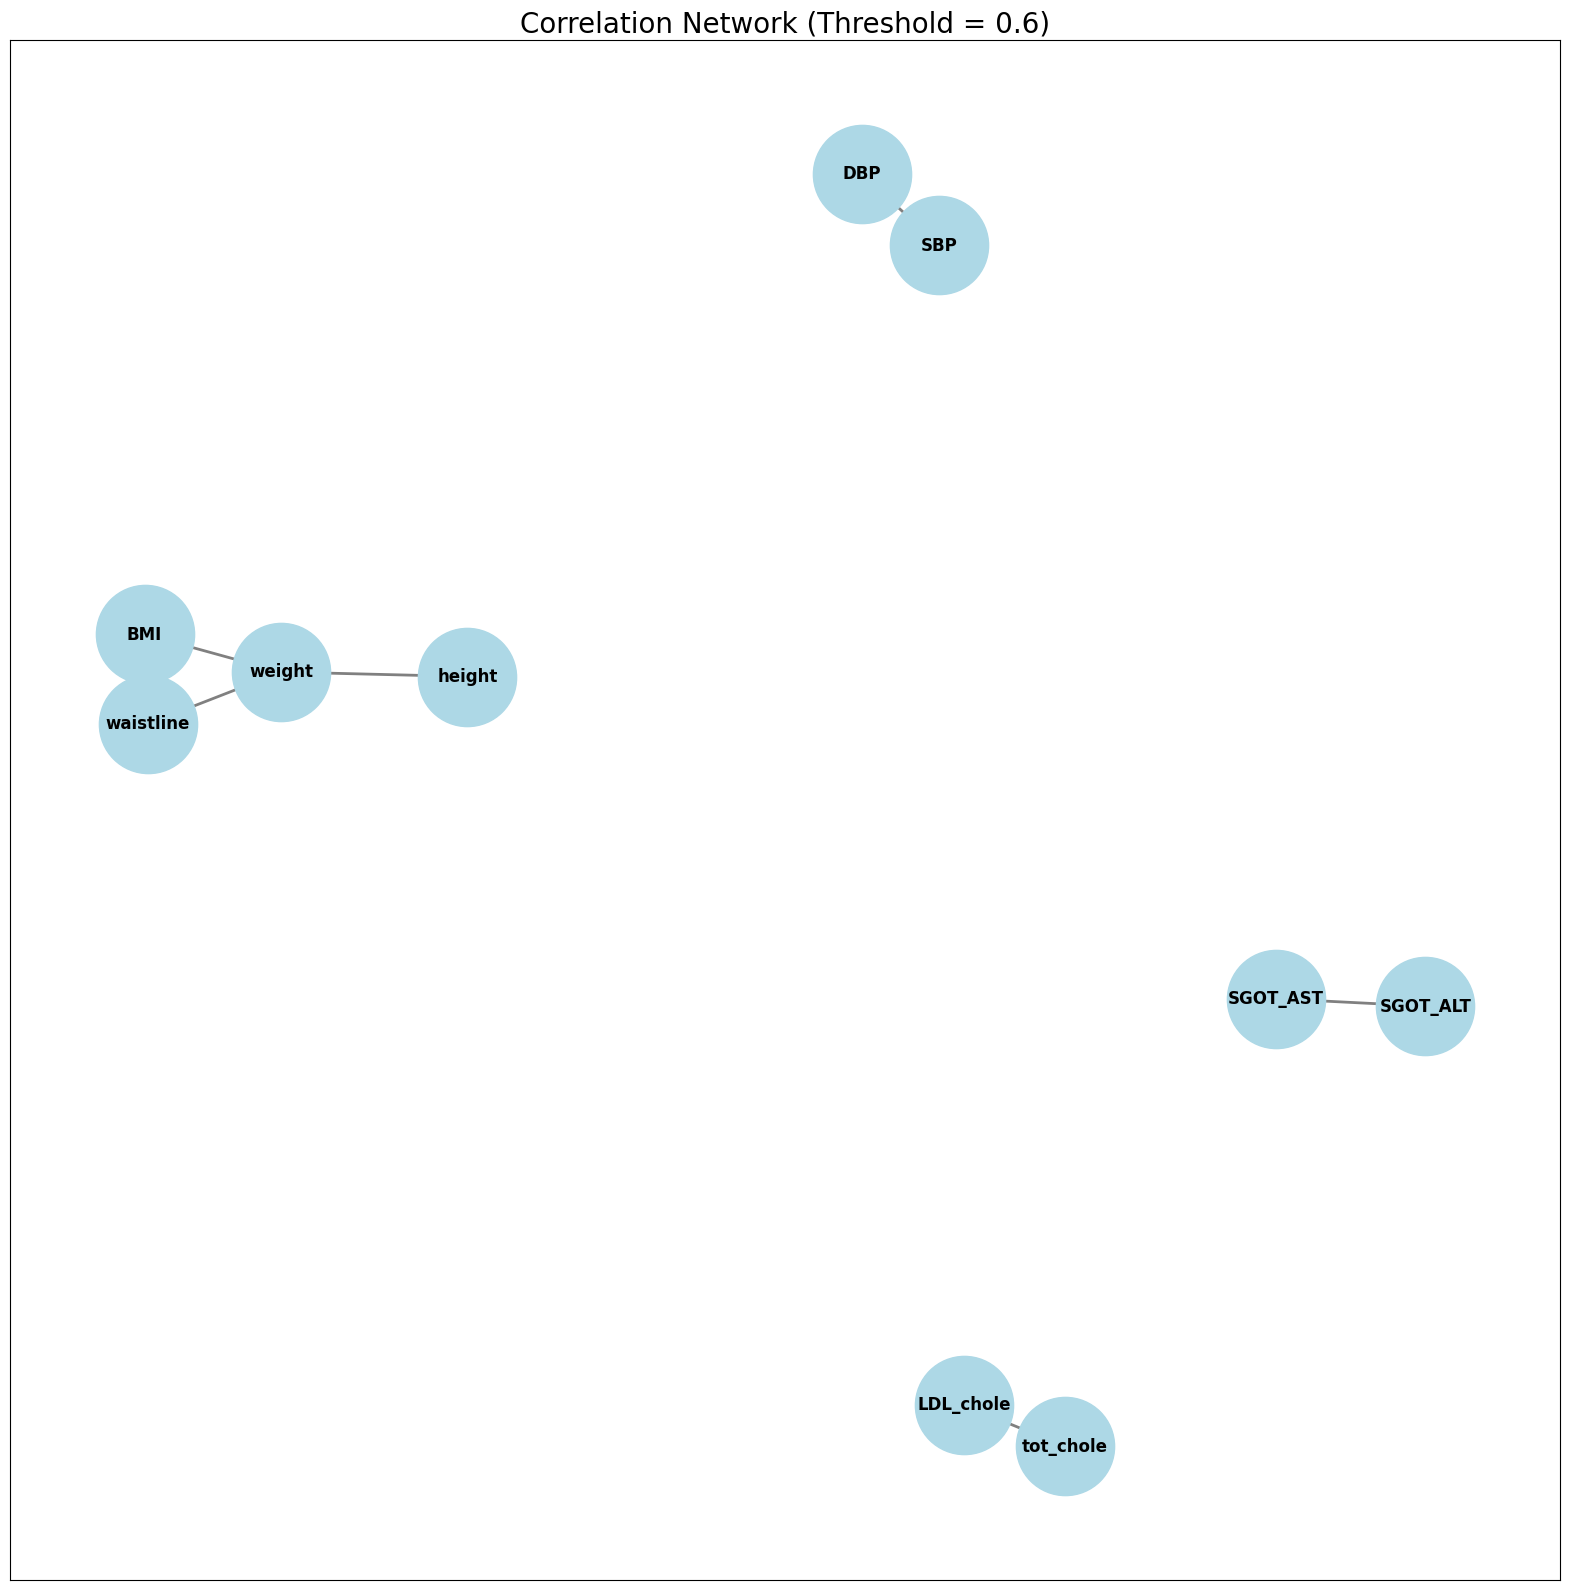

In [10]:
import networkx as nx

def correlation_network(df, threshold=0.5):
    numeric_cols = df.select_dtypes(include=['number']).columns
    correlation_matrix = df[numeric_cols].corr()

    G = nx.Graph()

    for i in correlation_matrix.columns:
        for j in correlation_matrix.columns:
            if i != j and abs(correlation_matrix.loc[i, j]) > threshold:
                G.add_edge(i, j, weight=correlation_matrix.loc[i, j])

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=5000, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, width=2, edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
    plt.title(f"Correlation Network (Threshold = {threshold})", fontsize=20)
    plt.savefig("correlation_network.png", dpi=300)
    plt.show()

correlation_network(df, threshold=0.6)


Model Performance:
Mean Squared Error (MSE): 122.86
R-squared (R2): 0.61


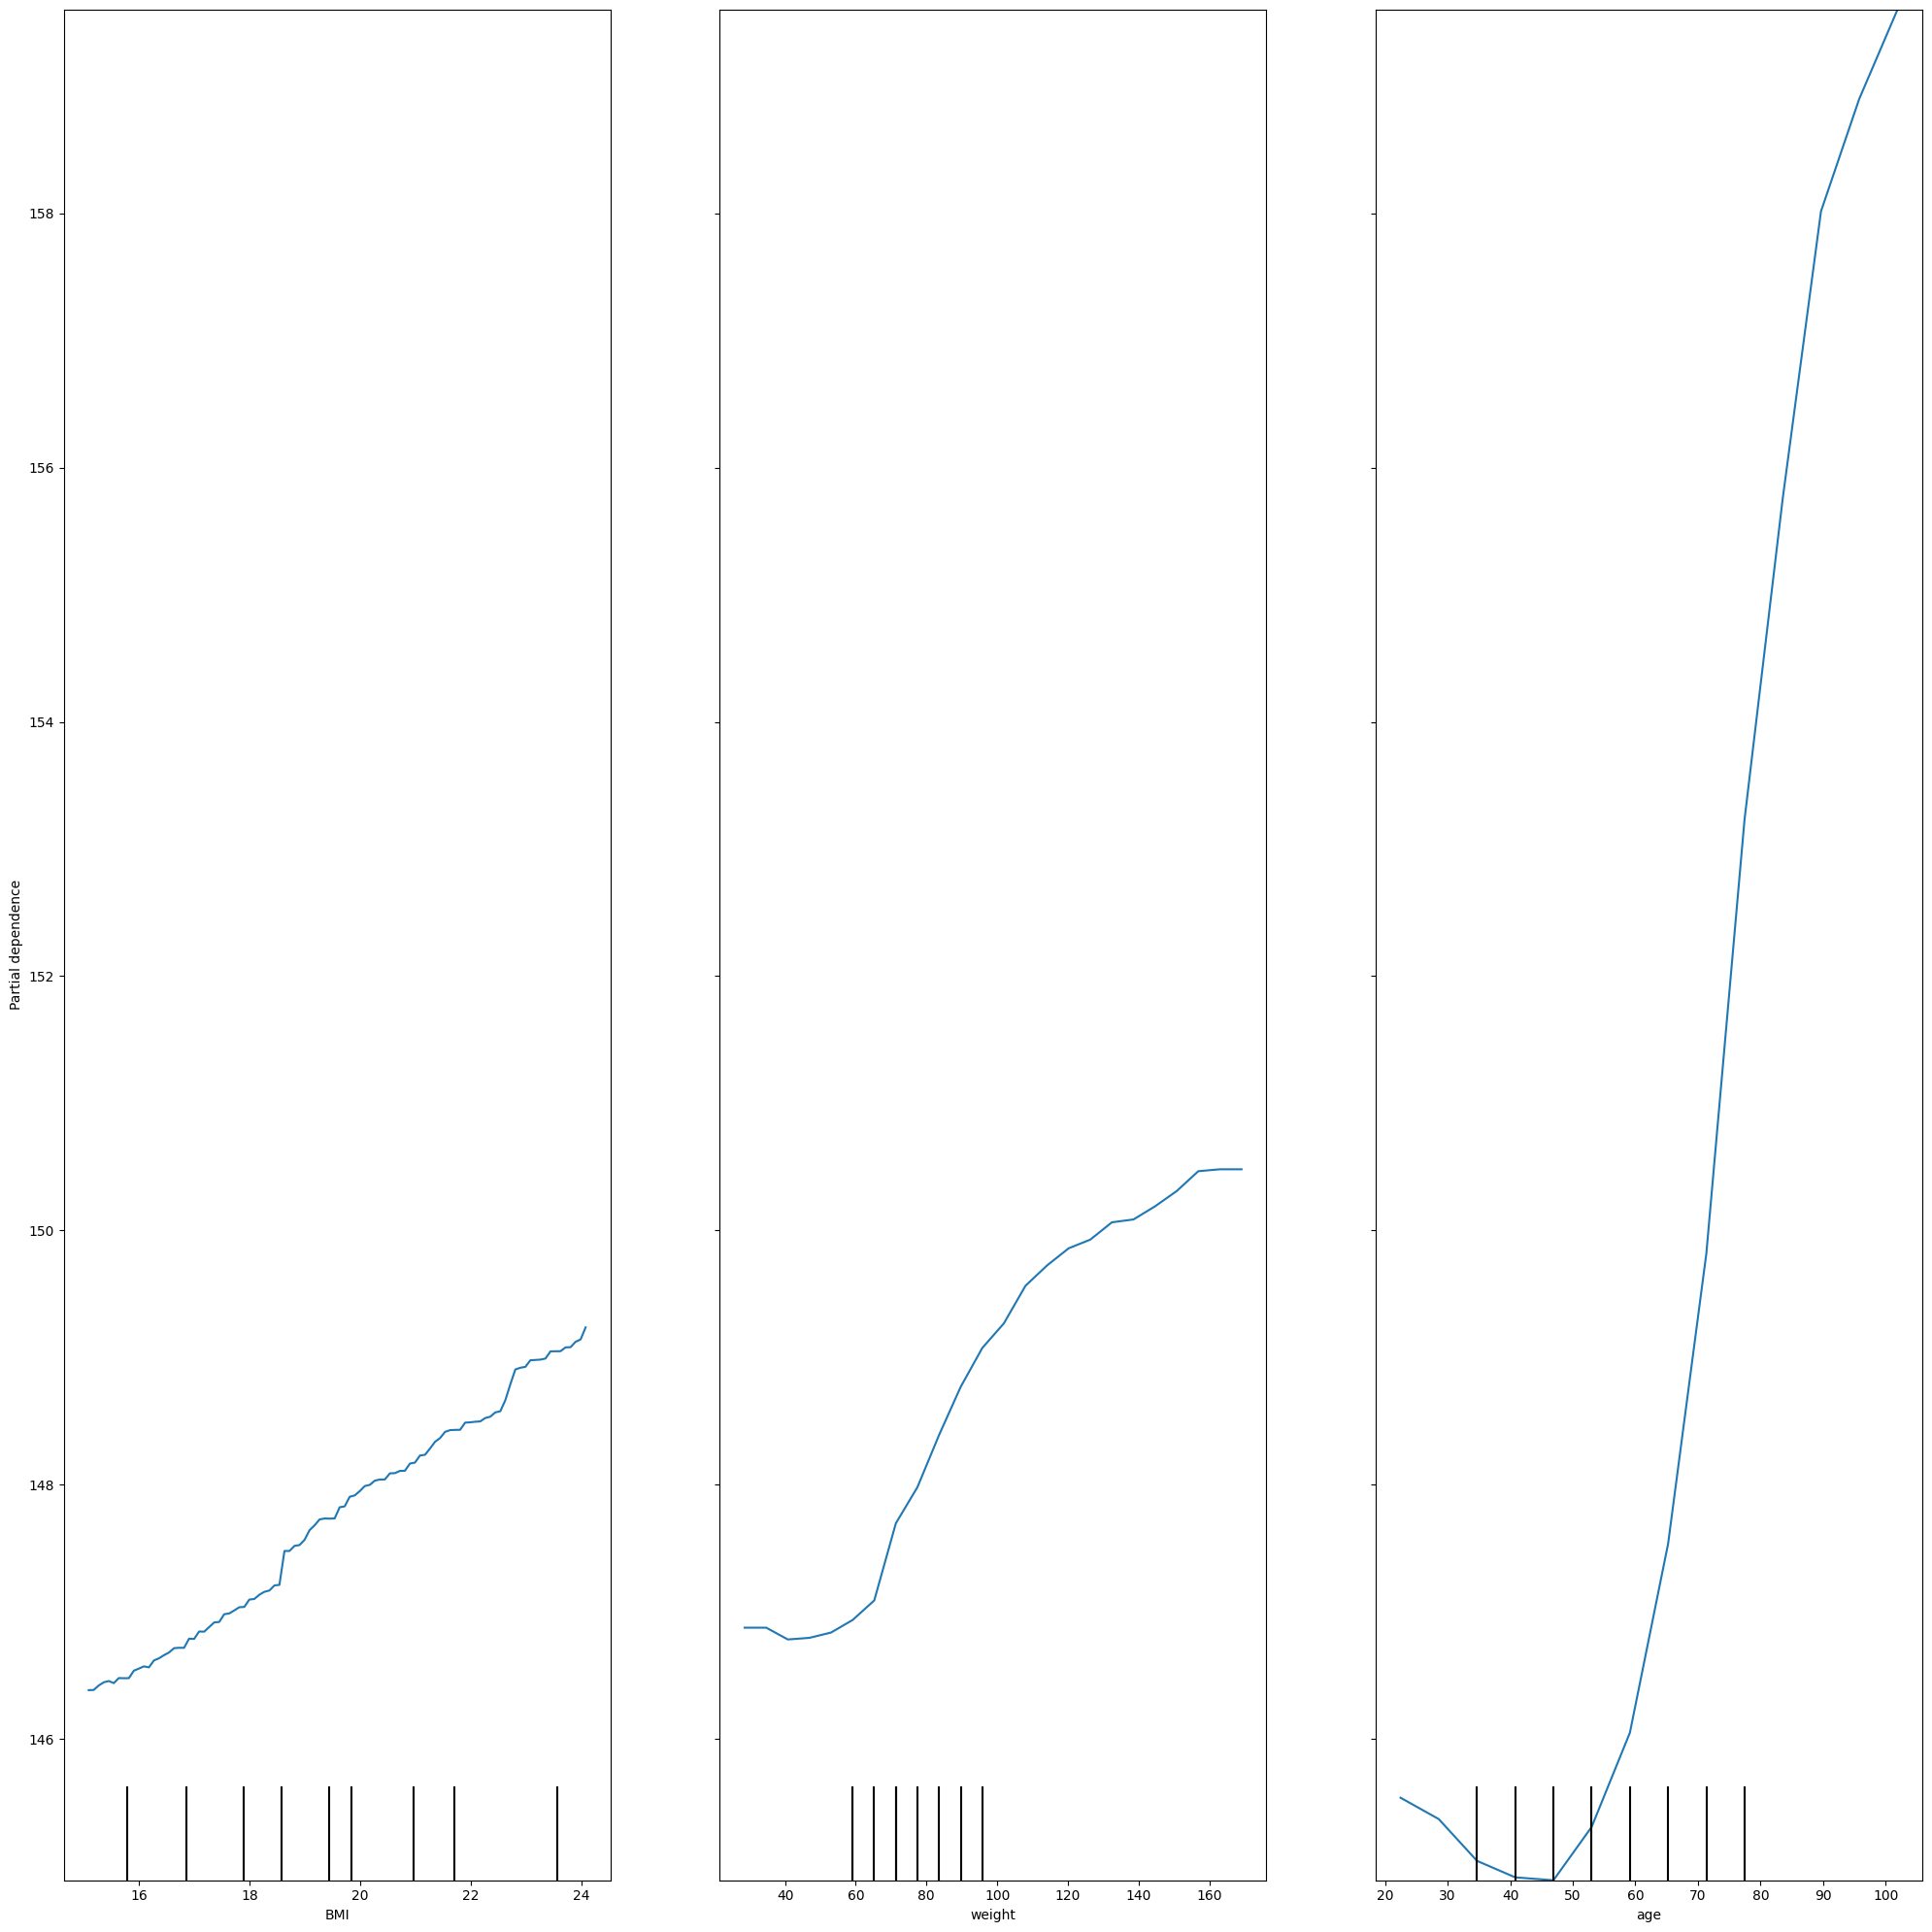

Feature Importances:
             Feature  Importance
8                DBP    0.561111
0                age    0.053352
13      triglyceride    0.033013
3          waistline    0.031075
9               BLDS    0.030901
14        hemoglobin    0.030179
11         HDL_chole    0.028231
19         gamma_GTP    0.028038
12         LDL_chole    0.027240
10         tot_chole    0.026697
18          SGOT_ALT    0.024561
17          SGOT_AST    0.023608
21               BMI    0.021493
16  serum_creatinine    0.016315
4         sight_left    0.015919
5        sight_right    0.015816
2             weight    0.011816
1             height    0.010147
20  SMK_stat_type_cd    0.004697
15     urine_protein    0.003420
7         hear_right    0.001211
6          hear_left    0.001162


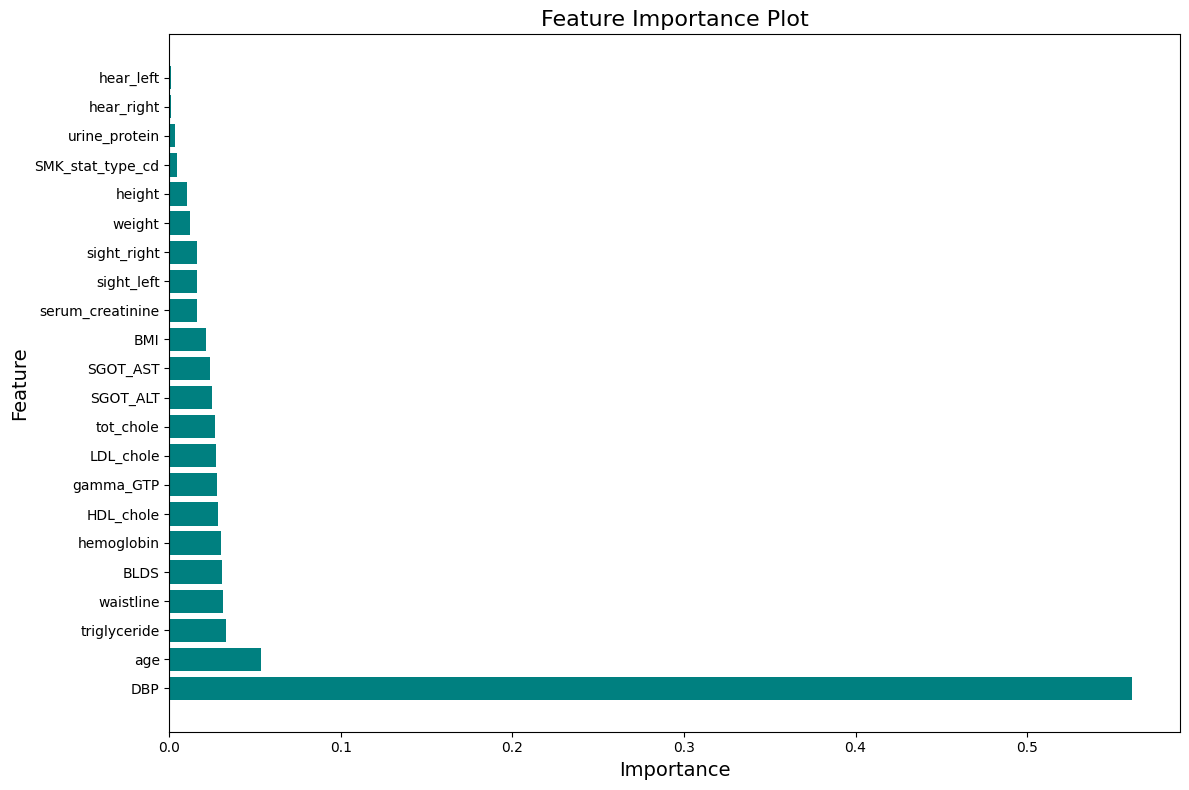

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
file_path = 'processed_health_data.csv'
df = pd.read_csv(file_path)

# Feature Engineering
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# Ensure numeric columns and remove invalid ones
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
target = 'SBP'
if target not in numeric_cols:
    raise ValueError(f"Target column '{target}' is missing from numeric columns.")

# Impute missing values
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Prepare features (X) and target (y)
X = df[numeric_cols].drop(columns=[target])
y = df[target]

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Valid features for Partial Dependence Plot
features = [feature for feature in ['BMI', 'weight', 'age'] if feature in X.columns]
if not features:
    raise ValueError("No valid features for Partial Dependence Plot. Check feature names.")

# Generate Partial Dependence Plot
fig, ax = plt.subplots(figsize=(20, 20))
PartialDependenceDisplay.from_estimator(model, X, features, ax=ax)
plt.tight_layout()
plt.savefig("partial_dependence_plots.png", dpi=300)
plt.show()

# Feature Importance Analysis
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

# Plot Feature Importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='teal')
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("Feature Importance Plot", fontsize=16)
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()

# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.6, color='purple')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.xlabel("Actual SBP", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.title("Residual Analysis", fontsize=16)
plt.tight_layout()
plt.savefig("residual_analysis.png", dpi=300)
plt.show()

# Actual vs Predicted Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=1)
plt.xlabel("Actual SBP", fontsize=14)
plt.ylabel("Predicted SBP", fontsize=14)
plt.title("Actual vs Predicted SBP", fontsize=16)
plt.tight_layout()
plt.savefig("actual_vs_predicted.png", dpi=300)
plt.show()

# 3D Partial Dependence Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
pdp_results = partial_dependence(model, X, ['BMI', 'weight'], grid_resolution=20)
xx, yy = np.meshgrid(pdp_results['values'][0], pdp_results['values'][1])
zz = pdp_results['average'].reshape(xx.shape)
ax.plot_surface(xx, yy, zz, cmap='coolwarm', alpha=0.8)
ax.set_xlabel('BMI', fontsize=14)
ax.set_ylabel('Weight', fontsize=14)
ax.set_zlabel('SBP', fontsize=14)
ax.set_title('3D Partial Dependence: BMI vs Weight', fontsize=16)
plt.tight_layout()
plt.savefig("3d_partial_dependence.png", dpi=300)
plt.show()


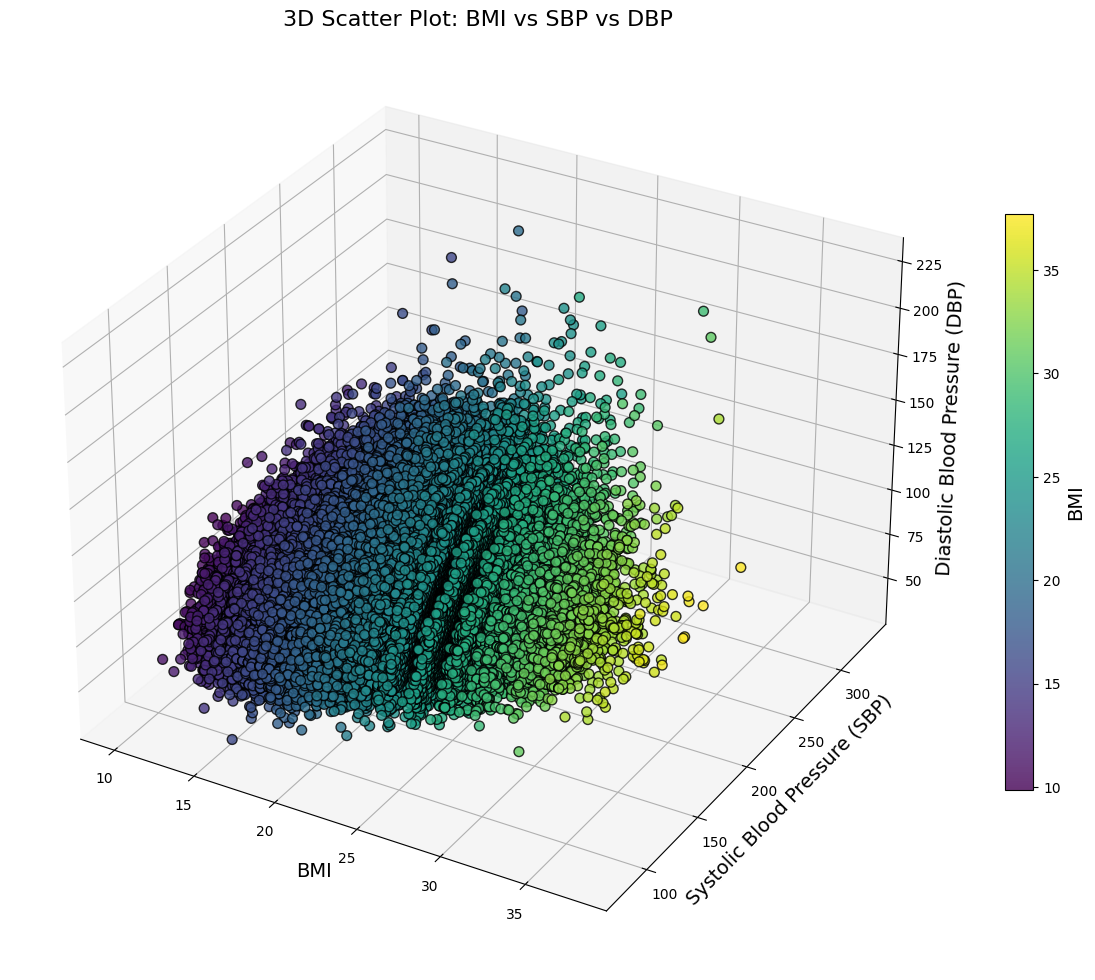

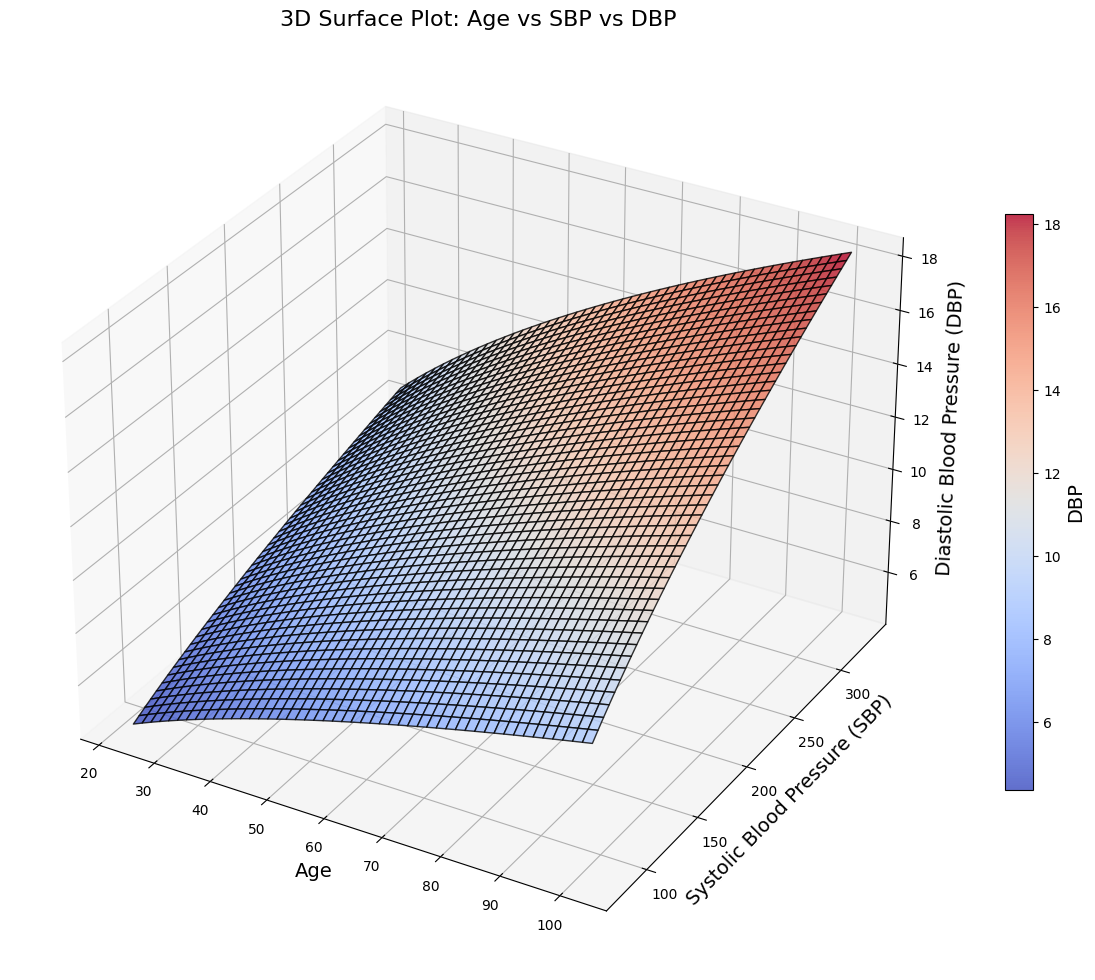

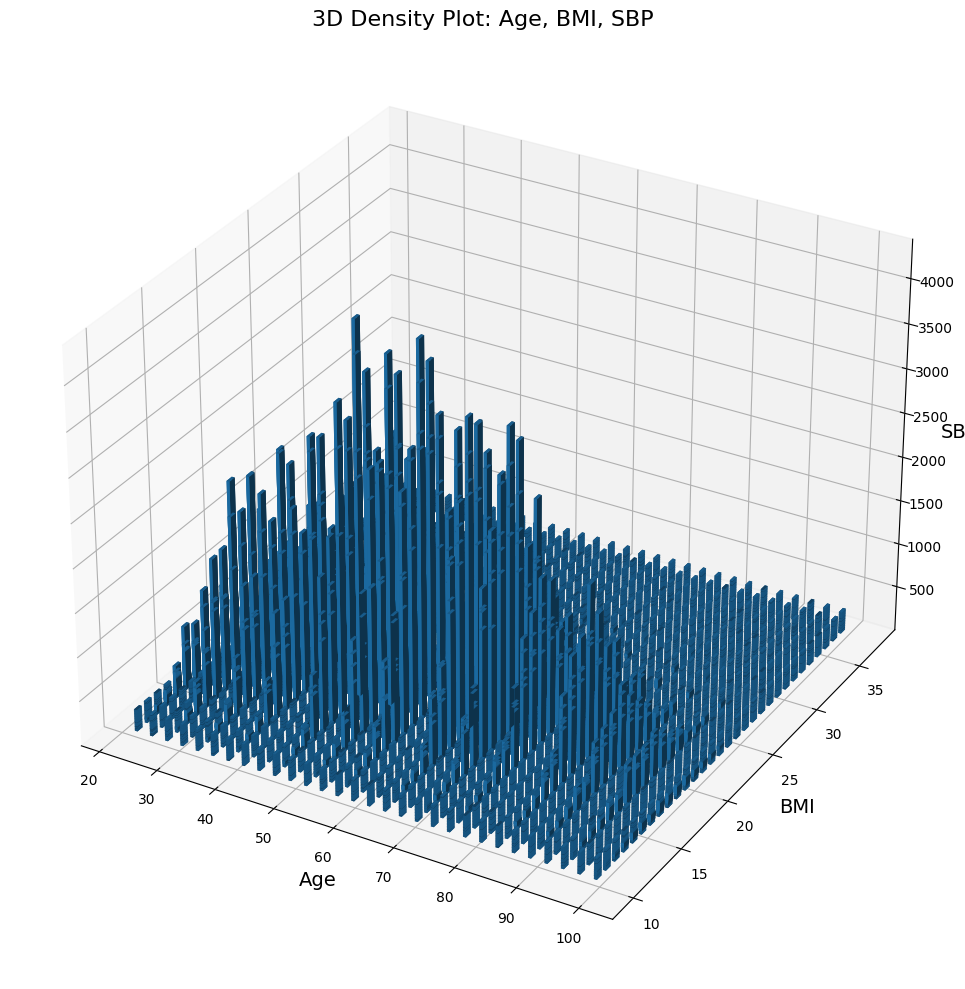

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load the dataset
file_path = 'processed_health_data.csv'
df = pd.read_csv(file_path)

# Ensure 'BMI' is calculated
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# 3D Scatter Plot: BMI, SBP, DBP (Diastolic Blood Pressure)
def plot_3d_scatter(df):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    x = df['BMI']
    y = df['SBP']
    z = df['DBP']

    sc = ax.scatter(x, y, z, c=df['BMI'], cmap='viridis', s=50, alpha=0.8, edgecolor='k')
    cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
    cbar.set_label('BMI', fontsize=14)

    ax.set_xlabel('BMI', fontsize=14)
    ax.set_ylabel('Systolic Blood Pressure (SBP)', fontsize=14)
    ax.set_zlabel('Diastolic Blood Pressure (DBP)', fontsize=14)
    ax.set_title('3D Scatter Plot: BMI vs SBP vs DBP', fontsize=16)

    plt.tight_layout()
    plt.savefig("3d_scatter_bmi_sbp_dbp.png", dpi=300)
    plt.show()

plot_3d_scatter(df)

# 3D Surface Plot: SBP, DBP, Age
def plot_3d_surface(df):
    # Create a meshgrid for Age, SBP, DBP
    age = np.linspace(df['age'].min(), df['age'].max(), 50)
    sbp = np.linspace(df['SBP'].min(), df['SBP'].max(), 50)
    age_grid, sbp_grid = np.meshgrid(age, sbp)
    dbp_grid = np.sqrt(age_grid * sbp_grid) / 10  # Simulated relationship for demonstration

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(age_grid, sbp_grid, dbp_grid, cmap='coolwarm', alpha=0.8, edgecolor='k')
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6)
    cbar.set_label('DBP', fontsize=14)

    ax.set_xlabel('Age', fontsize=14)
    ax.set_ylabel('Systolic Blood Pressure (SBP)', fontsize=14)
    ax.set_zlabel('Diastolic Blood Pressure (DBP)', fontsize=14)
    ax.set_title('3D Surface Plot: Age vs SBP vs DBP', fontsize=16)

    plt.tight_layout()
    plt.savefig("3d_surface_age_sbp_dbp.png", dpi=300)
    plt.show()

plot_3d_surface(df)

# 3D Density Plot: Age, BMI, SBP
def plot_3d_density(df):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    hist, edges = np.histogramdd((df['age'], df['BMI'], df['SBP']), bins=(30, 30, 30))
    xpos, ypos, zpos = np.meshgrid(edges[0][:-1], edges[1][:-1], edges[2][:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = zpos.ravel()
    values = hist.ravel()

    ax.bar3d(xpos, ypos, zpos, 0.5, 0.5, values, shade=True, cmap='magma')
    ax.set_xlabel('Age', fontsize=14)
    ax.set_ylabel('BMI', fontsize=14)
    ax.set_zlabel('SBP', fontsize=14)
    ax.set_title('3D Density Plot: Age, BMI, SBP', fontsize=16)

    plt.tight_layout()
    plt.savefig("3d_density_age_bmi_sbp.png", dpi=300)
    plt.show()

plot_3d_density(df)


In [ ]:
plt.figure(figsize=(20, 20))
sns.violinplot(x='BP_Category', y='BMI', data=df, palette='muted', scale='width')
plt.title("Violin Plot of BMI by Blood Pressure Category", fontsize=20)
plt.xlabel("Blood Pressure Category", fontsize=18)
plt.ylabel("BMI", fontsize=18)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("violin_plot_bmi_bp_category.png", dpi=300)
plt.show()


In [ ]:
plt.figure(figsize=(20, 20))
sns.clustermap(df.corr(), annot=True, cmap="coolwarm", figsize=(20, 20), linewidths=0.5, fmt='.2f')
plt.title("Clustered Heatmap of Feature Correlations", fontsize=20)
plt.savefig("clustermap.png", dpi=300)
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['BMI'], df['cholesterol'], df['SBP'], c='green', s=50, alpha=0.6, edgecolors='w')
ax.set_title("3D Scatterplot of BMI, Cholesterol, and SBP", fontsize=20)
ax.set_xlabel("BMI", fontsize=16)
ax.set_ylabel("Cholesterol", fontsize=16)
ax.set_zlabel("SBP", fontsize=16)

plt.tight_layout()
plt.savefig("3d_scatterplot.png", dpi=300)
plt.show()


In [ ]:
import shap

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.gcf().set_size_inches(20, 20)
plt.savefig("shap_summary_plot.png", dpi=300)
plt.show()


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate pairwise correlations and perform hierarchical clustering
correlation_matrix = df.corr()
linkage_matrix = linkage(correlation_matrix, method='ward')

# Plot heatmap with dendrogram
plt.figure(figsize=(20, 20))
sns.clustermap(
    correlation_matrix,
    row_linkage=linkage_matrix,
    col_linkage=linkage_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    figsize=(20, 20),
    linewidths=0.5
)
plt.title("Hierarchical Clustering Heatmap", fontsize=18)
plt.savefig("hierarchical_clustering_heatmap.png", dpi=300)
plt.show()


In [ ]:
from statsmodels.graphics.factorplots import interaction_plot

# Interaction between BMI, BP_Category, and SBP
plt.figure(figsize=(20, 20))
interaction_plot(
    x=df['BP_Category'],
    trace=df['BMI'] > 25,  # BMI threshold example
    response=df['SBP'],
    colors=['blue', 'red']
)
plt.title("Interaction Plot: BP_Category and BMI on SBP", fontsize=18)
plt.tight_layout()
plt.savefig("interaction_plot.png", dpi=300)
plt.show()


In [ ]:
from math import pi

# Select one instance or mean of BP_Category
category_means = df.groupby('BP_Category')[numeric_cols].mean()
categories = list(category_means.columns)
angles = np.linspace(0, 2 * pi, len(categories), endpoint=False).tolist()

# Repeat the first value to close the radar chart
angles += angles[:1]

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(polar=True))
for category in category_means.index:
    values = category_means.loc[category].tolist()
    values += values[:1]
    ax.plot(angles, values, label=category)
    ax.fill(angles, values, alpha=0.25)

ax.set_title("Radar Chart of Numeric Features by BP_Category", fontsize=18)
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=12)
plt.savefig("radar_chart_bp_category.png", dpi=300)
plt.show()
